Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=14
num_BackTrack_Days=0

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
## DROP_N=550 => 25/07/2021
## DROP_N=675 => 31/10/2021
#
drop_n_dataset_days=675
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
255                                           NaN                 Tunisia   
256                                           NaN                  Turkey   
257                                           NaN           United States   
258                                           NaN                  Uganda   
259                                           NaN                 Ukraine   
260                                           NaN    United Arab Emirates   
261                                      Anguilla          United Kingdom   
262                                       Bermuda          United Kingdom   
263                        British Virgin Islands          United Kingdom   
264                                Cayman Islands          United Kingdom   
265                               Channel Islands          United Kingdom   
266                   Falkland Islands (Malvinas)          United Kingdom   
267                                     Gibraltar          United Kingdom   
268                                      Guernsey          United Kingdom   
269                                   Isle of Man          United Kingdom   
270                                        Jersey          United Kingdom   
271                                    Montserrat          United Kingdom   
272  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
273                      Turks and Caicos Islands          United Kingdom   
274                                           NaN          United Kingdom   
275                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
261                                           NaN                 Tunisia   
262                                           NaN                  Turkey   
263                                           NaN           United States   
264                                           NaN                  Uganda   
265                                           NaN                 Ukraine   
266                                           NaN    United Arab Emirates   
267                                      Anguilla          United Kingdom   
268                                       Bermuda          United Kingdom   
269                        British Virgin Islands          United Kingdom   
270                                Cayman Islands          United Kingdom   
271                               Channel Islands          United Kingdom   
272                   Falkland Islands (Malvinas)          United Kingdom   
273                                     Gibraltar          United Kingdom   
274                                      Guernsey          United Kingdom   
275                                   Isle of Man          United Kingdom   
276                                        Jersey          United Kingdom   
277                                    Montserrat          United Kingdom   
278  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
279                      Turks and Caicos Islands          United Kingdom   
280                                           NaN          United Kingdom   
281                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN          Maldives   3.202800   73.220700        0        0   
186            NaN              Mali  17.570692   -3.996166        0        0   
187            NaN             Malta  35.937500   14.375400        0        0   
188            NaN  Marshall Islands   7.131500  171.184500        0        0   
189            NaN        Mauritania  21.007900  -10.940800        0        0   
190            NaN         Mauritius -20.348404   57.552152        0        0   
191            NaN            Mexico  23.634500 -102.552800        0        0   
192            NaN        Micronesia   7.425600  150.550800        0        0   
193            NaN           Moldova  47.411600   28.369900        0        0   
194            NaN            Monaco  43.733300    7.416700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  9/1/22  9/2/22  9/3/22  9/4/22  \
185        0        0        0        0  ...     308     308     308     308   
186        0        0        0        0  ...     739     739     739     739   
187        0        0        0        0  ...     801     801     801     802   
188        0        0        0        0  ...      17      17      17      17   
189        0        0        0        0  ...     993     993     993     993   
190        0        0        0        0  ...    1023    1023    1023    1023   
191        0        0        0        0  ...  329536  329572  329572  329622   
192        0        0        0        0  ...      27      27      27      27   
193        0        0        0        0  ...   11755   11755   11755   11755   
194        0        0        0        0  ...      61      61      61      61   

     9/5/22  9/6/22  9/7/22  9/8/22   Population                 region  
185     308     308     308     308       540,544          Maldives_nan  
186     739     739     739     739    20,250,833              Mali_nan  
187     802     802     802     802       441,543             Malta_nan  
188      17      17      17      17           NaN  Marshall Islands_nan  
189     993     993     993     993     4,649,658        Mauritania_nan  
190    1023    1023    1023    1023     1,273,985         Mauritius_nan  
191  329622  329652  329652  329652   128,640,794            Mexico_nan  
192      27      27      27      27           NaN        Micronesia_nan  
193   11755   11755   11783   11783     4,035,942           Moldova_nan  
194      61      63      63      63        39,183            Monaco_nan  

[10 rows x 967 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  1/22/20  1/23/20  \
175            NaN     Micronesia   7.425600  150.55080        0        0   
176            NaN        Moldova  47.411600   28.36990        0        0   
177            NaN         Monaco  43.733300    7.41670        0        0   
178            NaN       Mongolia  46.862500  103.84670        0        0   
179            NaN     Montenegro  42.708678   19.37439        0        0   
180            NaN        Morocco  31.791700   -7.09260        0        0   
181            NaN     Mozambique -18.665700   35.52960        0        0   
182            NaN        Namibia -22.957600   18.49040        0        0   
183            NaN          Nepal  28.166700   84.25000        0        0   
184          Aruba    Netherlands  12.521100  -69.96830        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  9/1/22  9/2/22  9/3/22  9/4/22  \
175        0        0        0        0  ...       0       0       0       0   
176        0        0        0        0  ...       0       0       0       0   
177        0        0        0        0  ...       0       0       0       0   
178        0        0        0        0  ...       0       0       0       0   
179        0        0        0        0  ...       0       0       0       0   
180        0        0        0        0  ...       0       0       0       0   
181        0        0        0        0  ...       0       0       0       0   
182        0        0        0        0  ...       0       0       0       0   
183        0        0        0        0  ...       0       0       0       0   
184        0        0        0        0  ...       0       0       0       0   

     9/5/22  9/6/22  9/7/22  9/8/22   Population              region  
175       0       0       0       0           NaN     Micronesia_nan  
176       0       0       0       0     4,035,942        Moldova_nan  
177       0       0       0       0        39,183         Monaco_nan  
178       0       0       0       0     3,278,290       Mongolia_nan  
179       0       0       0       0       622 500     Montenegro_nan  
180       0       0       0       0    36,817,128        Morocco_nan  
181       0       0       0       0    31,542,919     Mozambique_nan  
182       0       0       0       0     2,540,905        Namibia_nan  
183       0       0       0       0    29,300,000          Nepal_nan  
184       0       0       0       0       116,600  Netherlands_Aruba  

[10 rows x 967 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN          Maldives   3.202800   73.220700        0        0   
186            NaN              Mali  17.570692   -3.996166        0        0   
187            NaN             Malta  35.937500   14.375400        0        0   
188            NaN  Marshall Islands   7.131500  171.184500        0        0   
189            NaN        Mauritania  21.007900  -10.940800        0        0   
190            NaN         Mauritius -20.348404   57.552152        0        0   
191            NaN            Mexico  23.634500 -102.552800        0        0   
192            NaN        Micronesia   7.425600  150.550800        0        0   
193            NaN           Moldova  47.411600   28.369900        0        0   
194            NaN            Monaco  43.733300    7.416700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...   9/1/22   9/2/22   9/3/22  \
185        0        0        0        0  ...   184856   184856   184856   
186        0        0        0        0  ...    31462    31518    31576   
187        0        0        0        0  ...   114075   114097   114114   
188        0        0        0        0  ...    15058    15063    15063   
189        0        0        0        0  ...    62768    62769    62770   
190        0        0        0        0  ...   256452   256452   256452   
191        0        0        0        0  ...  7032024  7036371  7036371   
192        0        0        0        0  ...     7856     7856     7856   
193        0        0        0        0  ...   575052   575052   575052   
194        0        0        0        0  ...    14384    14398    14404   

      9/4/22   9/5/22   9/6/22   9/7/22   9/8/22   Population   \
185   184856   184924   184924   184924   184924       540,544   
186    31623    31664    31781    31912    31998    20,250,833   
187   114135   114151   114172   114195   114206       441,543   
188    15063    15063    15070    15071    15071           NaN   
189    62771    62771    62772    62772    62773     4,649,658   
190   256452   258301   258301   258301   258301     1,273,985   
191  7041181  7041181  7046220  7046220  7046220   128,640,794   
192     7856     8549     8776     9037     9037           NaN   
193   575052   575052   575052   579110   579110     4,035,942   
194    14404    14404    14412    14417    14424        39,183   

                   region  
185          Maldives_nan  
186              Mali_nan  
187             Malta_nan  
188  Marshall Islands_nan  
189        Mauritania_nan  
190         Mauritius_nan  
191            Mexico_nan  
192        Micronesia_nan  
193           Moldova_nan  
194            Monaco_nan  

[10 rows x 967 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                       Philippines  12.879721  121.774017   
221            NaN                            Poland  51.919400   19.145100   
222            NaN                          Portugal  39.399900   -8.224500   
223            NaN                             Qatar  25.354800   51.183900   
224            NaN                           Romania  45.943200   24.966800   
225            NaN                            Russia  61.524010  105.318756   
226            NaN                            Rwanda  -1.940300   29.873900   
227            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
228            NaN                       Saint Lucia  13.909400  -60.978900   
229            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...    9/1/22  \
220        0        0        0        0        0        0  ...   3883957   
221        0        0        0        0        0        0  ...   6180224   
222        0        0        0        0        0        0  ...   5420140   
223        0        0        0        0        0        0  ...    429963   
224        0        0        0        0        0        0  ...   3221984   
225        0        0        0        0        0        0  ...  19293663   
226        0        0        0        0        0        0  ...    132443   
227        0        0        0        0        0        0  ...      6515   
228        0        0        0        0        0        0  ...     28775   
229        0        0        0        0        0        0  ...      9429   

       9/2/22    9/3/22    9/4/22    9/5/22    9/6/22    9/7/22    9/8/22  \
220   3886395   3889160   3891418   3893573   3894840   3896541   3898882   
221   6183676   6186948   6187450   6187928   6193765   6198213   6202436   
222   5425891   5425891   5425891   5429340   5433073   5435782   5438351   
223    430484    430945    431519    432202    432846    433531    434153   
224   3224382   3226207   3227188   3228364   3231240   3233467   3235527   
225  19343942  19394864  19442127  19483167  19521190  19568544  19618428   
226    132448    132449    132453    132455    132458    132466    132471   
227      6517      6517      6517      6517      6524      6524      6524   
228     28832     28894     28894     28894     28894     28894     28894   
229      9430      9430      9430      9430      9430      9430      9430   

      Population                                 region  
220   104,900,000                       Philippines_nan  
221    37,980,000                            Poland_nan  
222    10,290,000                          Portugal_nan  
223     2,870,256                             Qatar_nan  
224    19,530,000                           Romania_nan  
225   144,500,000                            Russia_nan  
226    12,952,218                            Rwanda_nan  
227        53,673             Saint Kitts and Nevis_nan  
228       184,106                       Saint Lucia_nan  
229       110,940  Saint Vincent and the Grenadines_nan  

[10 rows x 967 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

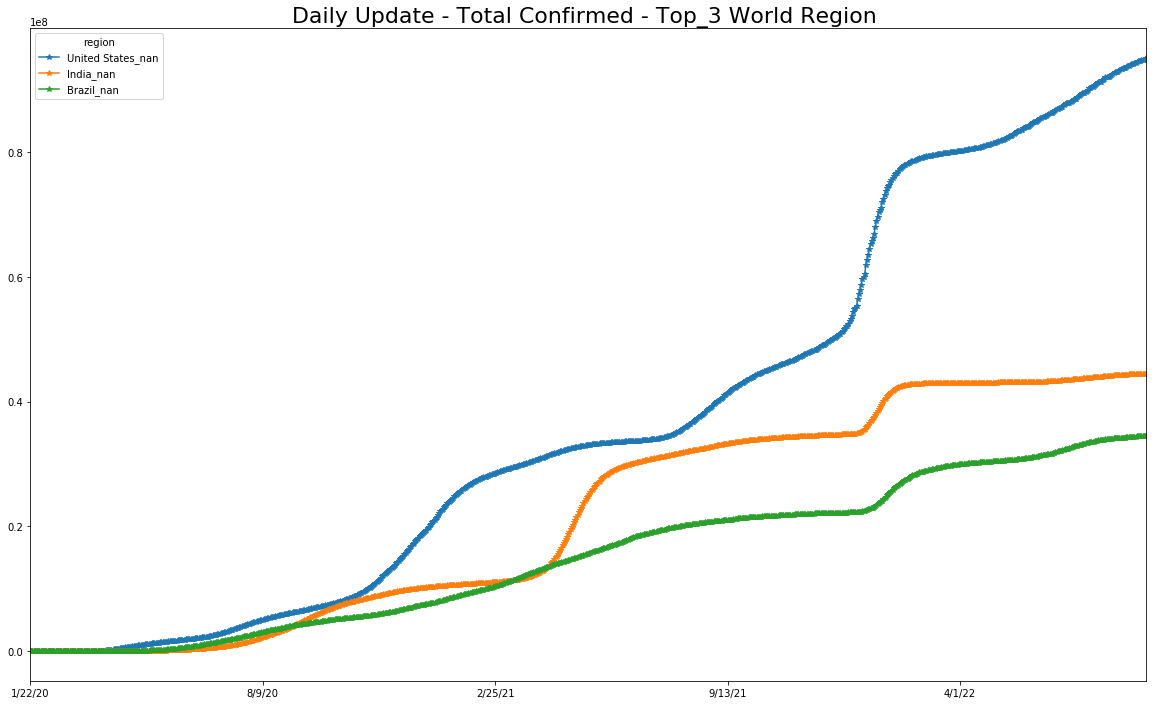

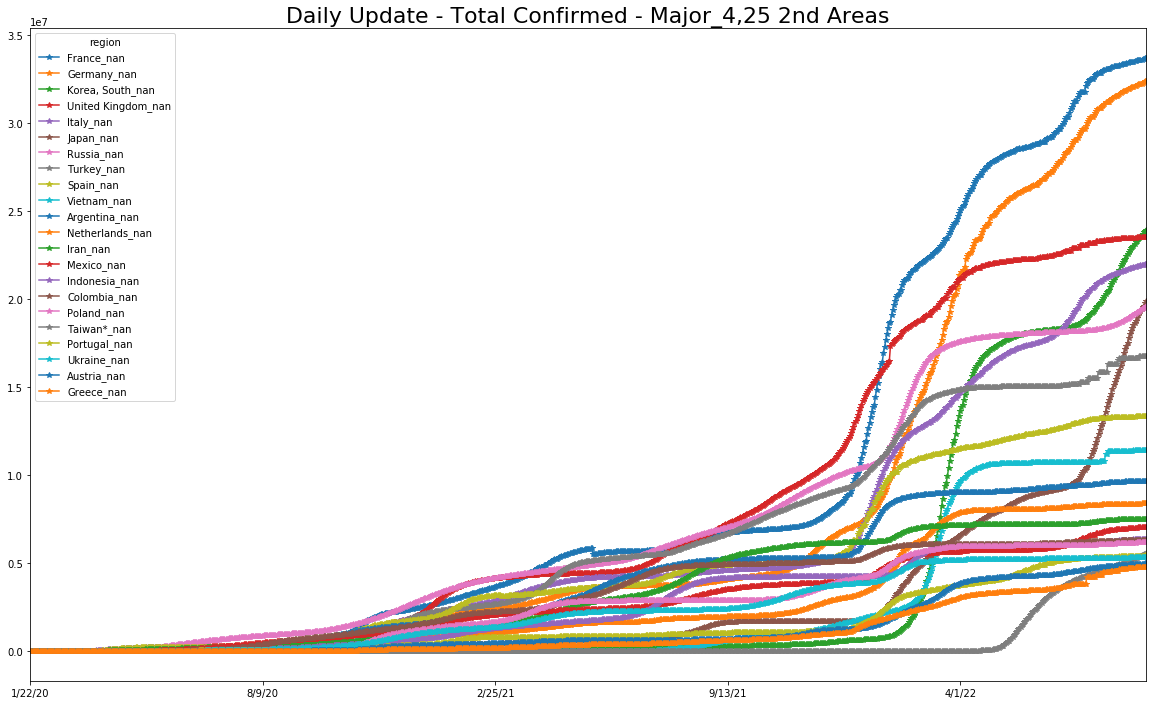

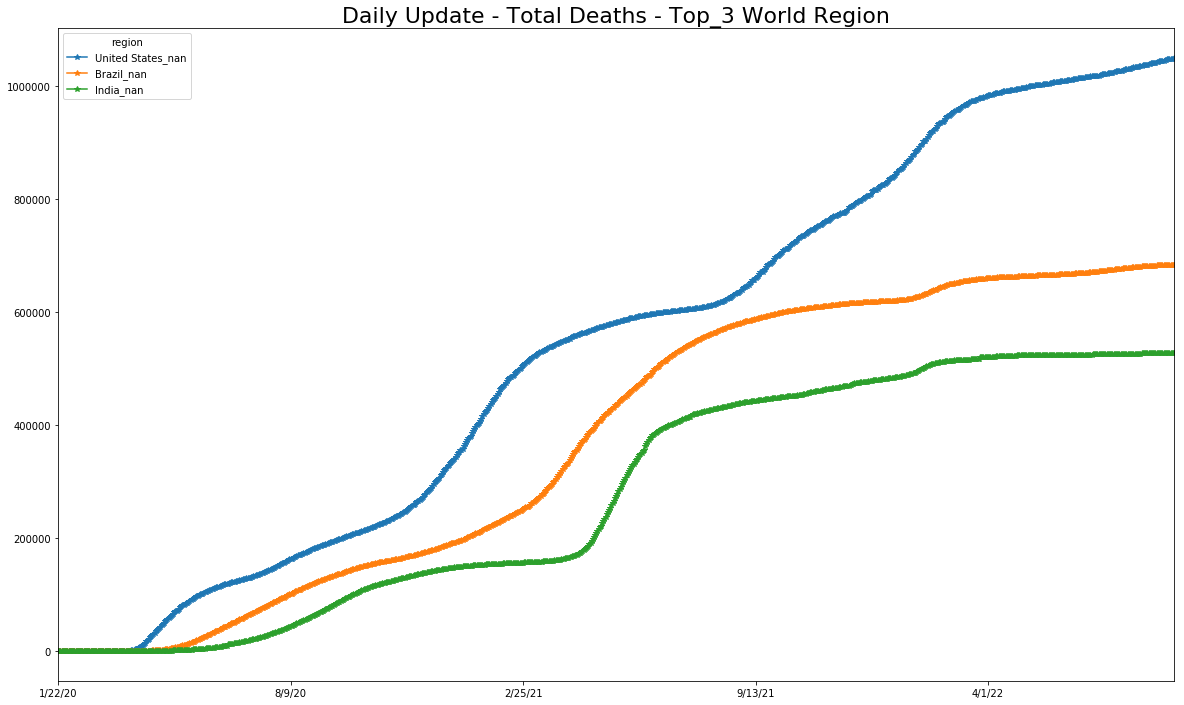

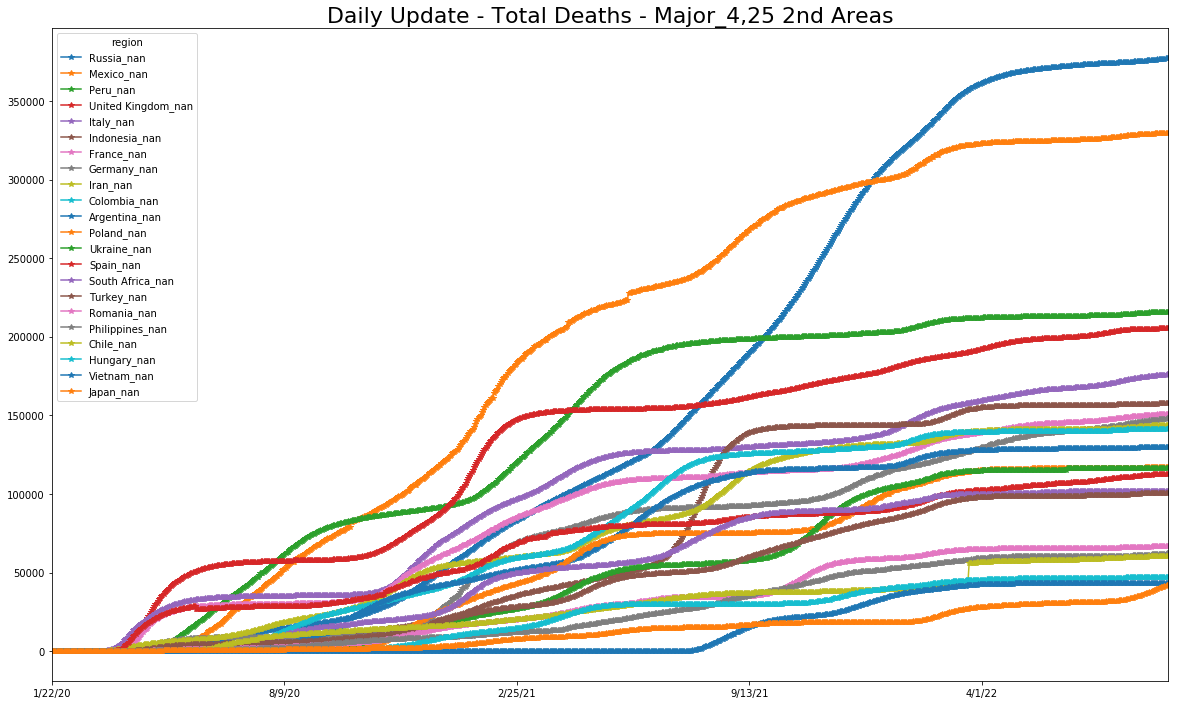

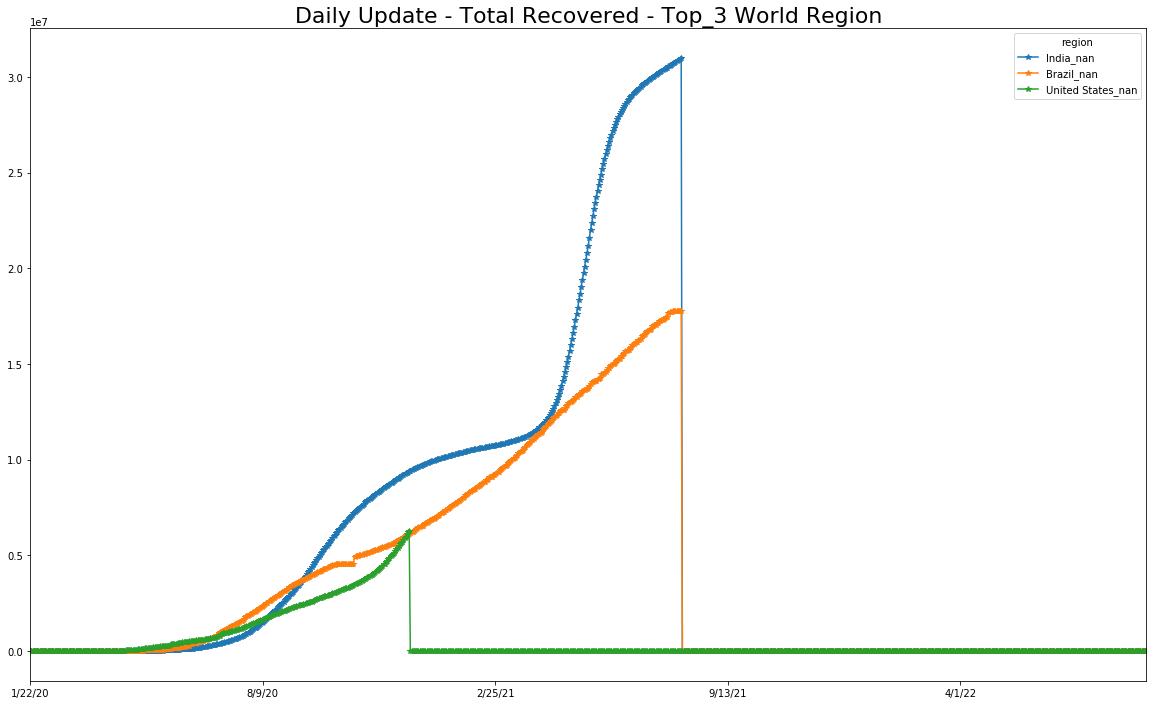

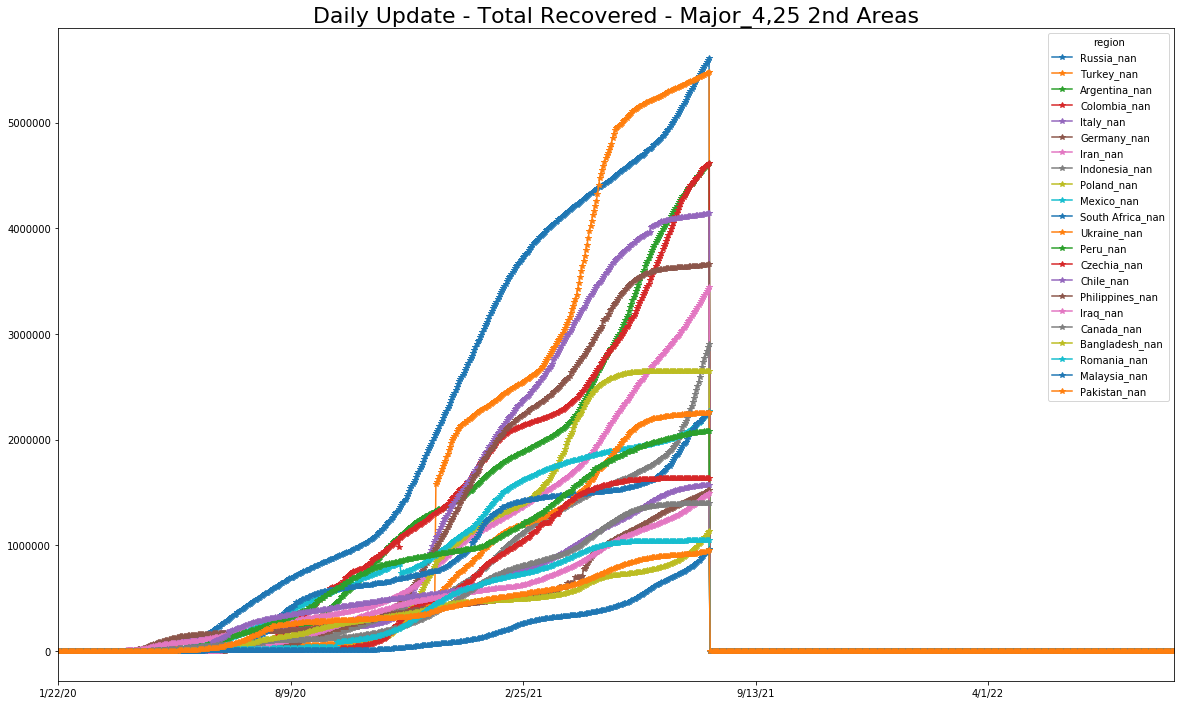

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/09/09


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/27/21           157190       199137       209980        16712       65139   
11/28/21           157218       199555       210152        16712       65144   
11/29/21           157260       199750       210344        16712       65155   

region    Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/27/21               0                     4141        5325560       337522   
11/28/21               0                     4141        5326448       337931   
11/29/21               0                     4141        5328416       338120   

region    Australia_Australian Capital Territory  ...  Uruguay_nan  \
11/27/21                                    2117  ...       399181   
11/28/21                                    2124  ...       399348   
11/29/21                                    2130  ...       399504   

region    Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
11/27/21          192599            6         430046      1197404   
11/28/21          192831            6         430696      1210340   
11/29/21          193065            6         431296      1224110   

region    West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
11/27/21                  459479                         0       9981   
11/28/21                  459479                         0       9987   
11/29/21                  460053                         0       9995   

region    Zambia_nan  Zimbabwe_nan  
11/27/21      210138        133836  
11/28/21      210143        133951  
11/29/21      210150        134226  

[3 rows x 285 columns]

In [25]:
ts[-4:]

region  Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
9/5/22           194355       330221       270461        46027      102636   
9/6/22           194614       330283       270476        46027      102636   
9/7/22           195012       330516       270489        46113      102636   
9/8/22           195298       330687       270507        46113      102636   

region  Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
9/5/22              11                     8974        9689861       436727   
9/6/22              11                     8974        9689861       436727   
9/7/22              11                     8974        9689861       436727   
9/8/22              11                     8974        9689861       436727   

region  Australia_Australian Capital Territory  ...  Uruguay_nan  \
9/5/22                                  203476  ...       981186   
9/6/22                                  203613  ...       981186   
9/7/22                                  203786  ...       981186   
9/8/22                                  203786  ...       981186   

region  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
9/5/22          243863        11864         542952     11421055   
9/6/22          243879        11892         543123     11424754   
9/7/22          243893        11902         543204     11428632   
9/8/22          243893        11902         543204     11431823   

region  West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
9/5/22                  702332                       535      11931   
9/6/22                  702591                       535      11931   
9/7/22                  702591                       535      11931   
9/8/22                  702591                       535      11932   

region  Zambia_nan  Zimbabwe_nan  
9/5/22      333086        256769  
9/6/22      333124        256782  
9/7/22      333150        256825  
9/8/22      333180        256834  

[4 rows x 285 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-11-28  Afghanistan_nan     157218             0             0   
2     2021-11-29  Afghanistan_nan     157260            28             0   
3     2021-11-30  Afghanistan_nan     157289            42             0   
4     2021-12-01  Afghanistan_nan     157359            29            99   
5     2021-12-02  Afghanistan_nan     157387            70           141   
6     2021-12-03  Afghanistan_nan     157412            28           127   
7     2021-12-04  Afghanistan_nan     157431            25           123   
8     2021-12-05  Afghanistan_nan     157454            19            72   
9     2021-12-06  Afghanistan_nan     157499            23            67   
10    2021-12-07  Afghanistan_nan     157508            45            87   
11    2021-12-08  Afghanistan_nan     157542             9            77   
12    2021-12-09  Afghanistan_nan     157585            34            88   
13    2021-12-10  Afghanistan_nan     157603            43            86   
14    2021-12-11  Afghanistan_nan     157611            18            95   
15    2021-12-12  Afghanistan_nan     157633             8            69   
16    2021-12-13  Afghanistan_nan     157648            22            48   
17    2021-12-14  Afghanistan_nan     157660            15            45   
18    2021-12-15  Afghanistan_nan     157665            12            49   
19    2021-12-16  Afghanistan_nan     157725             5            32   
20    2021-12-17  Afghanistan_nan     157734            60            77   
21    2021-12-18  Afghanistan_nan     157745             9            74   
22    2021-12-19  Afghanistan_nan     157787            11            80   
23    2021-12-20  Afghanistan_nan     157797            42            62   
24    2021-12-21  Afghanistan_nan     157816            10            63   
25    2021-12-22  Afghanistan_nan     157841            19            71   
26    2021-12-23  Afghanistan_nan     157878            25            54   
27    2021-12-24  Afghanistan_nan     157887            37            81   
28    2021-12-25  Afghanistan_nan     157895             9            71   
29    2021-12-26  Afghanistan_nan     157951             8            54   
30    2021-12-27  Afghanistan_nan     157967            56            73   
...          ...              ...        ...           ...           ...   
83487 2022-08-11     Zimbabwe_nan     256513             2            45   
83488 2022-08-12     Zimbabwe_nan     256522            21            26   
83489 2022-08-13     Zimbabwe_nan     256522             9            32   
83490 2022-08-14     Zimbabwe_nan     256539             0            30   
83491 2022-08-15     Zimbabwe_nan     256544            17            26   
83492 2022-08-16     Zimbabwe_nan     256561             5            22   
83493 2022-08-17     Zimbabwe_nan     256565            17            39   
83494 2022-08-18     Zimbabwe_nan     256579             4            26   
83495 2022-08-19     Zimbabwe_nan     256596            14            35   
83496 2022-08-20     Zimbabwe_nan     256616            17            35   
83497 2022-08-21     Zimbabwe_nan     256624            20            51   
83498 2022-08-22     Zimbabwe_nan     256628             8            45   
83499 2022-08-23     Zimbabwe_nan     256628             4            32   
83500 2022-08-24     Zimbabwe_nan     256628             0            12   
83501 2022-08-25     Zimbabwe_nan     256675             0             4   
83502 2022-08-26     Zimbabwe_nan     256682            47            47   
83503 2022-08-27     Zimbabwe_nan     256682             7            54   
83504 2022-08-28     Zimbabwe_nan     256699             0            54   
83505 2022-08-29     Zimbabwe_nan     256704            17            24   
83506 2022-08-30     Zimbabwe_nan     256708             5            22   
83507 2022-08-31     Zimbabwe_nan     256726             4  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
83516 2022-09-09  Zimbabwe_nan          0             9            65   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
83516            96         100.003508         100.025318         100.037396   

       last_day  kalman_prediction  population  infected_rate  min  max  
83516    256834           256843.0    14862924       0.000173  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
83516 2022-09-09  Zimbabwe_nan          0             9            65   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
83516            96         100.003508         100.025318         100.037396   

       last_day  kalman_prediction  population  infected_rate  min  max  
83516    256834           256843.0    14862924       0.000173  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
81792  2022-09-07  Zimbabwe_nan     256825            13            27   
81793  2022-09-08  Zimbabwe_nan     256834            43            62   
81794  2022-09-09  Zimbabwe_nan          0             9            65   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
81792            74         100.005067         100.010520         100.028830   
81793            99         100.016750         100.024151         100.038566   
81794            96         100.003508         100.025318         100.037396   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
81792               256782  ...    14862924       0.000173  NaN  NaN   
81793               256825  ...    14862924       0.000173  NaN  NaN   
81794               256834  ...    14862924       0.000173  NaN  NaN   

       population_percentage : infected_rate confirmed  \
81792                                         0.017277   
81793                                         0.017280   
81794                                         0.017280   

       population_percentage : factor 9/10 infected_rate confirmed  \
81792                                           0.155491             
81793                                           0.155517             
81794                                           0.155522             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
81792                     8.0                           0.538252   
81793                    -4.0                          -0.269126   
81794                     9.0                           0.605534   

       delta : roling 7day AVG  \
81792                10.571429   
81793                14.142857   
81794                13.714286   

       delta : aprox 14-day case notification rate per 100k hab  
81792                                           0.995766         
81793                                           1.332174         
81794                                           1.291805         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse       mae
274  United States_nan  3.188343e+13  5.646541e+06  459807.0


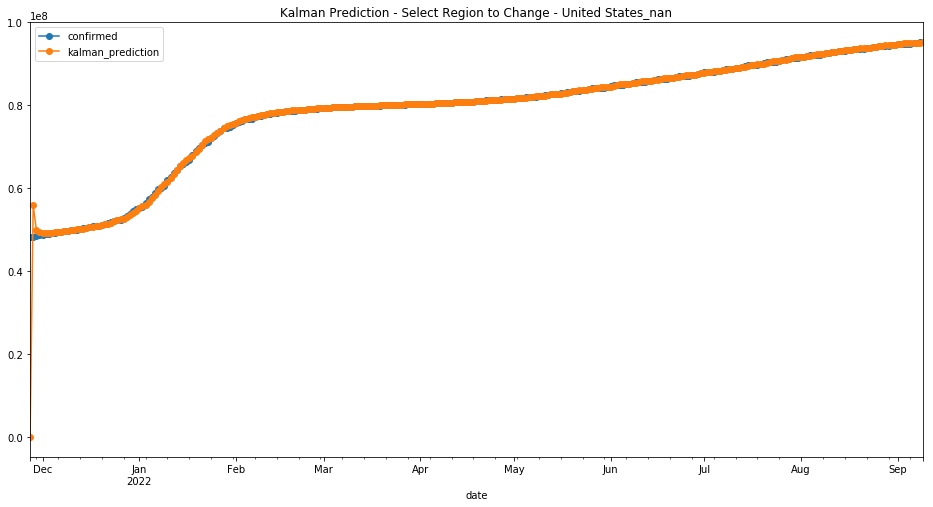

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse           mae
219  Russia_nan  1.360029e+12  1.166203e+06  86662.318182


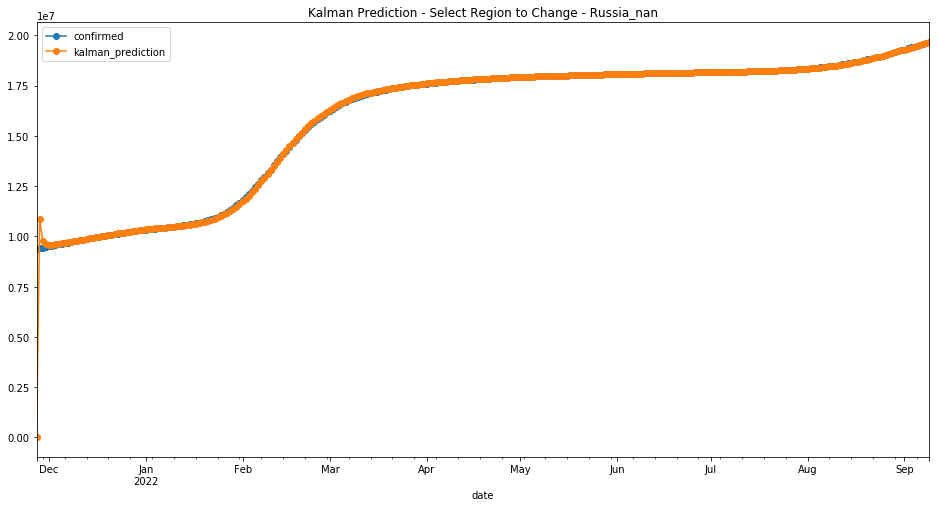

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
31  Brazil_nan  4.206430e+12  2.050958e+06  164299.611888


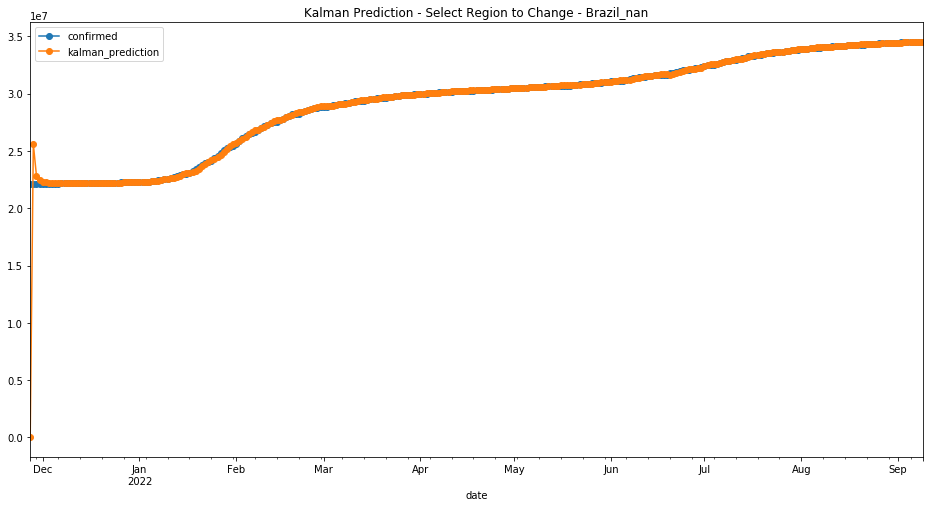

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse            mae
273  United Kingdom_nan  1.951853e+12  1.397087e+06  124852.625874


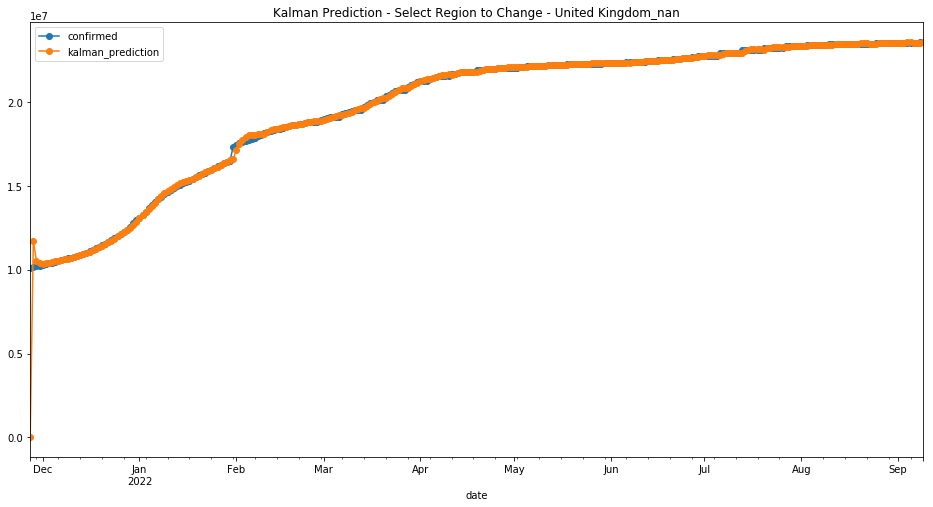

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpsxwc8fvl
  JVM stdout: /tmp/tmpsxwc8fvl/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpsxwc8fvl/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 10 months and 13 days !!!
H2O cluster name:           H2O_from_python_unknownUser_wmfemd
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-09-01
last_train_date= 2022-09-08
first_bootstrap_date= 2022-08-31
boost_bootstrap_date= 2022-09-05
first_test_date= 2022-08-30
last_test_date= 2022-09-09
first_valid_date= 2022-09-07


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   195183.0     193250 2022-08-31  Afghanistan_nan
1   195404.0     193520 2022-09-01  Afghanistan_nan
2   195659.0     193520 2022-09-02  Afghanistan_nan
3   195775.0     193912 2022-09-03  Afghanistan_nan
4   195972.0     194163 2022-09-04  Afghanistan_nan
5   196256.0     194355 2022-09-05  Afghanistan_nan
6   196503.0     194614 2022-09-06  Afghanistan_nan
7   196726.0     195012 2022-09-07  Afghanistan_nan
8   197056.0     195298 2022-09-08  Afghanistan_nan
9   197399.0          0 2022-09-09  Afghanistan_nan
10  330638.0     329352 2022-08-31      Albania_nan
11  330920.0     329615 2022-09-01      Albania_nan
12  331189.0     329862 2022-09-02      Albania_nan
13  331447.0     330062 2022-09-03      Albania_nan
14  331659.0     330193 2022-09-04      Albania_nan
15  331797.0     330221 2022-09-05      Albania_nan
16  331822.0     330283 2022-09-06      Albania_nan
17  331870.0     330516 2022-09-07      Albania_nan
18  332035.0     330687 2022-09-08      Albania_nan
19  332171.0          0 2022-09-09      Albania_nan
20  272306.0     270304 2022-08-31      Algeria_nan
21  272334.0     270359 2022-09-01      Algeria_nan
22  272380.0     270405 2022-09-02      Algeria_nan
23  272424.0     270426 2022-09-03      Algeria_nan
24  272453.0     270443 2022-09-04      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  4968712.0    4977837 2022-09-05     Austria_nan
176  4982225.0    4980628 2022-09-06     Austria_nan
177  4981930.0    4984809 2022-09-07     Austria_nan
178  4987166.0    4984809 2022-09-08     Austria_nan
179  4986602.0          0 2022-09-09     Austria_nan
180   814801.0     813437 2022-08-31  Azerbaijan_nan
181   815393.0     813998 2022-09-01  Azerbaijan_nan
182   815919.0     814435 2022-09-02  Azerbaijan_nan
183   816356.0     815047 2022-09-03  Azerbaijan_nan
184   817000.0     815523 2022-09-04  Azerbaijan_nan
185   817463.0     815523 2022-09-05  Azerbaijan_nan
186   817428.0     816087 2022-09-06  Azerbaijan_nan
187   818073.0     816589 2022-09-07  Azerbaijan_nan
188   818485.0     816985 2022-09-08  Azerbaijan_nan
189   818847.0          0 2022-09-09  Azerbaijan_nan
190    38624.0      37075 2022-08-31     Bahamas_nan
191    38584.0      37081 2022-09-01     Bahamas_nan
192    38623.0      37081 2022-09-02     Bahamas_nan
193    38646.0      37081 2022-09-03     Bahamas_nan
194    38642.0      37081 2022-09-04     Bahamas_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date        region
220  101074.0     101120 2022-08-31  Barbados_nan
221  101200.0     101215 2022-09-01  Barbados_nan
222  101347.0     101215 2022-09-02  Barbados_nan
223  101449.0     101397 2022-09-03  Barbados_nan
224  101411.0     101451 2022-09-04  Barbados_nan
225  101588.0     101510 2022-09-05  Barbados_nan
226  101648.0     101624 2022-09-06  Barbados_nan
227  101686.0     101696 2022-09-07  Barbados_nan
228  101801.0     101747 2022-09-08  Barbados_nan
229  101877.0          0 2022-09-09  Barbados_nan
230  995375.0     994037 2022-08-31   Belarus_nan
231  995375.0     994037 2022-09-01   Belarus_nan
232  995375.0     994037 2022-09-02   Belarus_nan
233  995375.0     994037 2022-09-03   Belarus_nan
234  995375.0     994037 2022-09-04   Belarus_nan
235  995375.0     994037 2022-09-05   Belarus_nan
236  995375.0     994037 2022-09-06   Belarus_nan
237  995375.0     994037 2022-09-07   Belarus_nan
238  995375.0     994037 2022-09-08   Belarus_nan
239  995375.0          0 2022-09-09   Belarus_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  208060797015.78082
# MSE on the validation data =  157791042748912.72
# R^2 on the training data =  0.999120262363309
# R^2 on the validation data =  0.36734629691912435


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1662711437075_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 208060797015.78082
RMSE: 456136.81830760033
MAE: 33420.347252867294
RMSLE: 0.4490869078509662
Mean Residual Deviance: 208060797015.78082

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 157791042748912.72
RMSE: 12561490.466855943
MAE: 4144266.9617811367
RMSLE: 8.754696614117753
Mean Residual Deviance: 157791042748912.72
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2022-09-09 08:17:26  0.064 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2022-09-09 08:17:26  0.527 sec   1.0                1257205.8533716167  122526.5795304978   1580566557751.8547   12548327.715903241  4116709.8472180064  157460528465705.47
     2022-09-09 08:17:27  0.670 sec   2.0                984801.2231288591   95416.30903674407   969833449076.0968    12570826.105963124  4130627.1371242763  158025668986364.0
     2022-09-09 08:17:27  0.793 sec   3.0                899654.3317742591   89349.54866176119   809377916680.1886    12575769.977467025  4133077.1357222083  158149990526160.97
     2022-09-09 08:17:27  1.080 sec   4.0                805615.7544351073   81075.79706395492   649016743794.0471    12581185.968382092  4132581.518933408   158286240371014.44
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2022-09-09 08:17:46  20.211 sec  291.0              448554.73294061294  34525.11261938322   201201348443.4246    12563743.972544072  4145039.16805395    157847662607637.5
     2022-09-09 08:17:50  24.215 sec  357.0              457450.7557776279   34361.33778102535   209261193961.52298   12565331.724419393  4145411.848500956   157887561344700.44
     2022-09-09 08:17:54  28.232 sec  422.0              452655.78518775525  33708.300068773315  204897259863.94324   12563644.189624907  4144633.601287792   157845155323495.72
     2022-09-09 08:17:58  32.268 sec  483.0              458424.888504188    33573.68073635407   210153378400.0772    12562120.163319888  4144622.093695843   157806862997688.1
     2022-09-09 08:17:59  33.583 sec  500.0              456136.81830760033  33420.347252867294  208060797015.78082   12561490.466855943  4144266.9617811367  157791042748912.72


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  3.78102e+20            1                    0.349531
last_day           3.39654e+20            0.898313             0.313988
region             2.4837e+20             0.656887             0.229602
7_day_change       5.05304e+19            0.133642             0.0467121
3_day_change       1.96048e+19            0.0518505            0.0181233
infected_rate      1.95506e+19            0.0517073            0.0180733
1_day_change       1.1723e+19             0.0310048            0.0108371
3_day_change_rate  6.28569e+18            0.0166243            0.00581071
7_day_change_rate  4.81674e+18            0.0127393            0.00445276
1_day_change_rate  3.10433e+18            0.0082103            0.00286975

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         3.781021e+20           1.000000    0.349531
1           last_day         3.396541e+20           0.898313    0.313988
2             region         2.483702e+20           0.656887    0.229602
3       7_day_change         5.053041e+19           0.133642    0.046712
4       3_day_change         1.960477e+19           0.051850    0.018123
5      infected_rate         1.955065e+19           0.051707    0.018073
6       1_day_change         1.172299e+19           0.031005    0.010837
7  3_day_change_rate         6.285692e+18           0.016624    0.005811
8  7_day_change_rate         4.816739e+18           0.012739    0.004453
9  1_day_change_rate         3.104330e+18           0.008210    0.002870

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


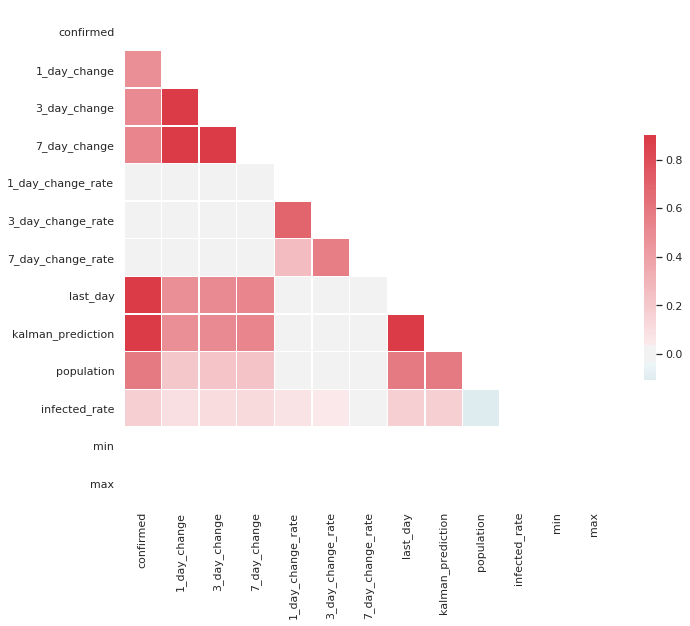

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.481454
3_day_change         0.512499
7_day_change         0.530923
1_day_change_rate    0.017436
3_day_change_rate    0.006951
7_day_change_rate   -0.003501
last_day             0.995812
kalman_prediction    0.996516
population           0.587829
infected_rate        0.170743
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


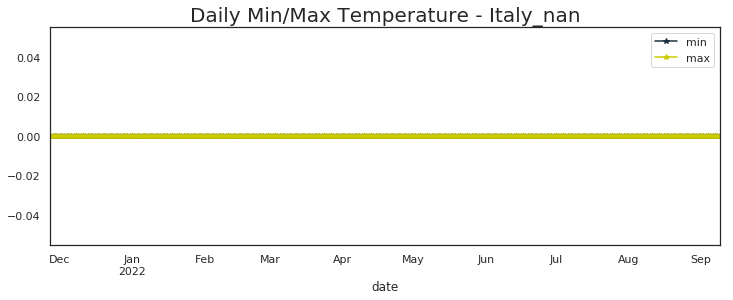

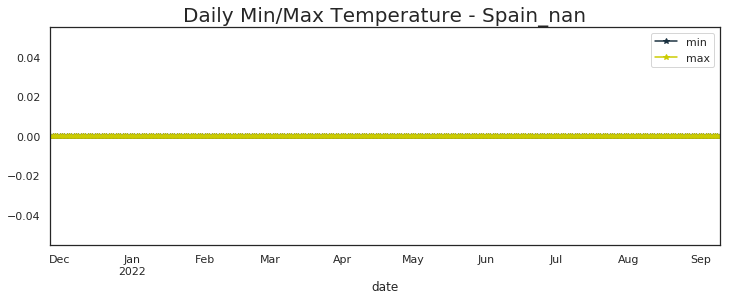

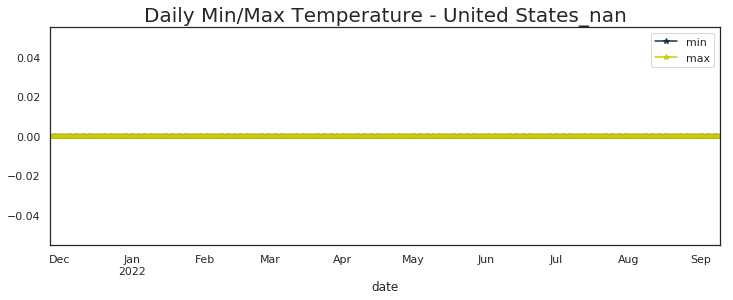

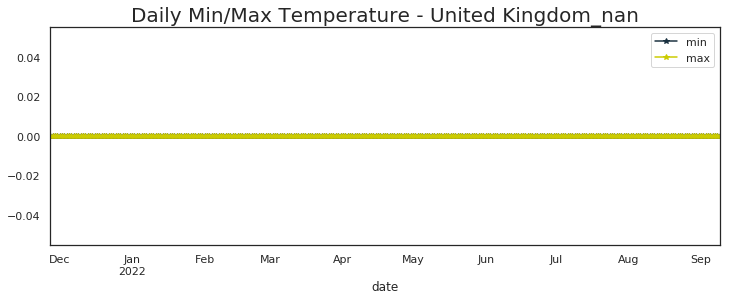

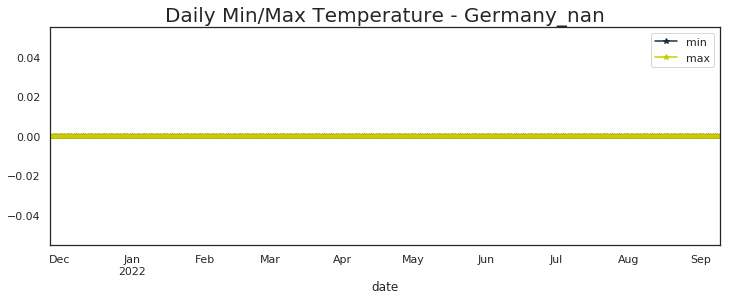

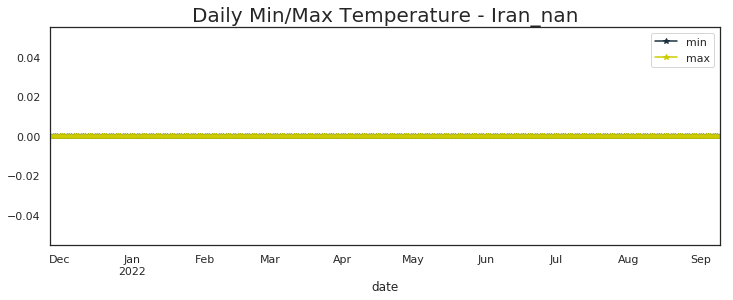

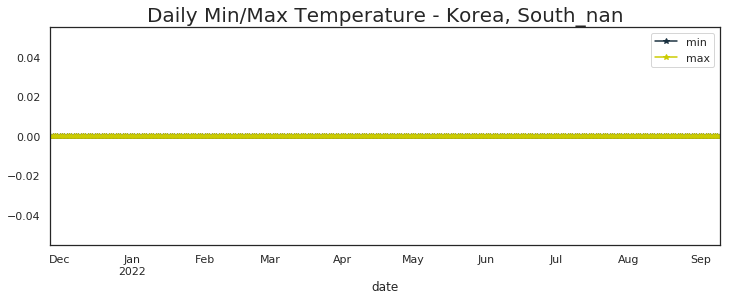

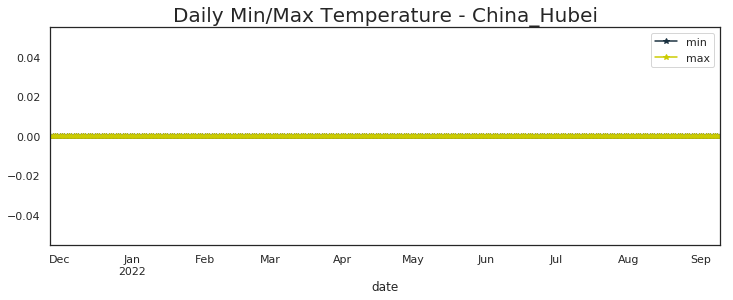

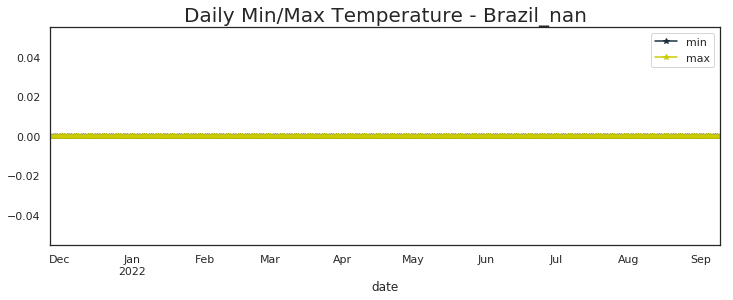

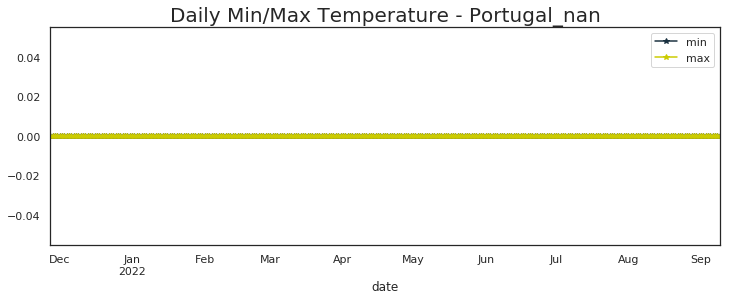

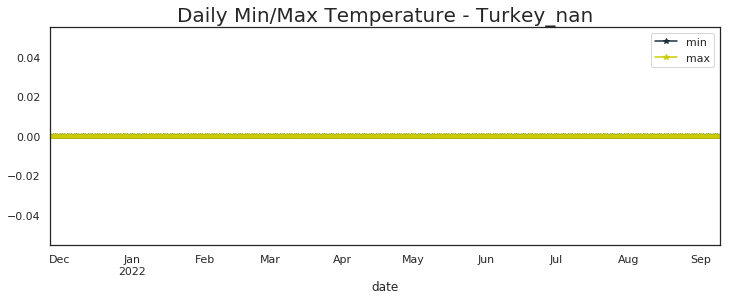

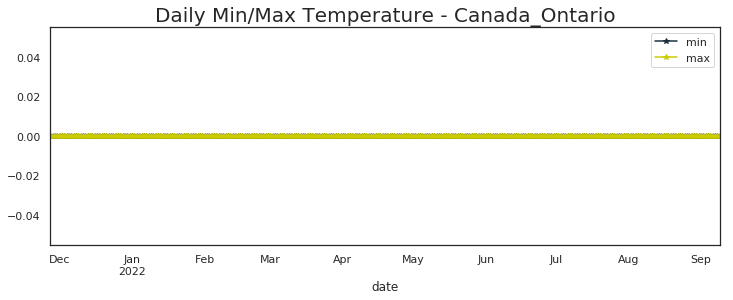

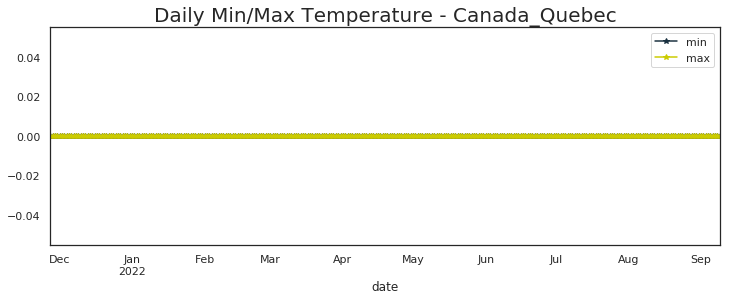

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                           min  max
region                             
United States_nan          0.0  0.0
India_nan                  0.0  0.0
Brazil_nan                 0.0  0.0
France_nan                 0.0  0.0
Germany_nan                0.0  0.0
Korea, South_nan           0.0  0.0
United Kingdom_nan         0.0  0.0
Italy_nan                  0.0  0.0
Japan_nan                  0.0  0.0
Russia_nan                 0.0  0.0
Turkey_nan                 0.0  0.0
Spain_nan                  0.0  0.0
Vietnam_nan                0.0  0.0
Argentina_nan              0.0  0.0
Netherlands_nan            0.0  0.0
Iran_nan                   0.0  0.0
Mexico_nan                 0.0  0.0
Indonesia_nan              0.0  0.0
Colombia_nan               0.0  0.0
Poland_nan                 0.0  0.0
Taiwan*_nan                0.0  0.0
Portugal_nan               0.0  0.0
Ukraine_nan                0.0  0.0
Austria_nan                0.0  0.0
Greece_nan                 0

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

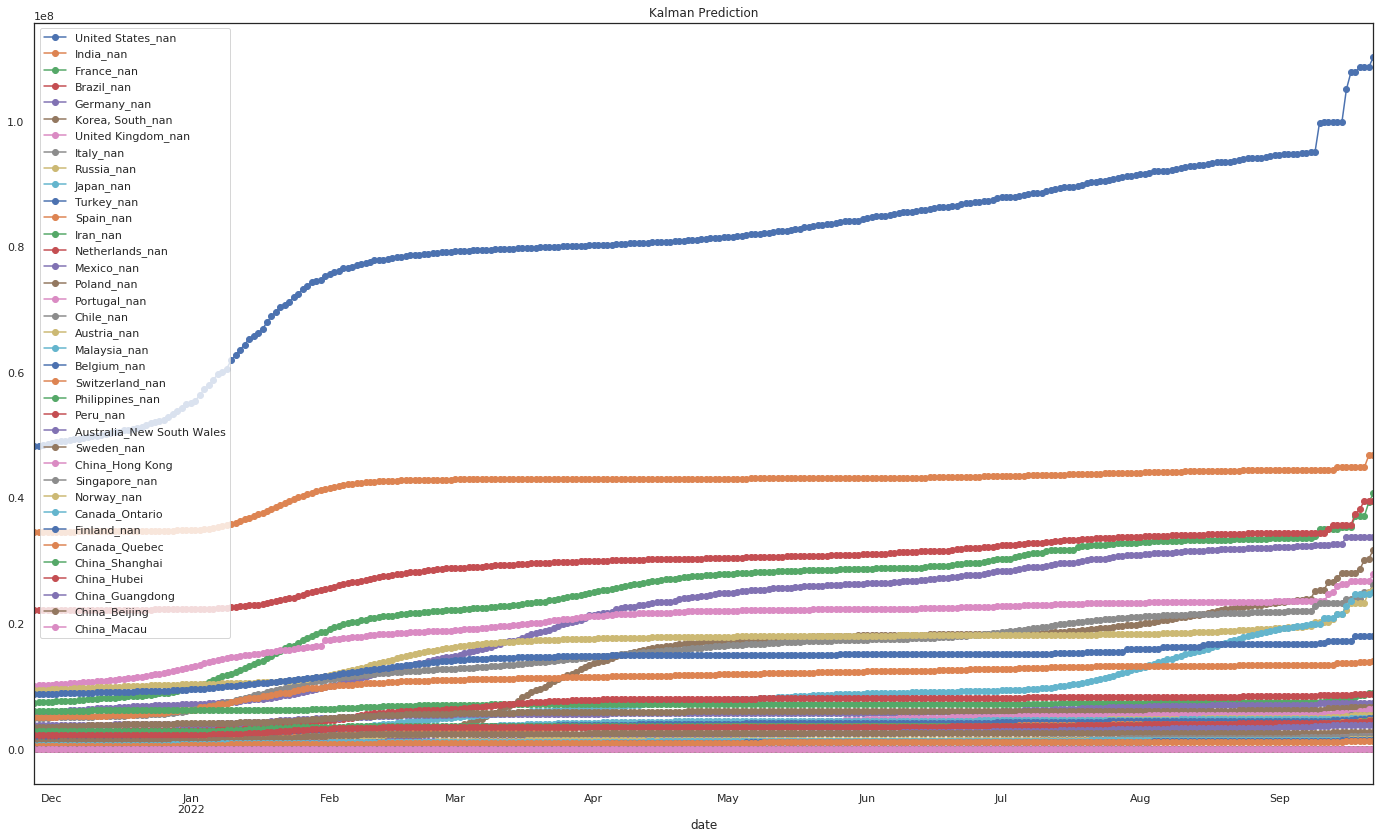

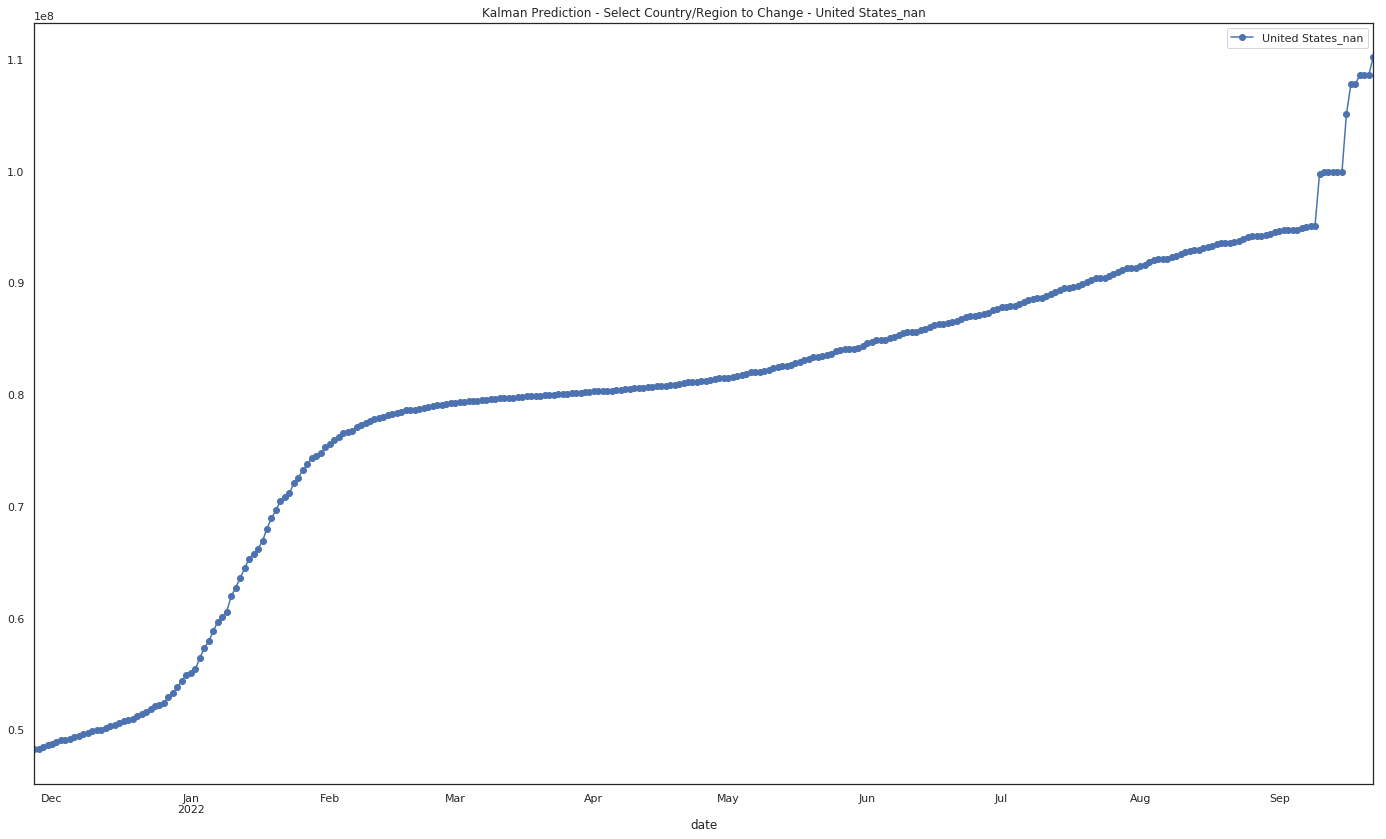

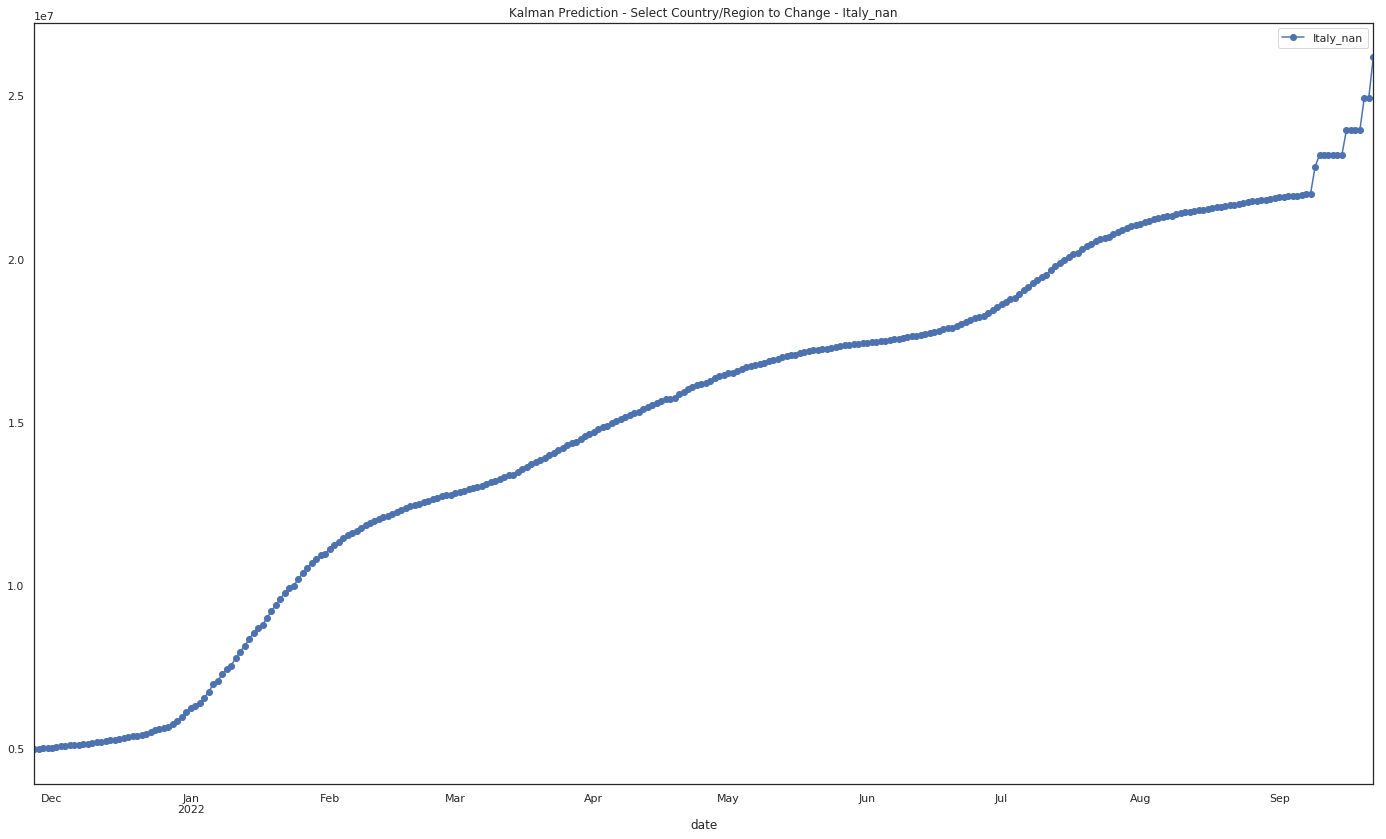

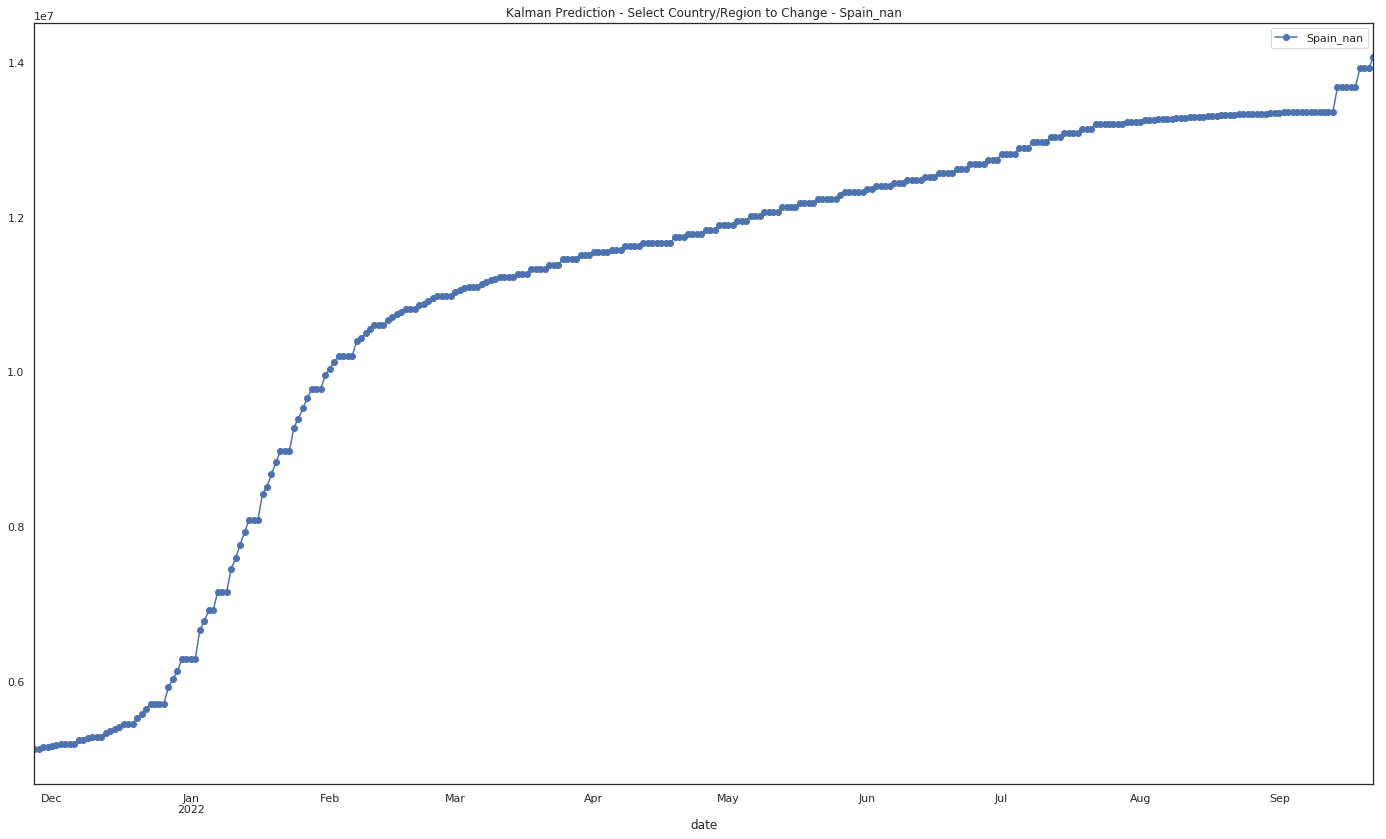

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


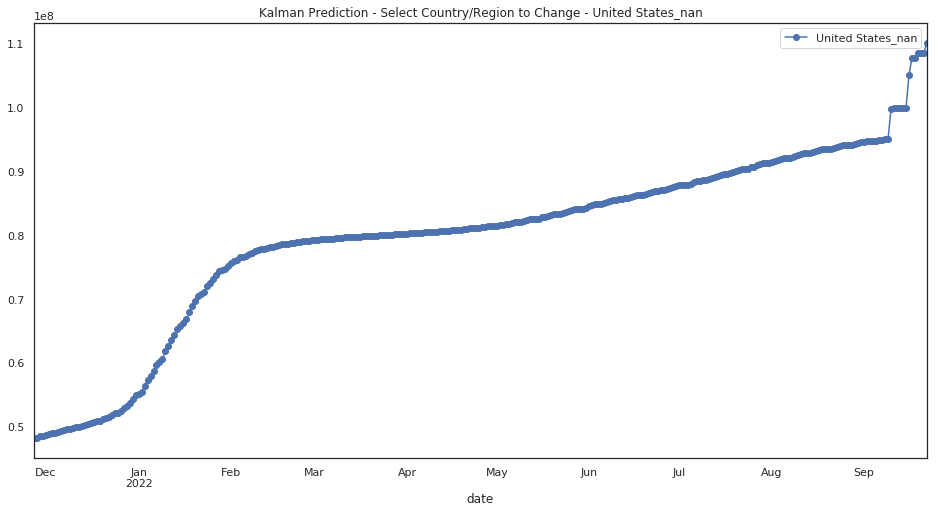

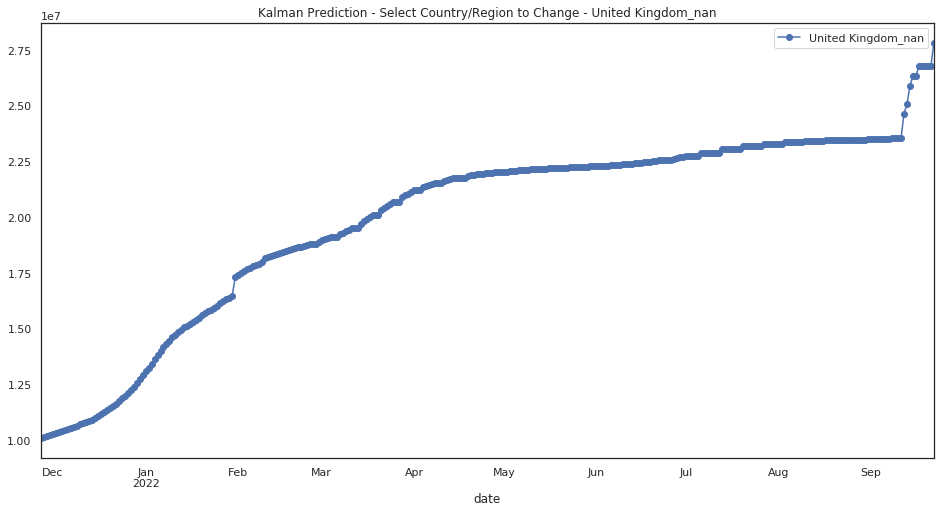

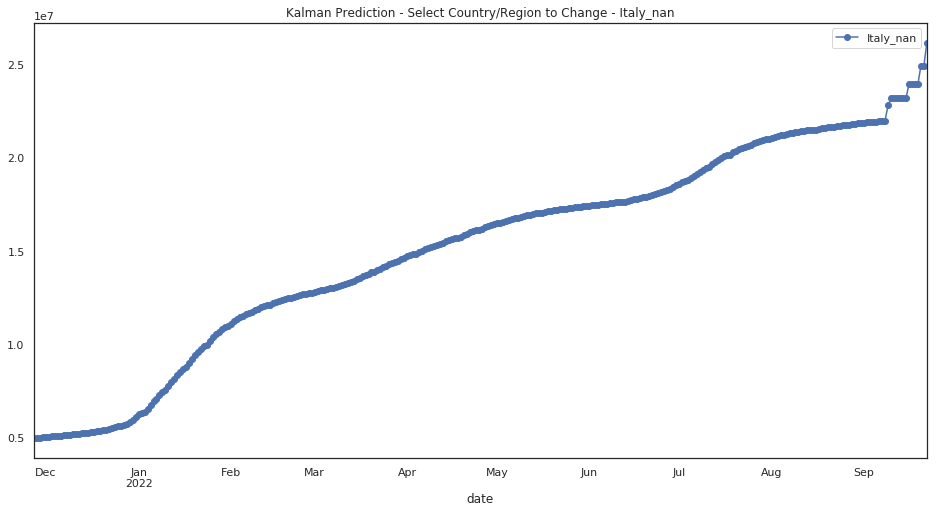

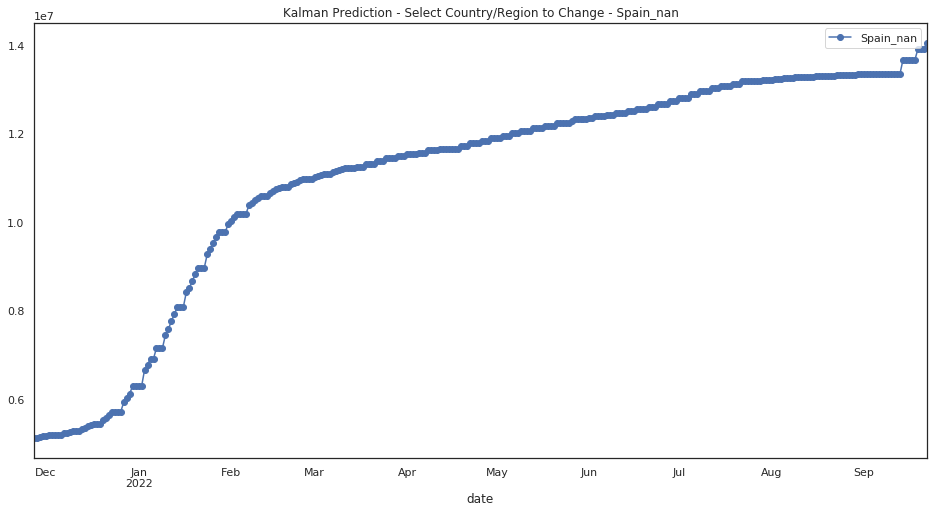

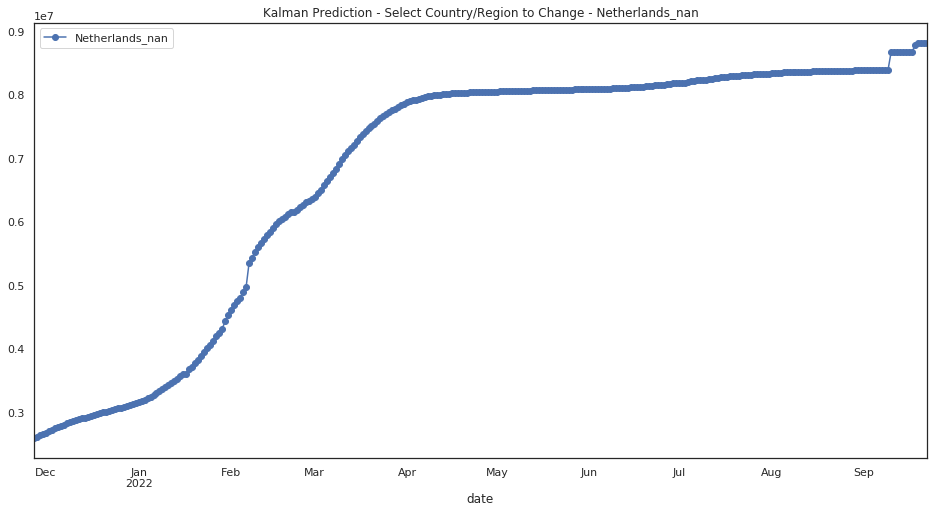

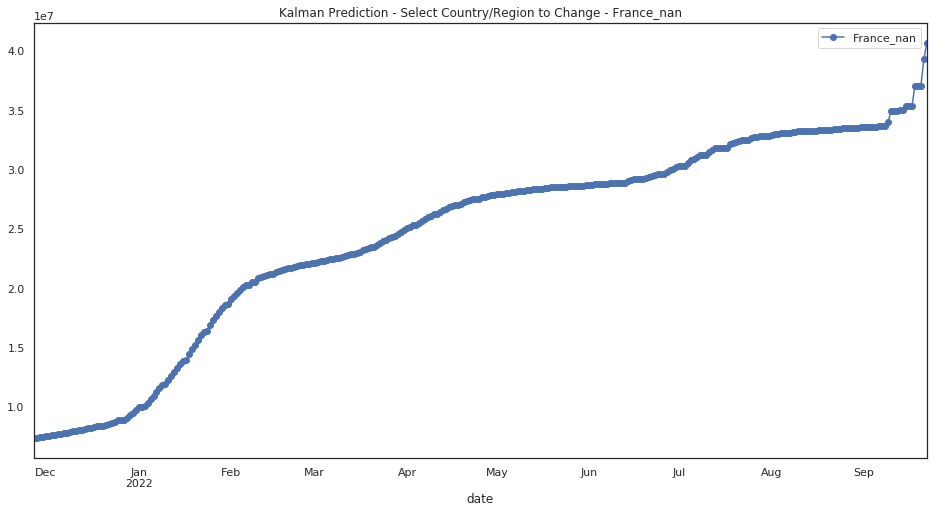

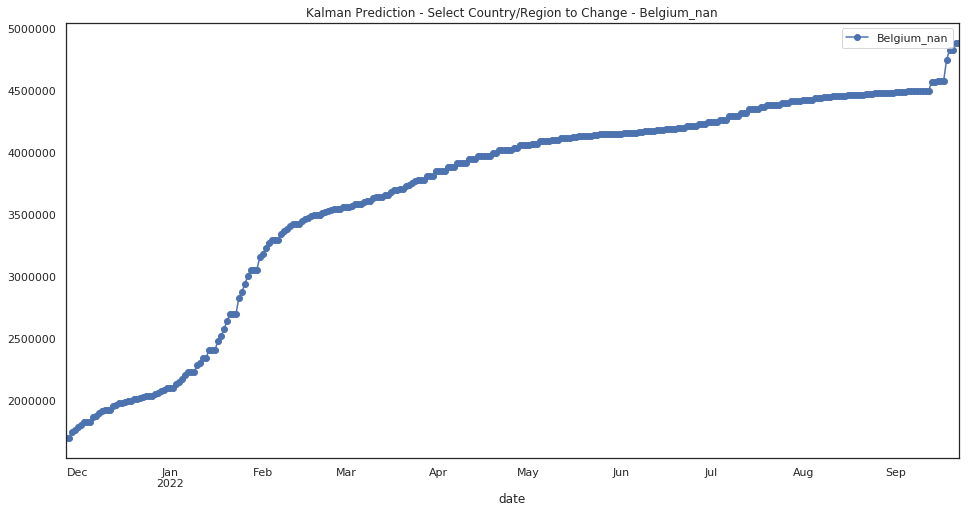

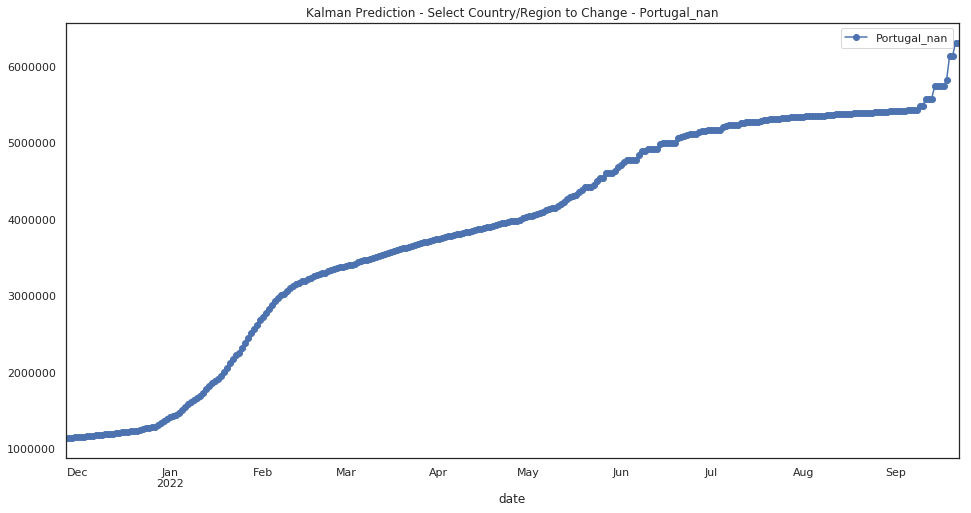

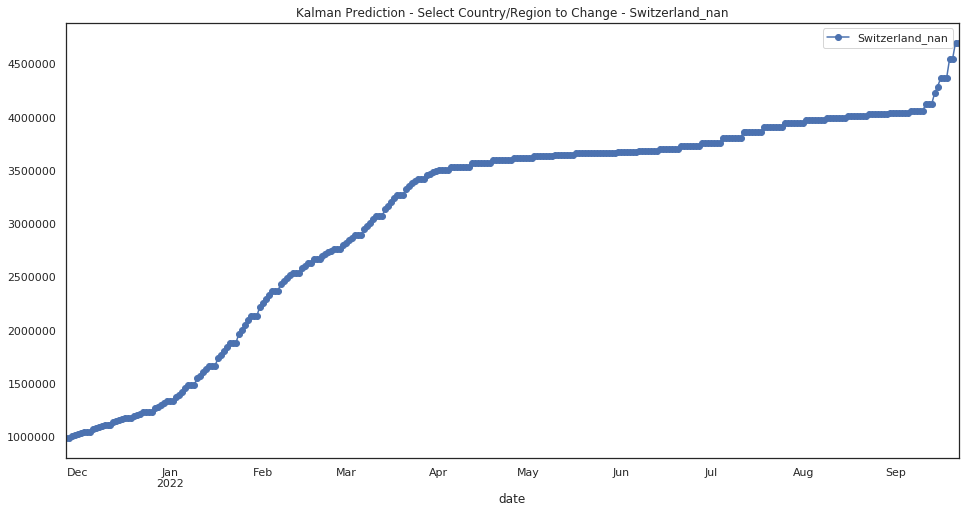

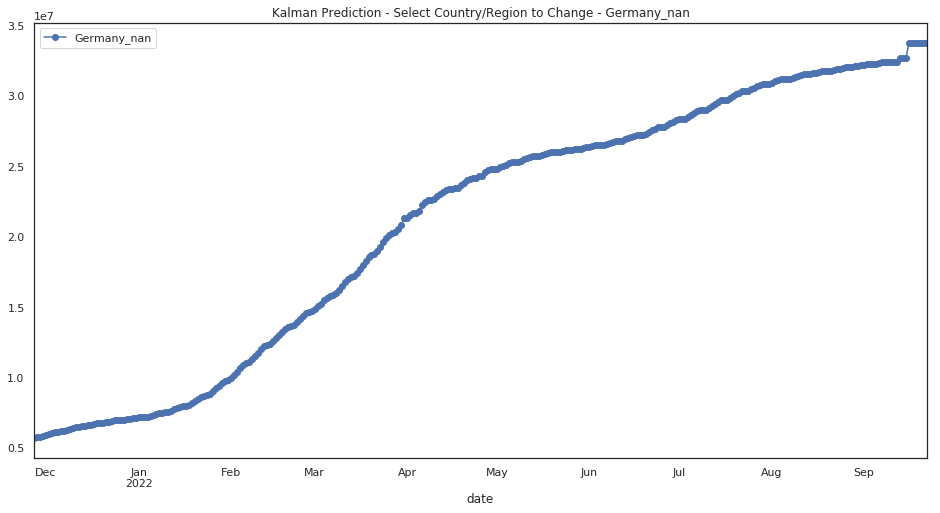

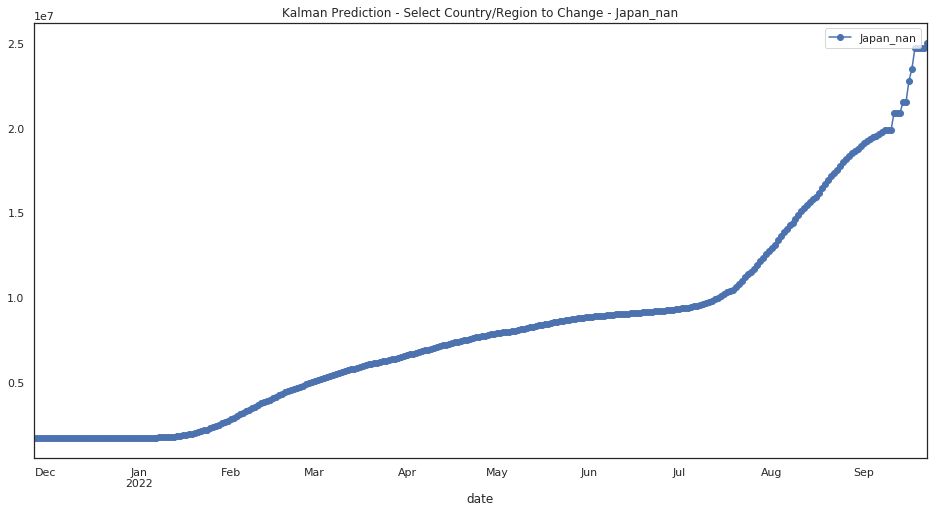

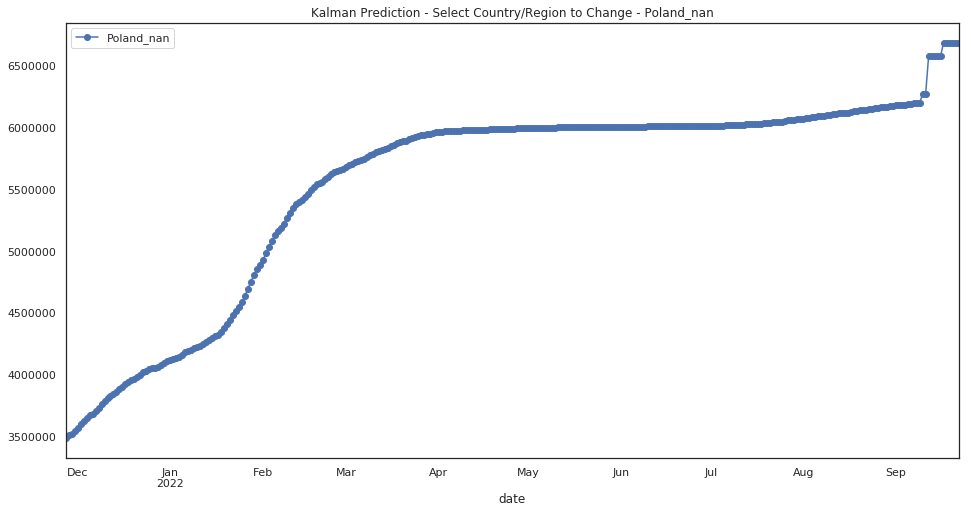

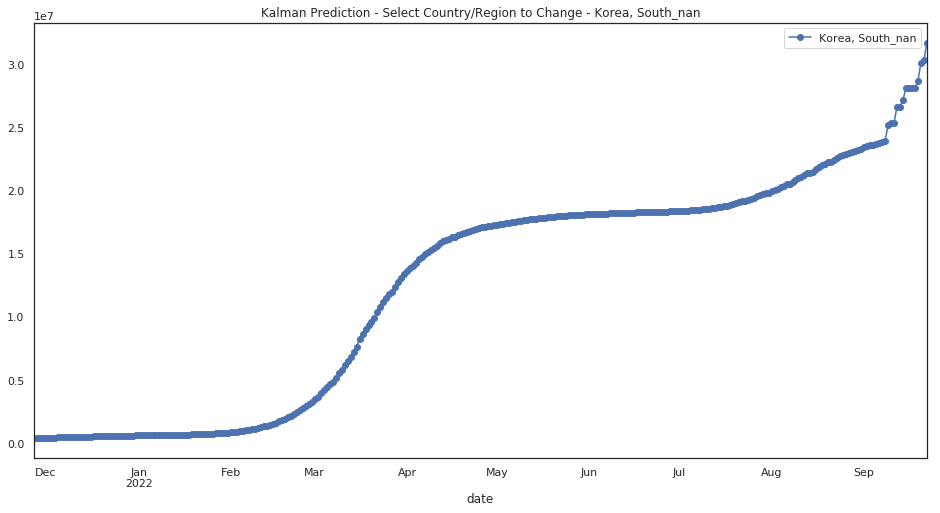

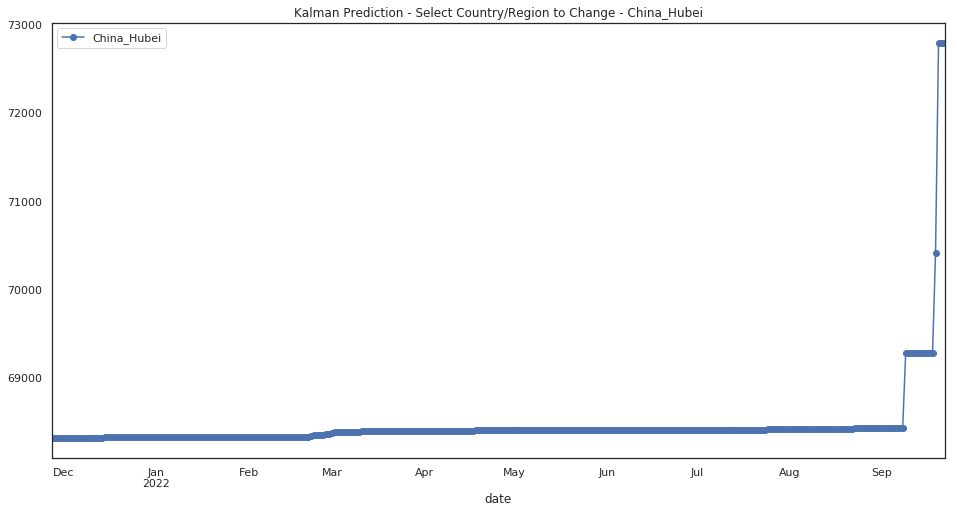

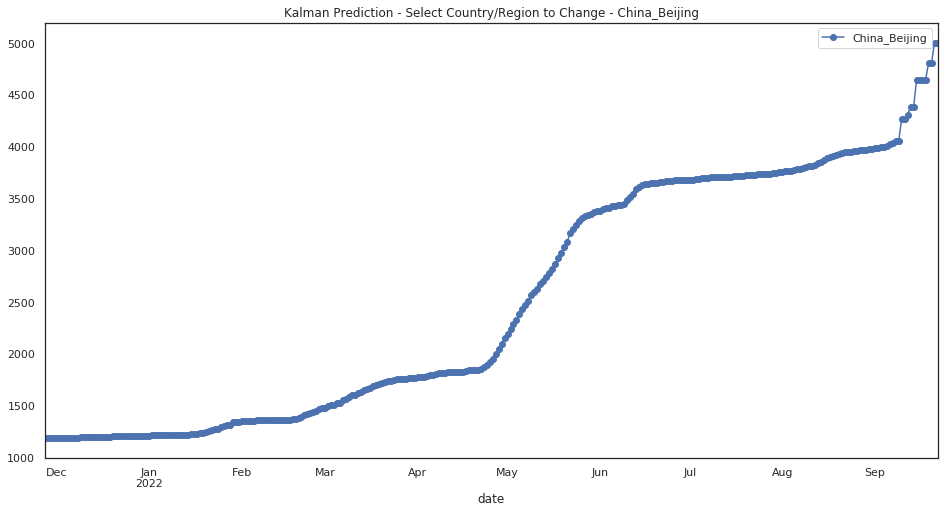

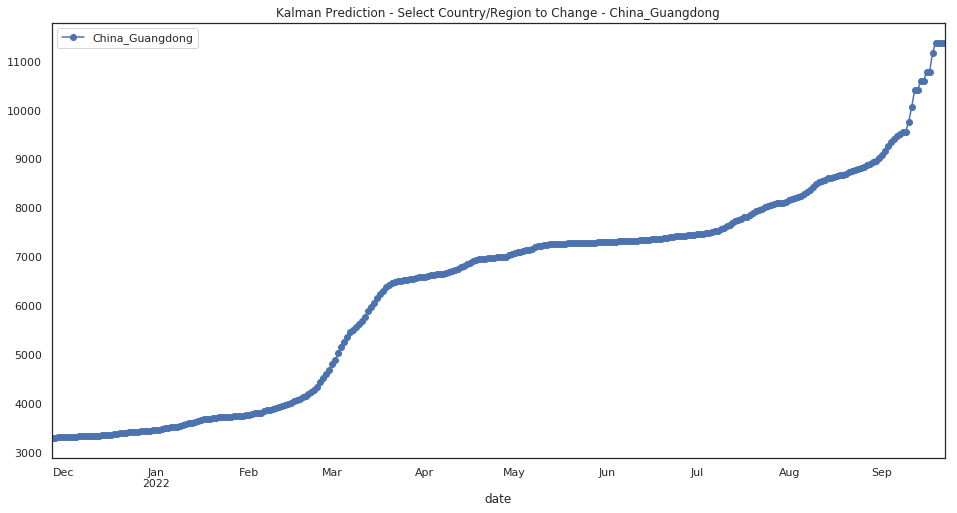

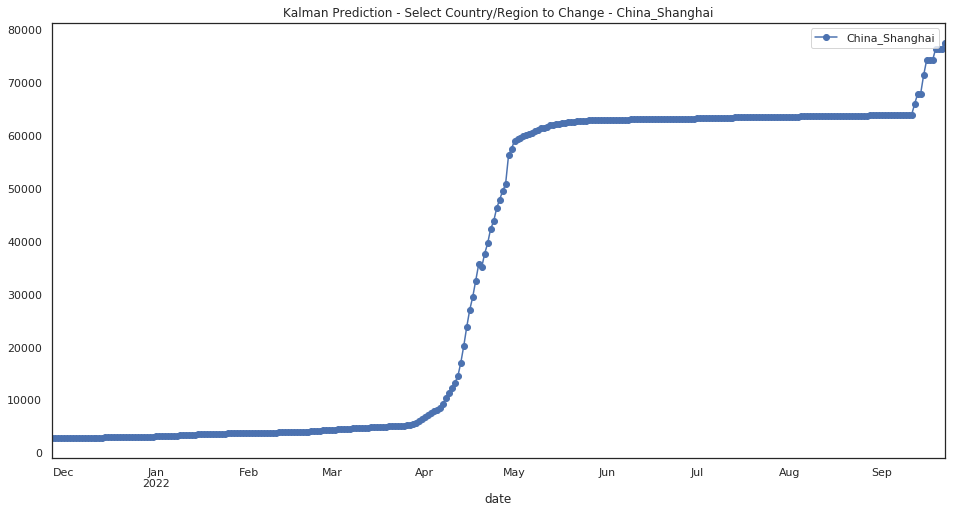

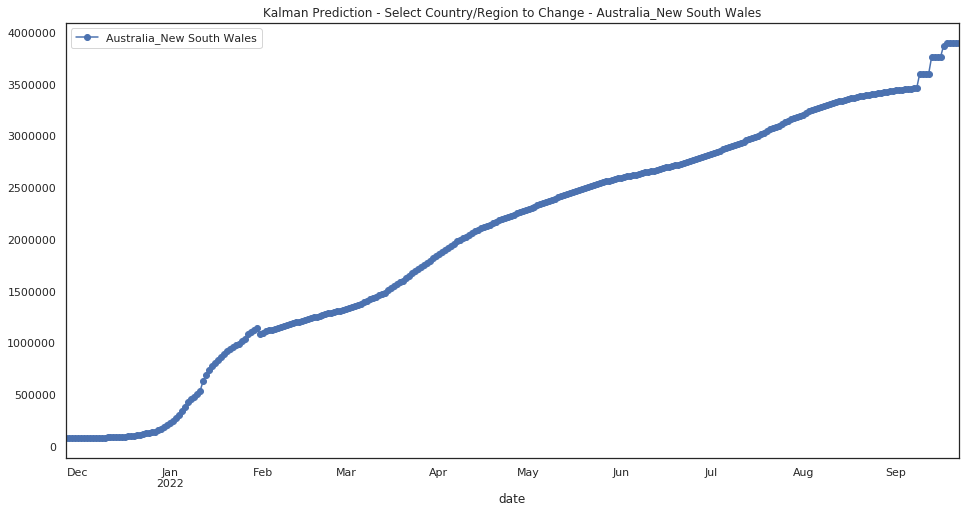

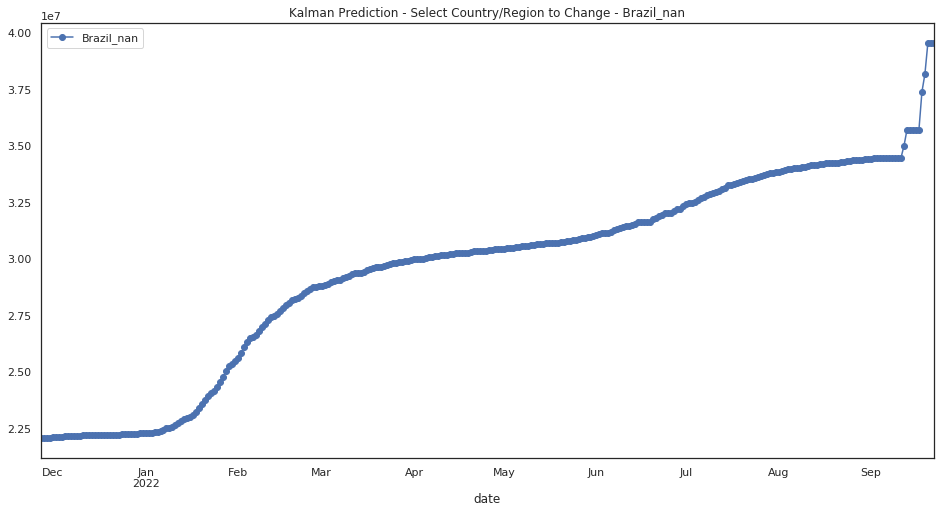

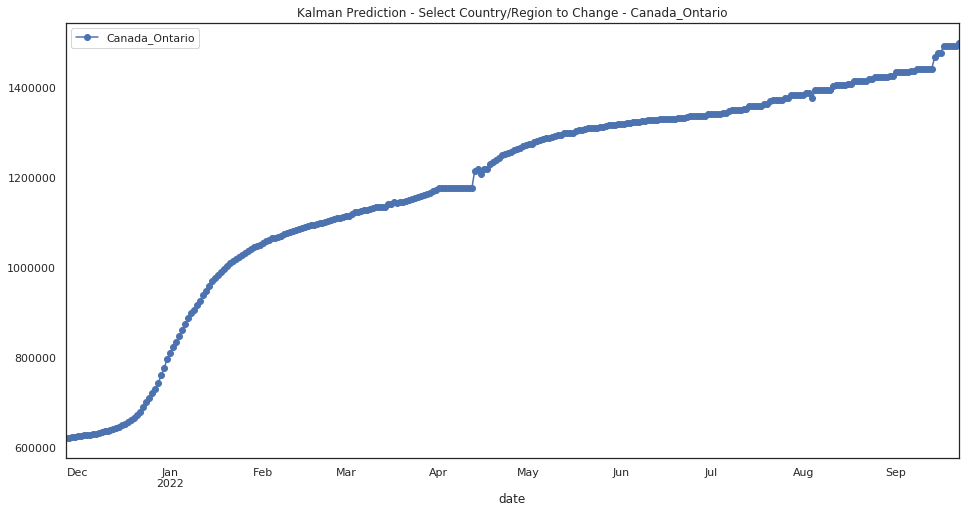

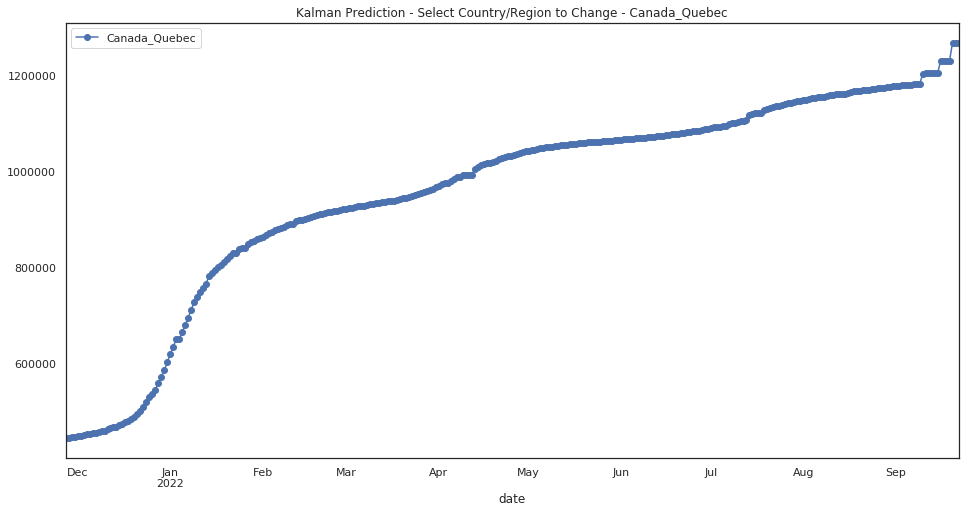

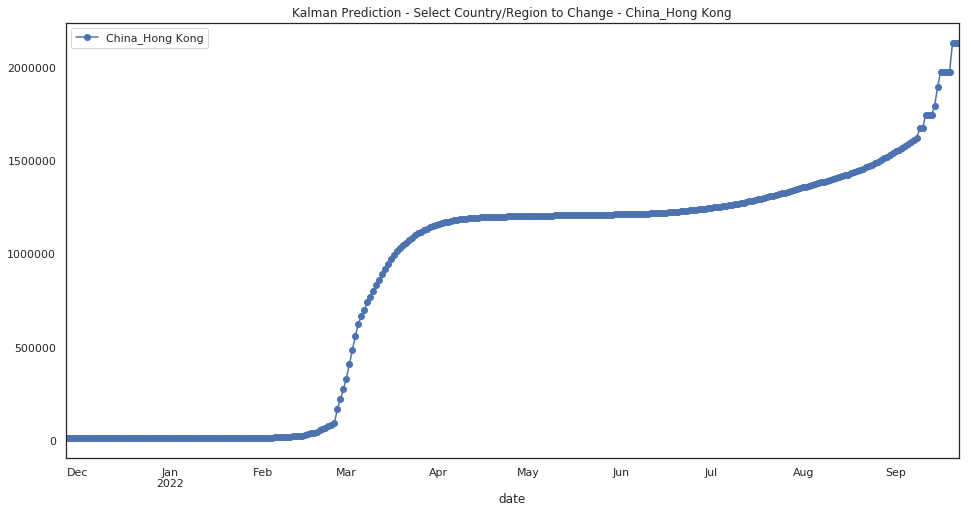

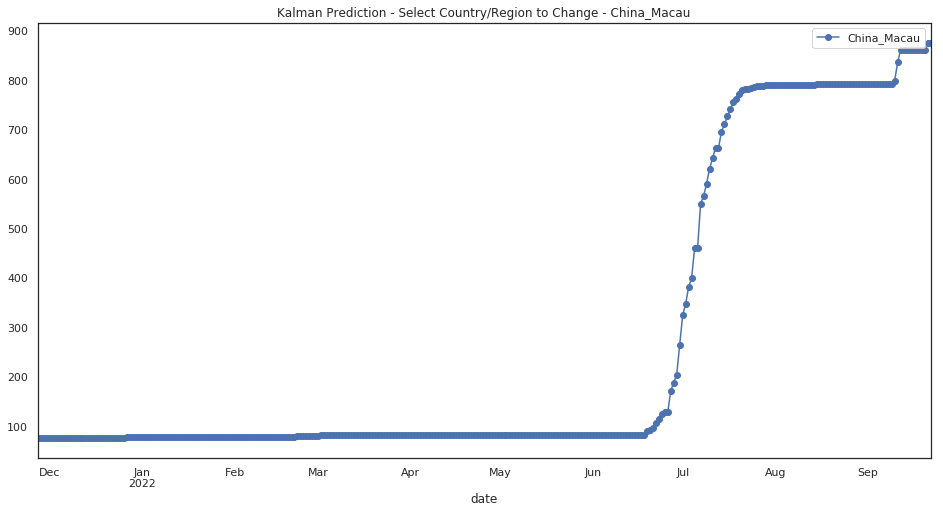

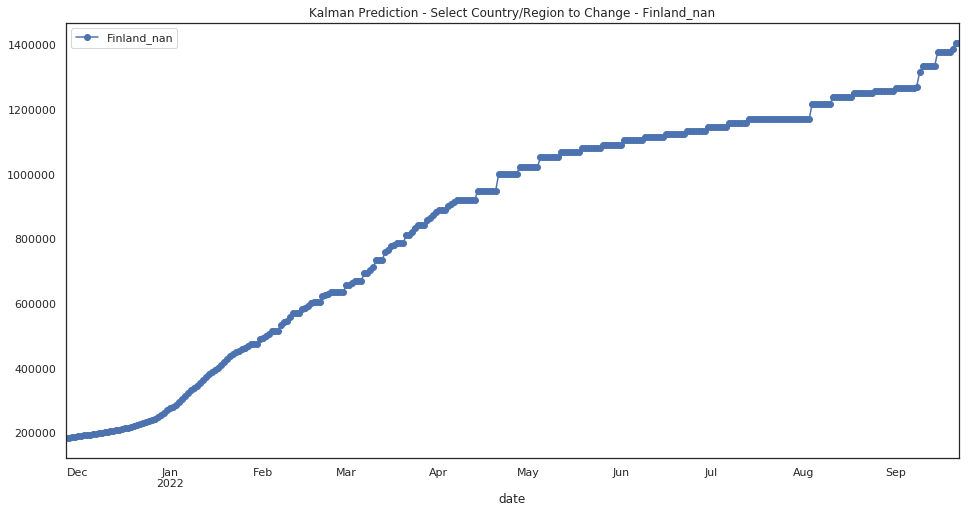

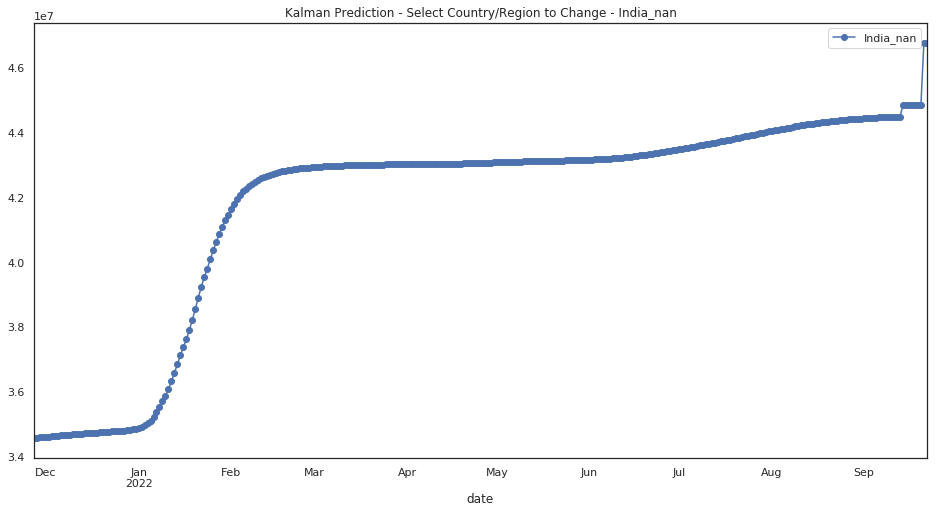

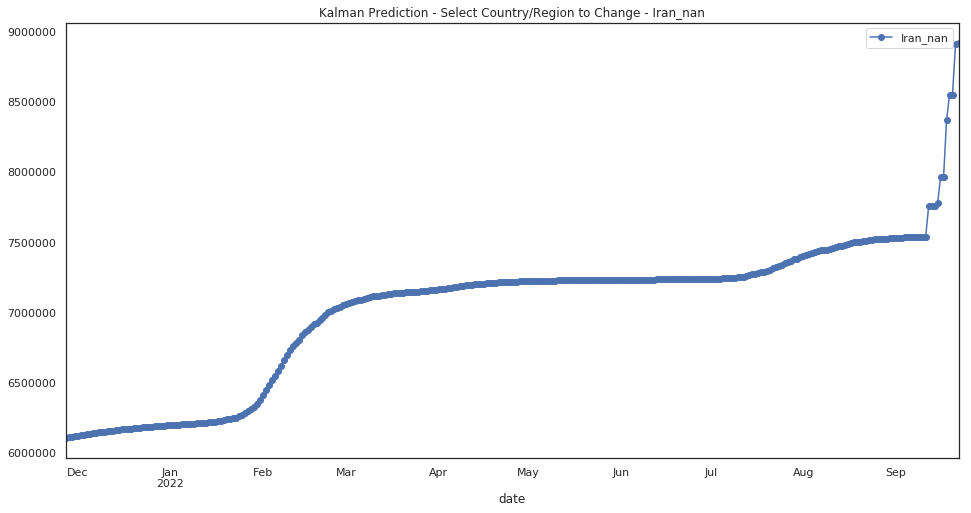

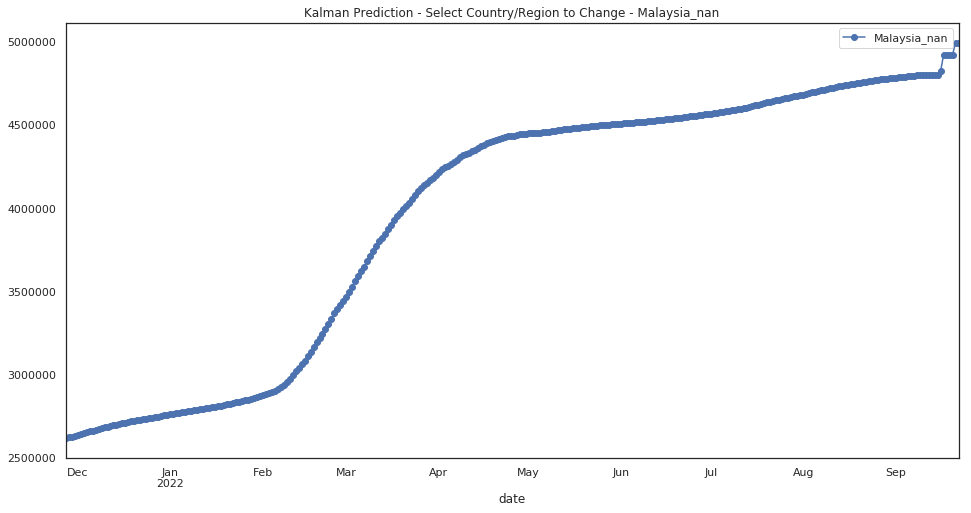

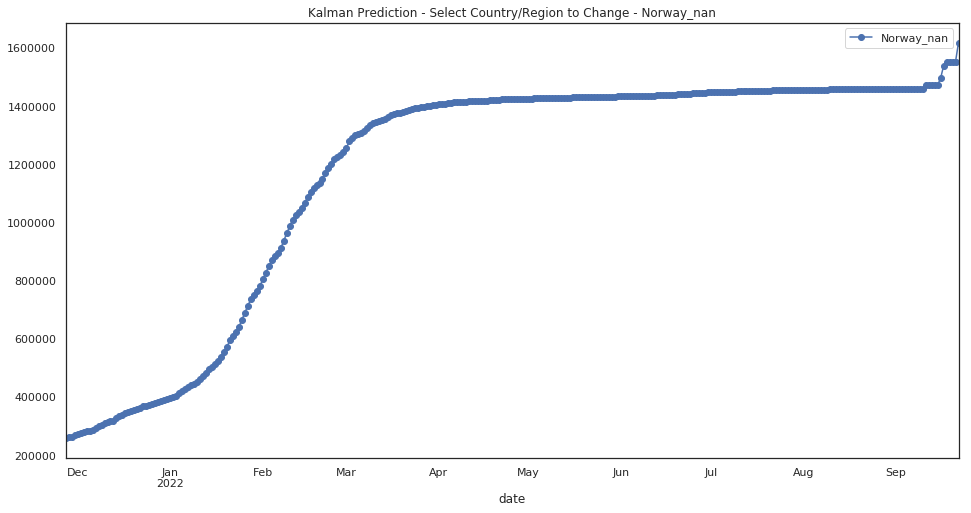

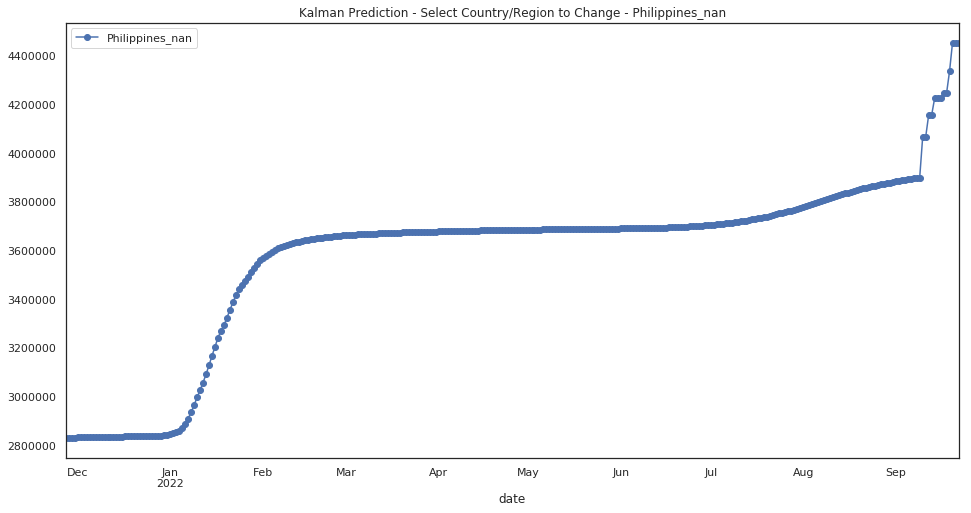

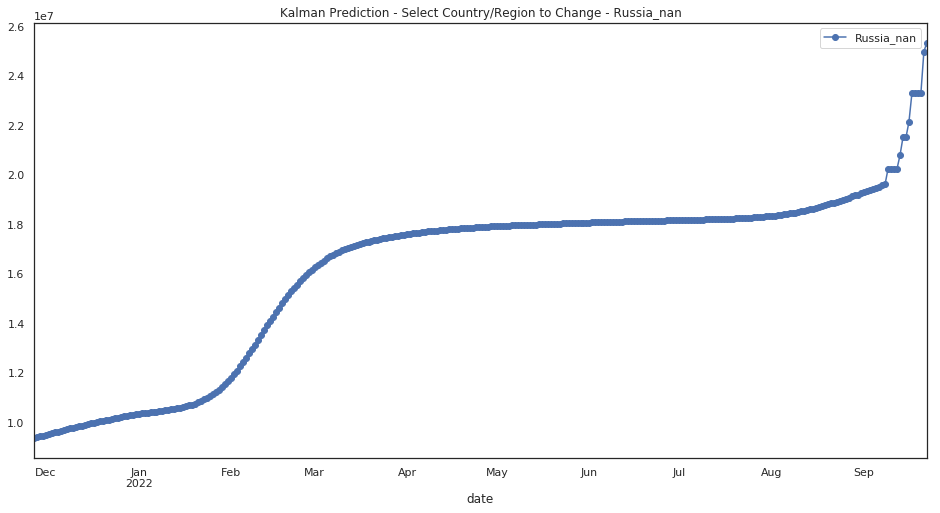

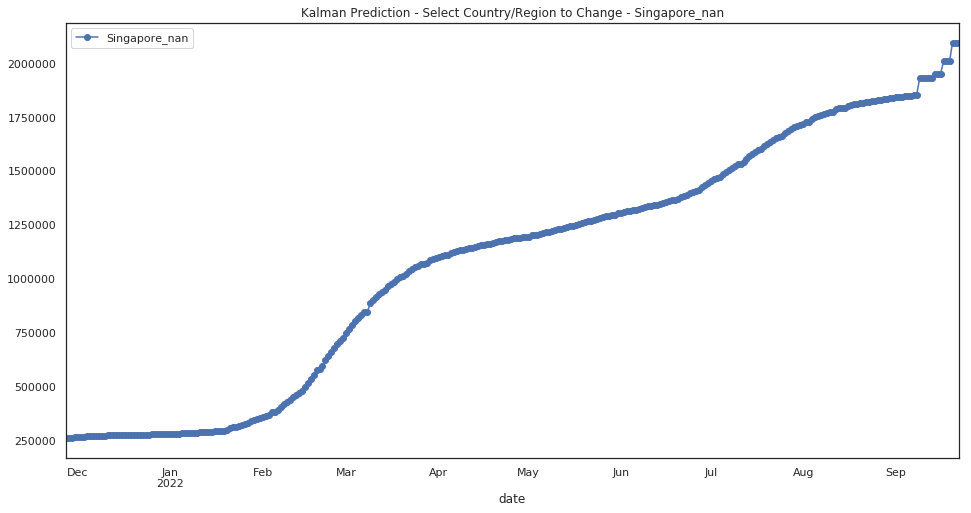

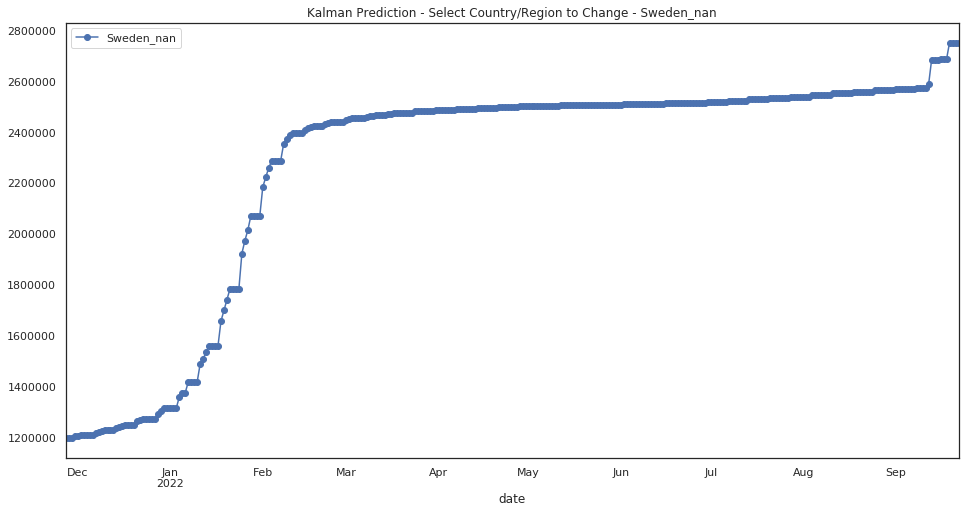

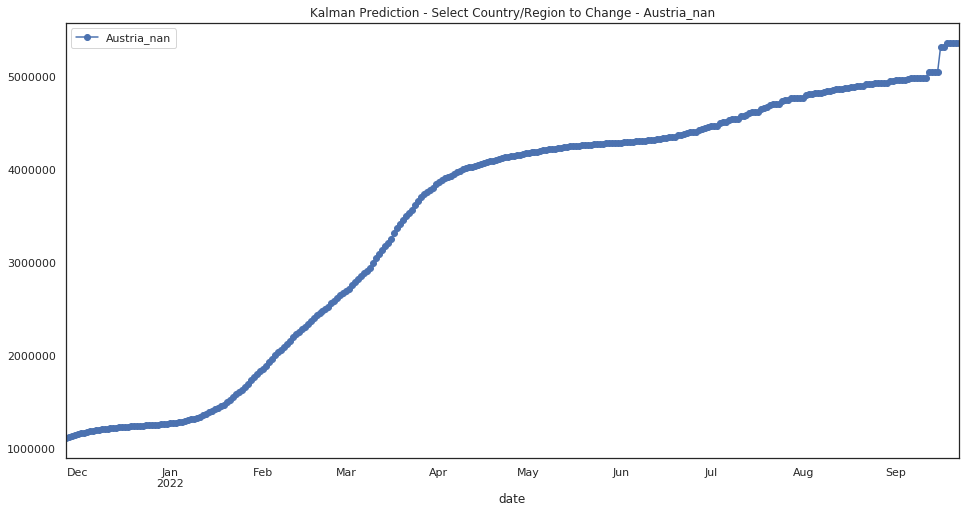

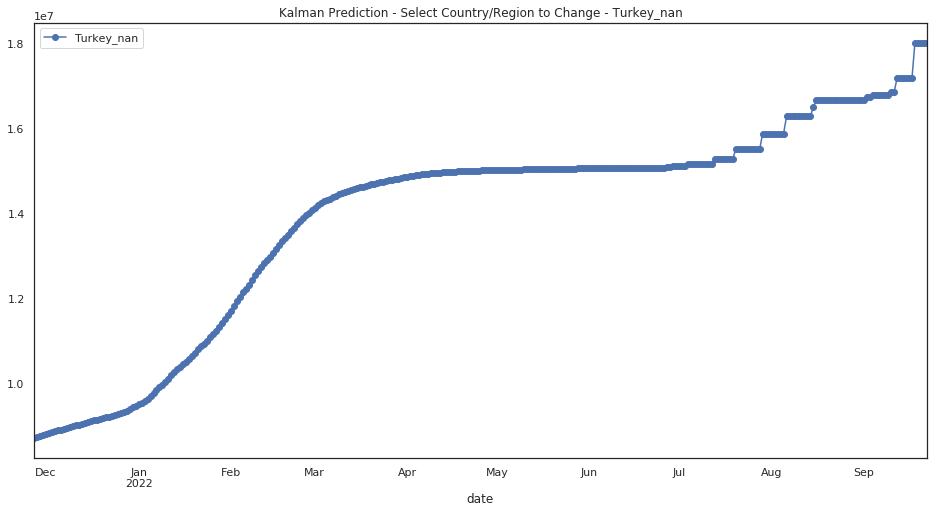

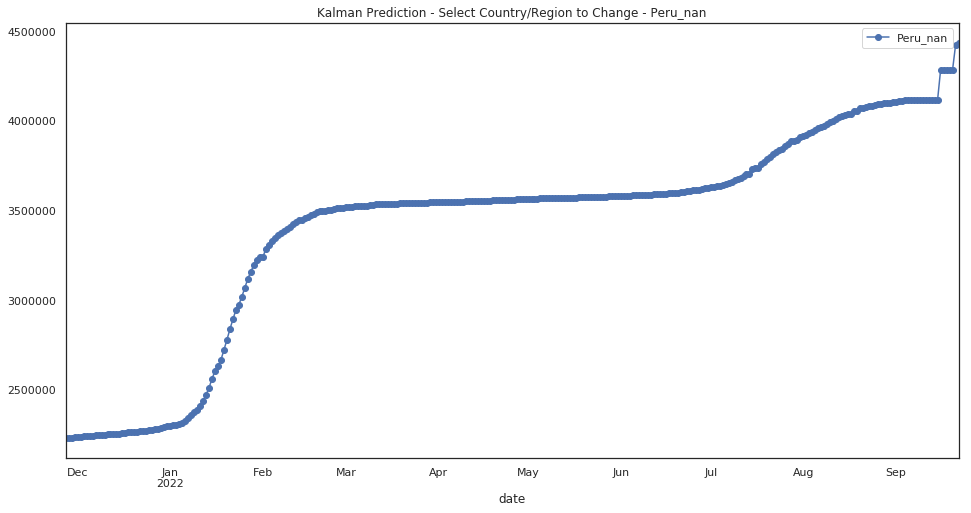

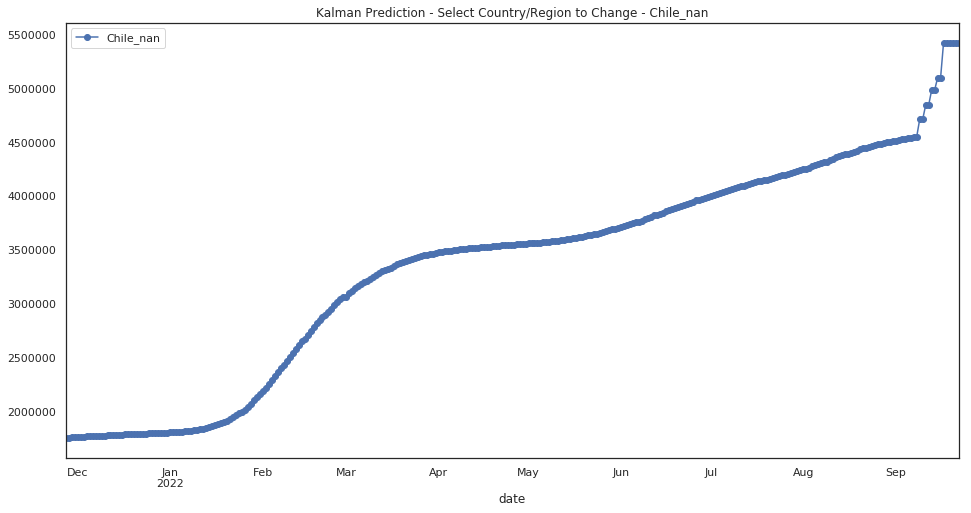

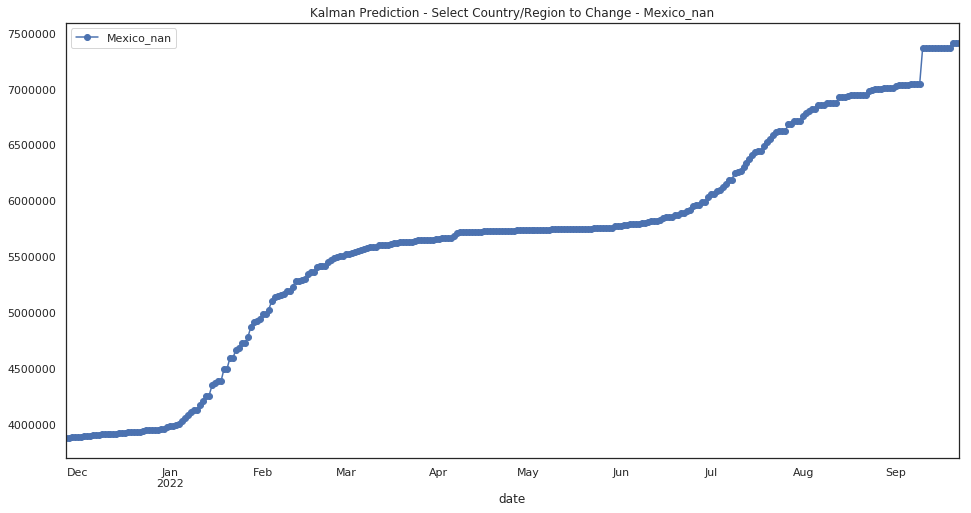

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-09-22 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN     110185732.0
India_nan                                           NaN      46782110.0
France_nan                                          NaN      40709253.0
Brazil_nan                                          NaN      39569038.0
Germany_nan                                         NaN      33793746.0
Korea, South_nan                                    NaN      31706933.0
United Kingdom_nan                                  NaN      27841551.0
Italy_nan                                           NaN      26180273.0
Russia_nan                                          NaN      25336259.0
Japan_nan                                           NaN      25047370.0
Turkey_nan                                          NaN      18034638.0
Vietnam_nan                                         NaN      15163900.0
Spain_nan                                           NaN      14061879.0
Argentina_nan                                       NaN      10883414.0
Iran_nan                                            NaN       8921540.0
Netherlands_nan                                     NaN       8820106.0
Colombia_nan                                        NaN       7878102.0
Mexico_nan                                          NaN       7416425.0
Indonesia_nan                                       NaN       6981157.0
Taiwan*_nan                                         NaN       6724728.0
Poland_nan                                          NaN       6689211.0
Ukraine_nan                                         NaN       6481889.0
Portugal_nan                                        NaN       6315656.0
Israel_nan                                          NaN       5897433.0
Greece_nan                                          NaN       5861670.0
South Africa_nan                                    NaN       5791925.0
Chile_nan                                           NaN       5423476.0
Thailand_nan                                        NaN       5410856.0
Austria_nan                                         NaN       5364812.0
Malaysia_nan                                        NaN       4995257.0
...                                                 ...             ...
China_Jiangsu                                       NaN          2395.0
China_Tianjin                                       NaN          2314.0
China_Liaoning                                      NaN          2205.0
United Kingdom_Falkland Islands (Malvinas)          NaN          2166.0
China_Hunan                                         NaN          1868.0
China_Anhui                                         NaN          1800.0
China_Tibet                                         NaN          1723.0
China_Jiangxi                                       NaN          1651.0
United Kingdom_Montserrat                           NaN          1567.0
China_Gansu                                         NaN          1554.0
China_Xinjiang                                      NaN          1258.0
China_Chongqing                                     NaN          1144.0
Summer Olympics 2020_nan                            NaN           937.0
France_Wallis and Futuna                            NaN           920.0
China_Macau                                         NaN           876.0
Diamond Princess_nan                                NaN           752.0
Winter Olympics 2022_nan                            NaN           703.0
China_Shanxi                                        NaN           576.0
China_Qinghai                                       NaN           282.0
China_Guizhou                                       NaN           217.0
China_Ningxia                                       NaN           129.0
Holy See_nan                                        NaN            35.0
Canada_Grand Princess                               NaN            15.0
Antarctica_nan                                      NaN            15.0
Canada_Repatriated Tra

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-11-27         274706.0     310600.0     319878.0     154502.0   
2021-11-28         274730.0     310957.0     320025.0     154502.0   
2021-11-29         157218.0     199555.0     210152.0      16712.0   
2021-11-30         157260.0     199750.0     210344.0      16712.0   
2021-12-01         157799.0     200233.0     211142.0      17115.0   
2021-12-02         157823.0     200654.0     211340.0      17426.0   
2021-12-03         157861.0     201053.0     211532.0      17658.0   
2021-12-04         157881.0     201430.0     211718.0      18010.0   
2021-12-05         159468.0     203223.0     213396.0      19173.0   
2021-12-06         159508.0     203420.0     213586.0      19565.0   
2021-12-07         159516.0     203790.0     213781.0      18631.0   
2021-12-08         159558.0     204111.0     213970.0      18815.0   
2021-12-09         159595.0     204349.0     214150.0      20422.0   
2021-12-10         159613.0     204709.0     214357.0      19272.0   
2021-12-11         159631.0     205013.0     214571.0      19440.0   
2021-12-12         159653.0     205288.0     214769.0      20490.0   
2021-12-13         159664.0     205453.0     214977.0      20240.0   
2021-12-14         159680.0     205800.0     215203.0      20729.0   
2021-12-15         159687.0     206115.0     215443.0      20136.0   
2021-12-16         159742.0     206426.0     215657.0      21507.0   
2021-12-17         159743.0     206726.0     215944.0      20549.0   
2021-12-18         159769.0     207047.0     216224.0      21374.0   
2021-12-19         159806.0     207285.0     216488.0      21374.0   
2021-12-20         159810.0     207428.0     216733.0      21604.0   
2021-12-21         159837.0     207771.0     217031.0      21062.0   
2021-12-22         159859.0     208099.0     217312.0      22154.0   
2021-12-23         159890.0     208427.0     217604.0      21372.0   
2021-12-24         159902.0     208724.0     217964.0      21571.0   
2021-12-25         159918.0     209040.0     218250.0      21730.0   
2021-12-26         159967.0     209226.0     218518.0      22427.0   
...                     ...          ...          ...          ...   
2022-08-25         193818.0     328818.0     272070.0      46027.0   
2022-08-26         193862.0     329174.0     272118.0      46027.0   
2022-08-27         193920.0     329569.0     272153.0      46027.0   
2022-08-28         194342.0     329806.0     272174.0      46027.0   
2022-08-29         194714.0     329867.0     272213.0      46027.0   
2022-08-30         194883.0     330225.0     272255.0      46027.0   
2022-08-31         195163.0     330661.0     272290.0      46027.0   
2022-09-01         195406.0     330920.0     272344.0      46027.0   
2022-09-02         195442.0     331164.0     272393.0      46027.0   
2022-09-03         195809.0     331371.0     272417.0      46027.0   
2022-09-04         196013.0     331509.0     272433.0      46027.0   
2022-09-05         196245.0     331542.0     272450.0      46027.0   
2022-09-06         196522.0     331578.0     272466.0      46027.0   
2022-09-07         196878.0     331813.0     272480.0      46027.0   
2022-09-08         197160.0     332033.0     272498.0      46113.0   
2022-09-09         204892.0     334573.0     272503.0      46113.0   
2022-09-10         204945.0     346545.0     272504.0      47405.0   
2022-09-11         212225.0     349814.0     272505.0      47449.0   
2022-09-12         212493.0     347236.0     272506.0      47676.0   
2022-09-13         212805.0     347197.0     272507.0      48203.0   
2022-09-14         212819.0     347045.0     272508.0      49878.0   
2022-09-15         212609.0     347058.0     272508.0      49878.0   
2022-09-16         212625.0     362884.0     272509.0      51315.0   
2022-09-17         223860.0     368785.0     272509.0      52946.0   
2022-09-18

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'France_nan',
 'Brazil_nan',
 'Germany_nan',
 'Korea, South_nan',
 'United Kingdom_nan',
 'Italy_nan',
 'Russia_nan',
 'Japan_nan',
 'Turkey_nan',
 'Vietnam_nan',
 'Spain_nan',
 'Argentina_nan',
 'Iran_nan',
 'Netherlands_nan',
 'Colombia_nan',
 'Mexico_nan',
 'Indonesia_nan',
 'Taiwan*_nan',
 'Poland_nan',
 'Ukraine_nan',
 'Portugal_nan',
 'Israel_nan',
 'Greece_nan',
 'South Africa_nan',
 'Chile_nan',
 'Thailand_nan',
 'Austria_nan',
 'Malaysia_nan',
 'Belgium_nan',
 'Switzerland_nan',
 'Czechia_nan',
 'Philippines_nan',
 'Peru_nan',
 'Denmark_nan',
 'Romania_nan',
 'Australia_New South Wales',
 'Slovakia_nan',
 'Australia_Victoria',
 'Sweden_nan',
 'Iraq_nan',
 'Hungary_nan',
 'Serbia_nan',
 'Bangladesh_nan',
 'New Zealand_nan',
 'China_Hong Kong',
 'Singapore_nan',
 'Ireland_nan',
 'Georgia_nan',
 'Australia_Queensland',
 'Jordan_nan',
 'Bulgaria_nan',
 'Kazakhstan_nan',
 'Pakistan_nan',
 'Norway_nan',
 'Morocco_nan',
 'Slovenia_nan',
 'Canada_O

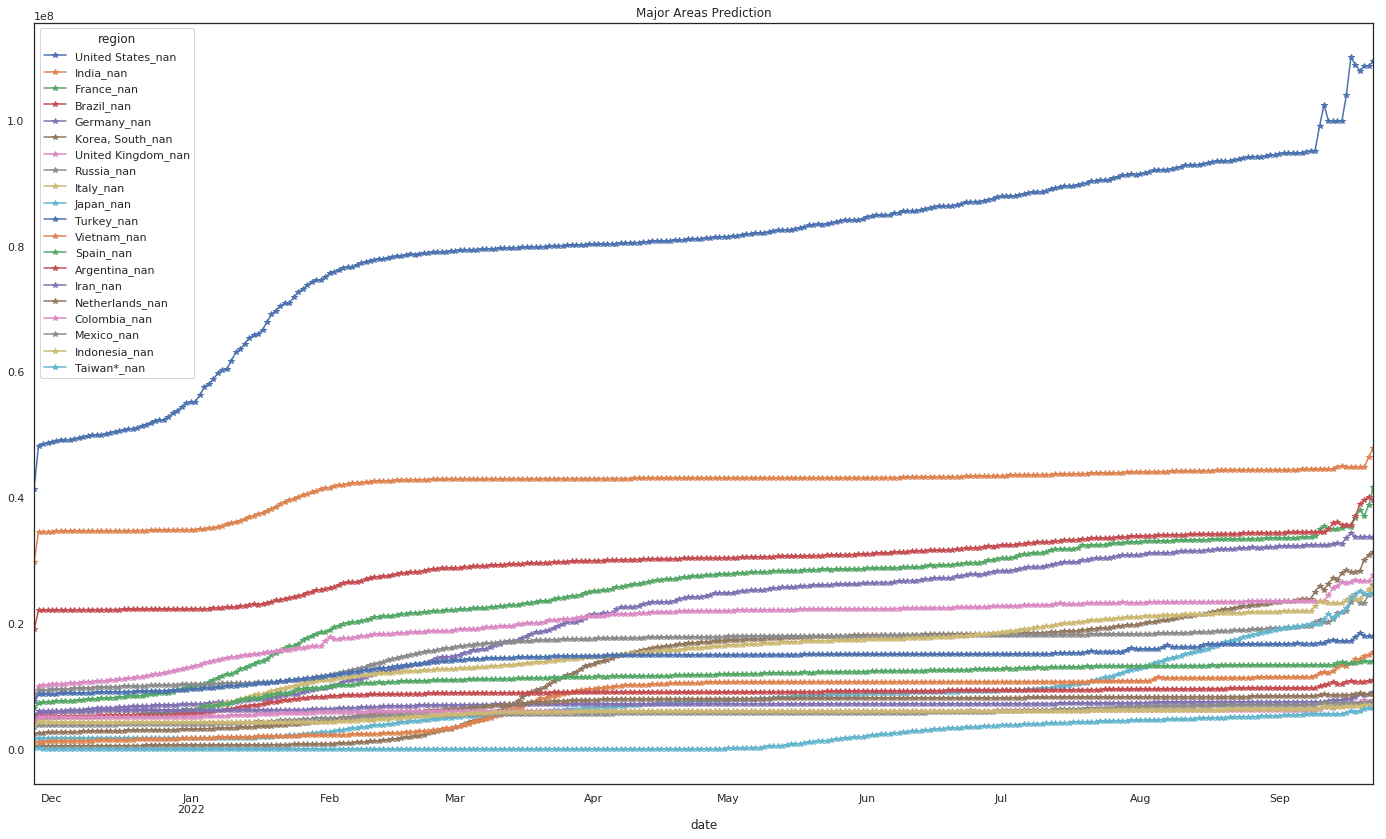

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

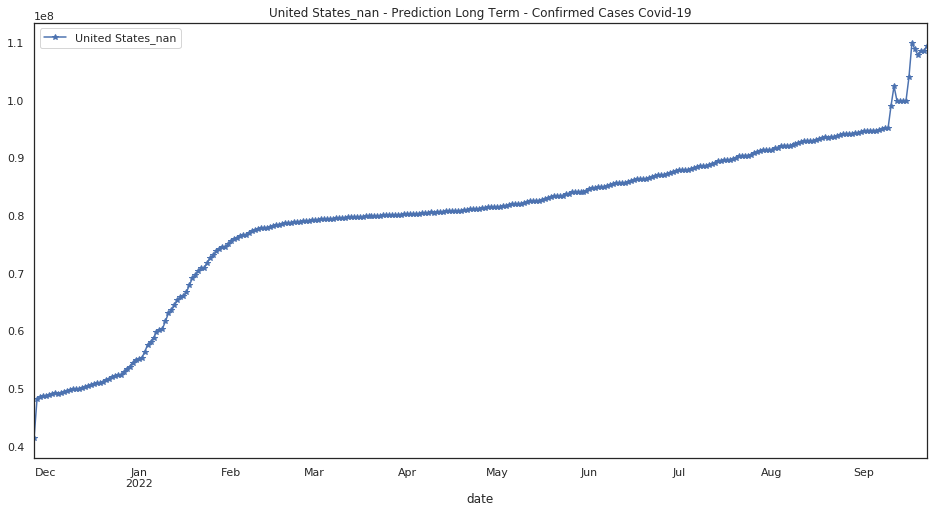

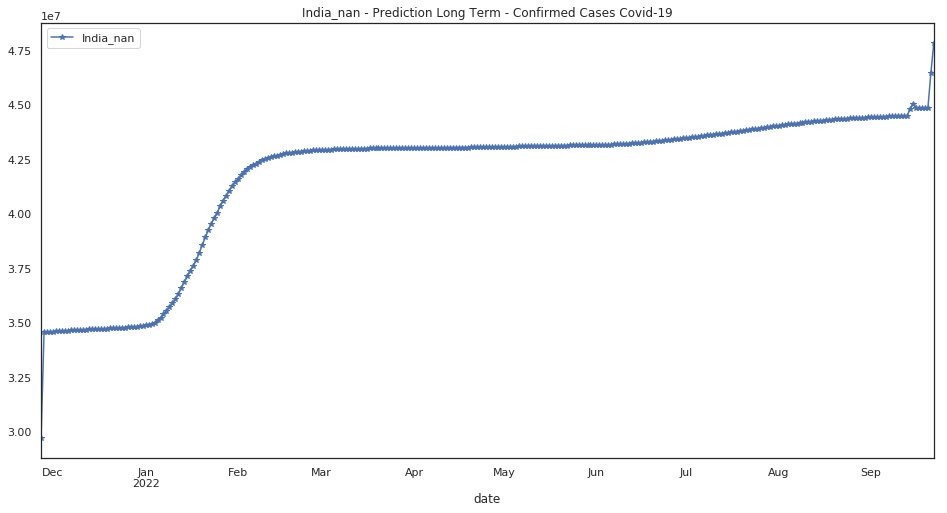

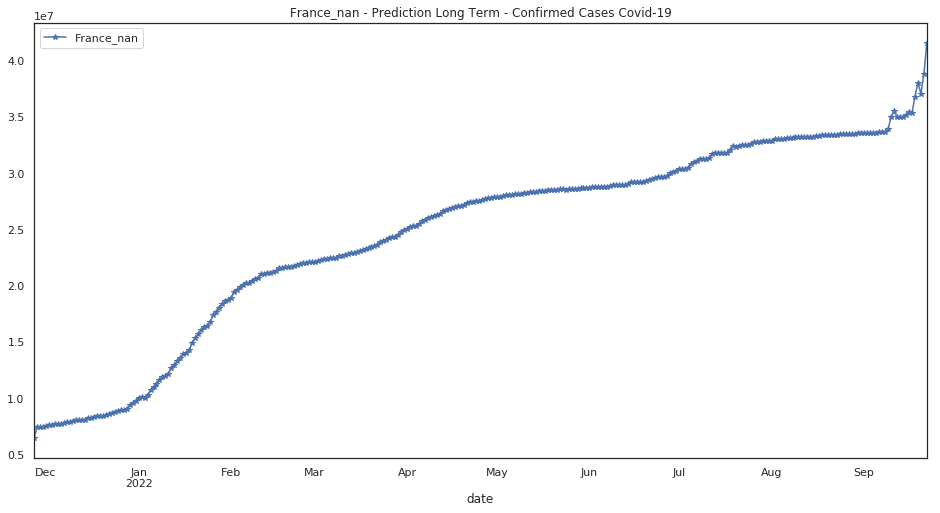

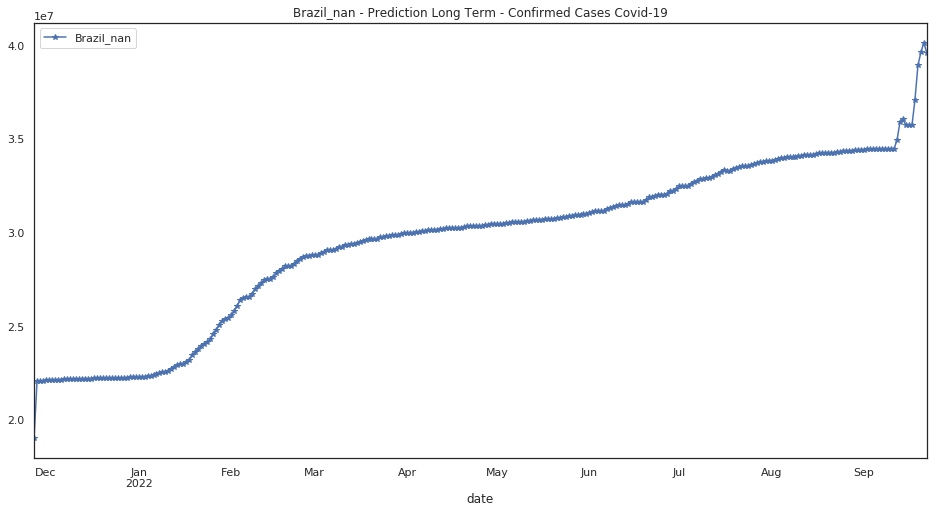

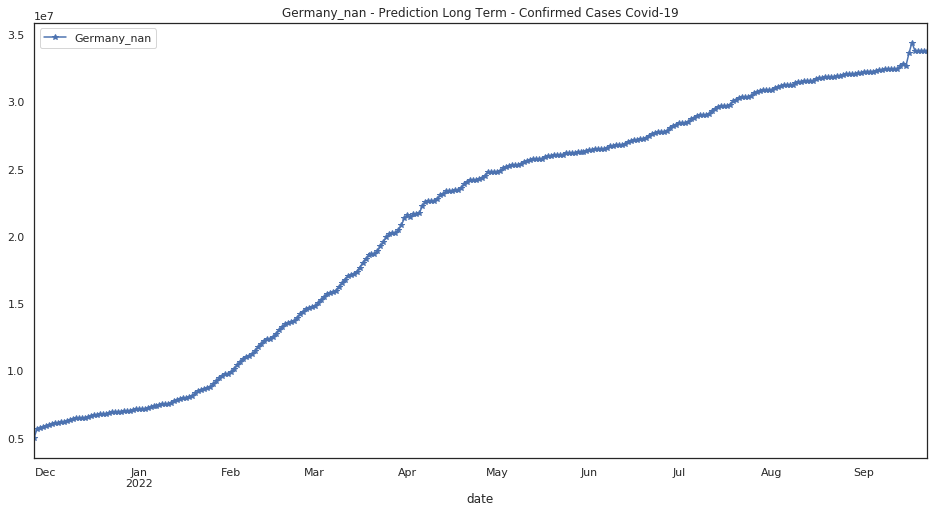

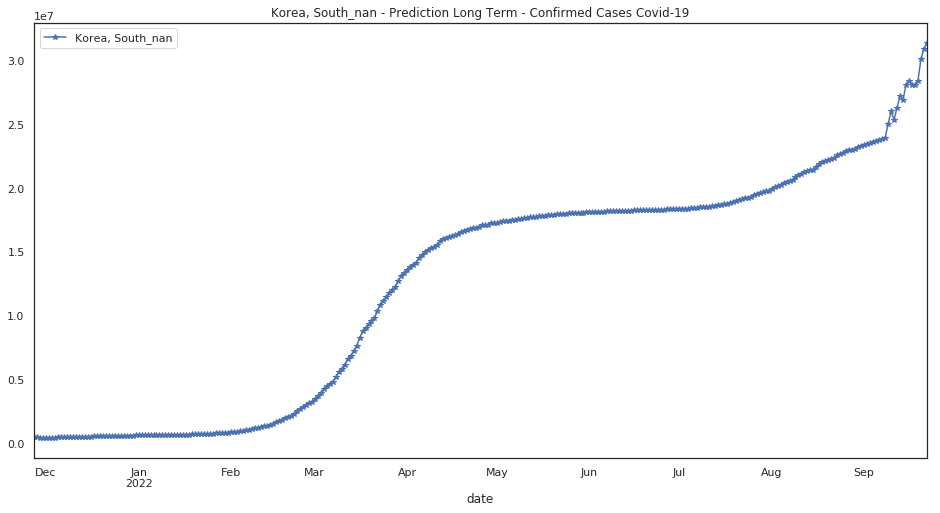

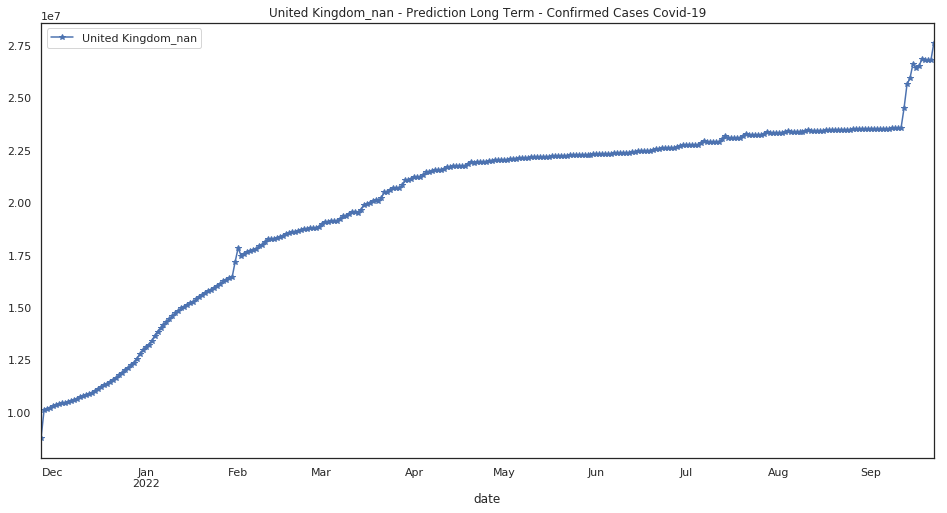

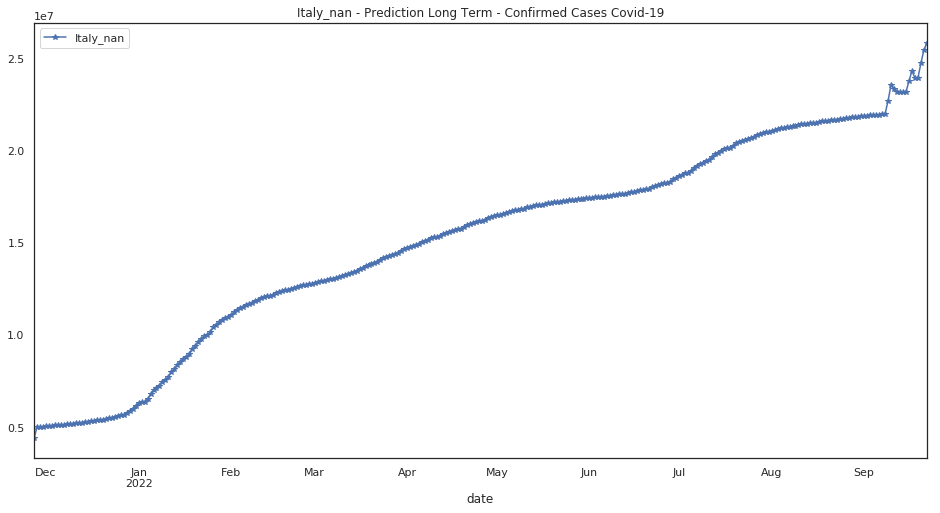

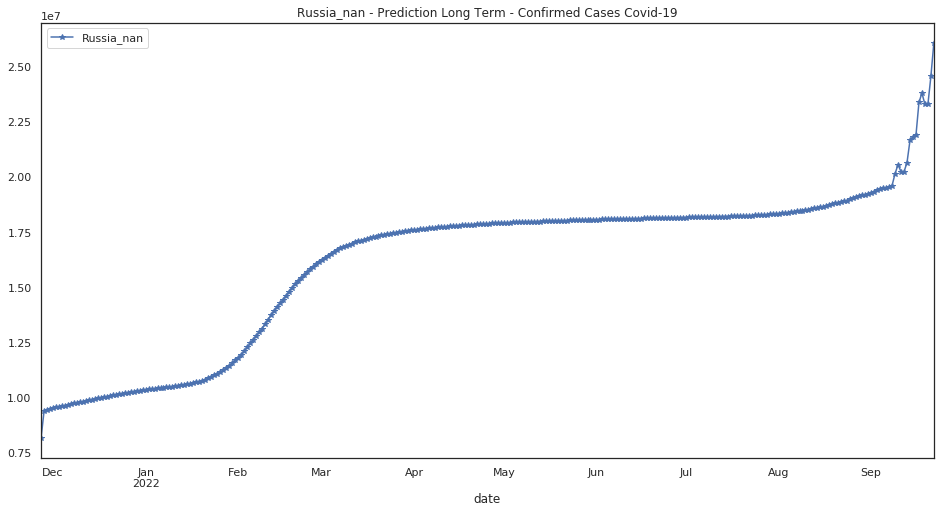

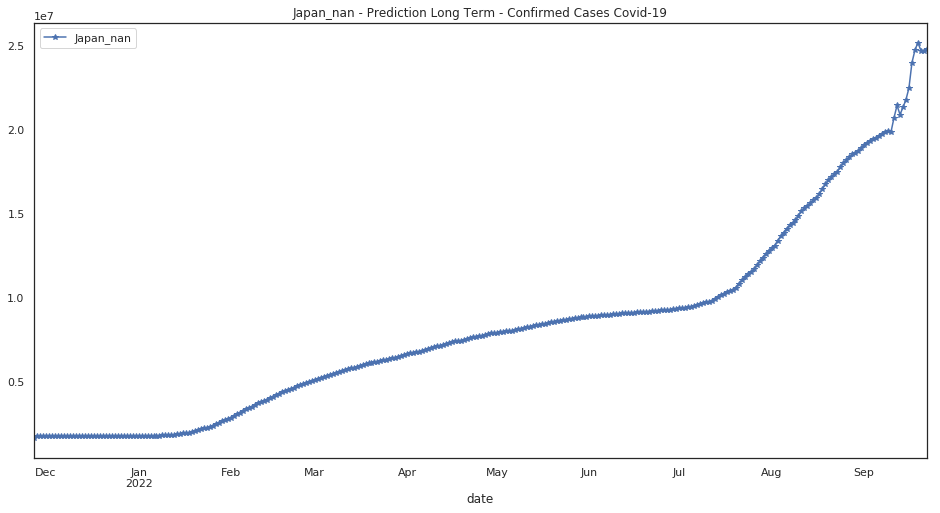

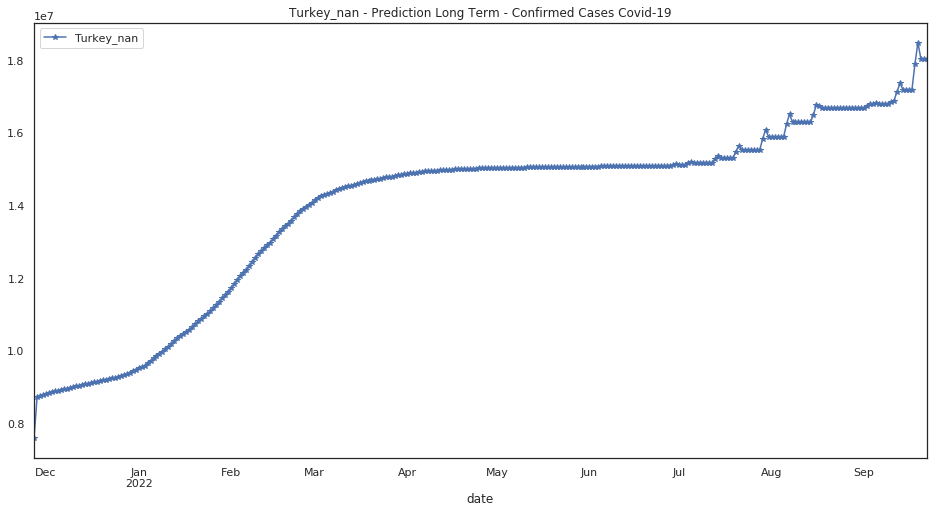

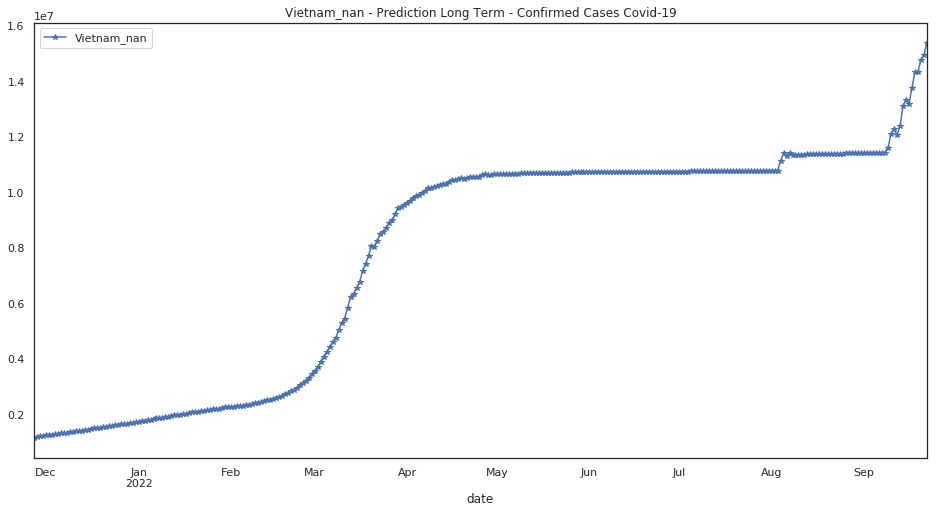

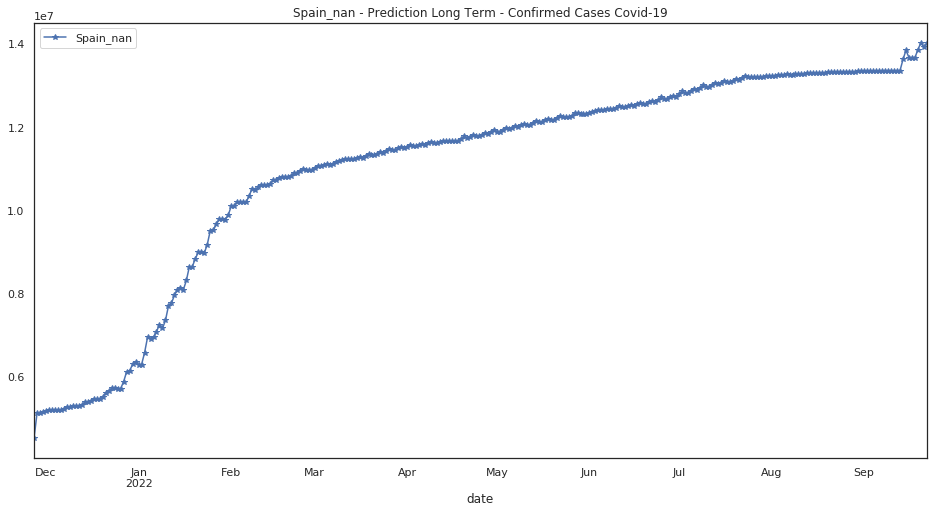

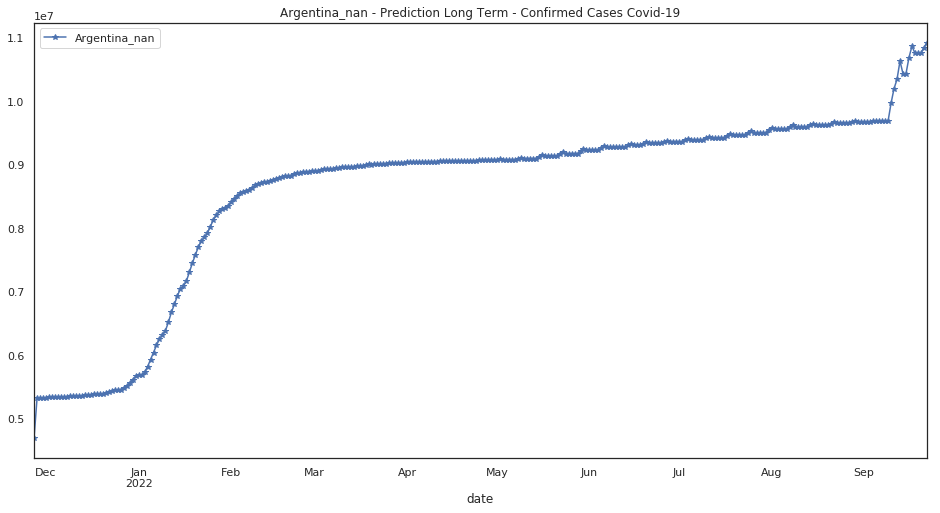

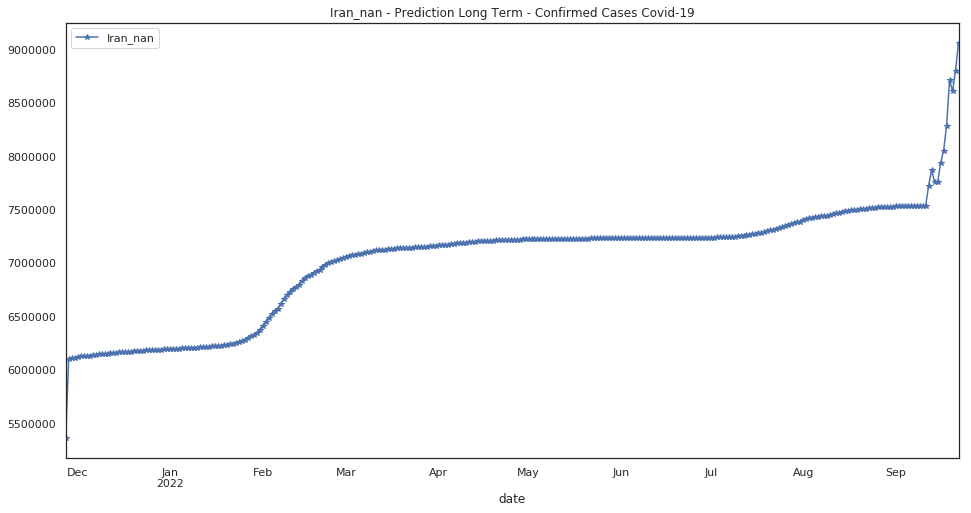

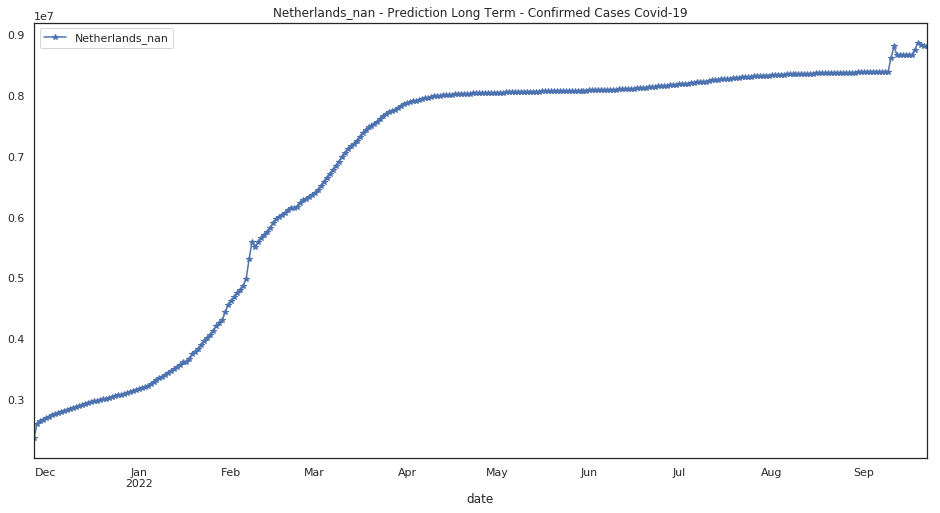

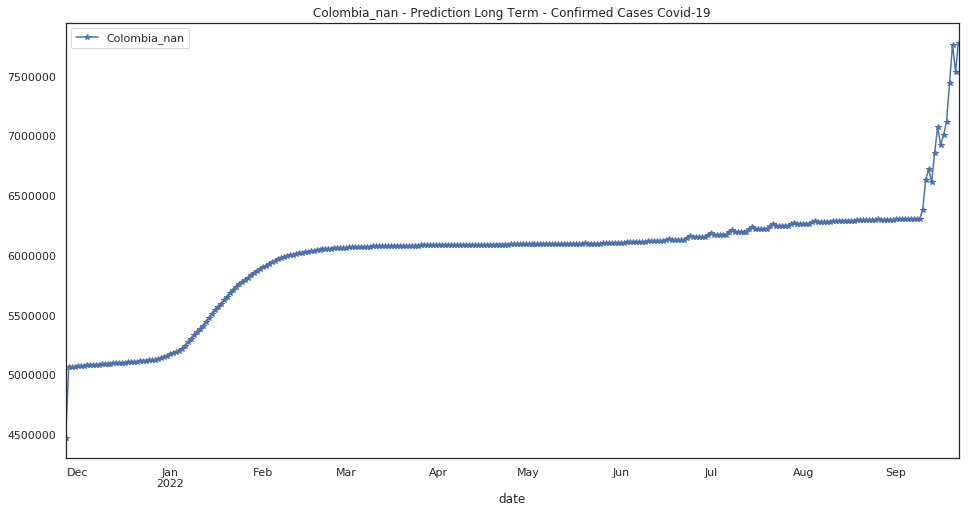

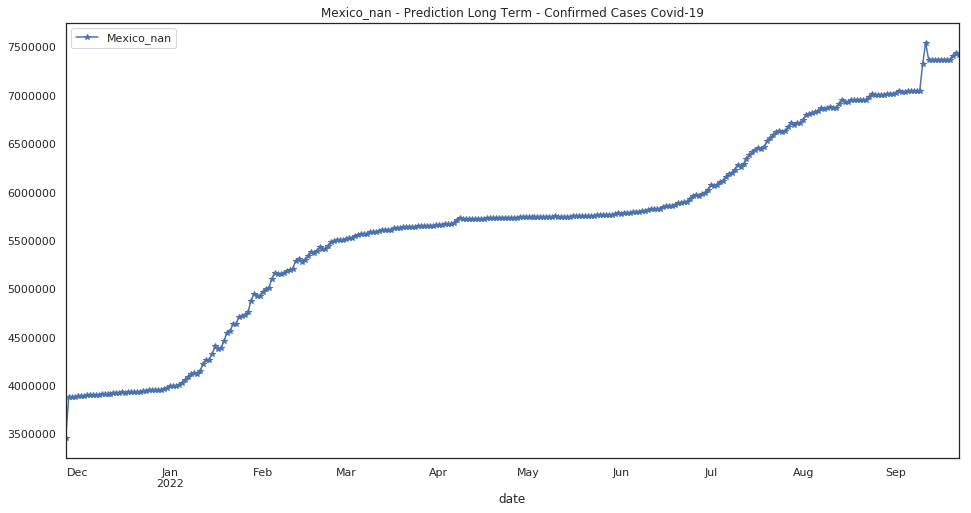

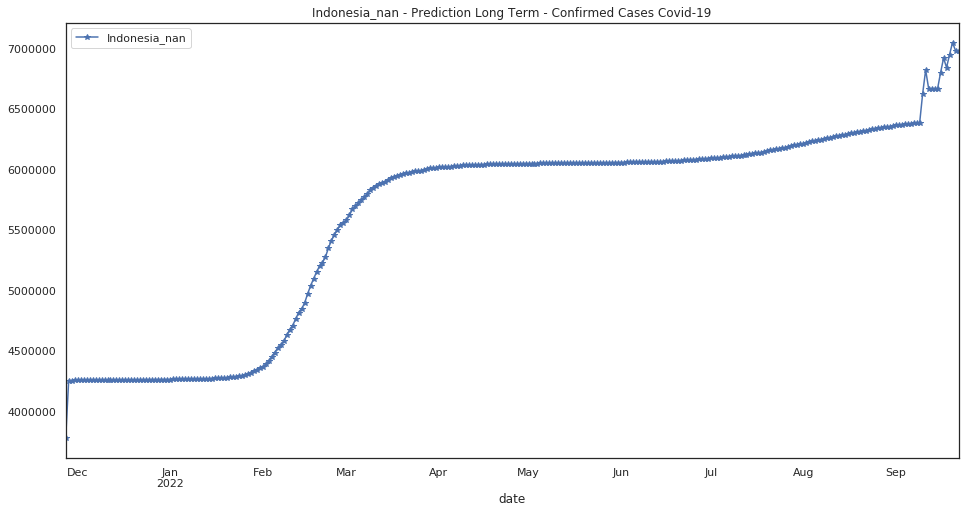

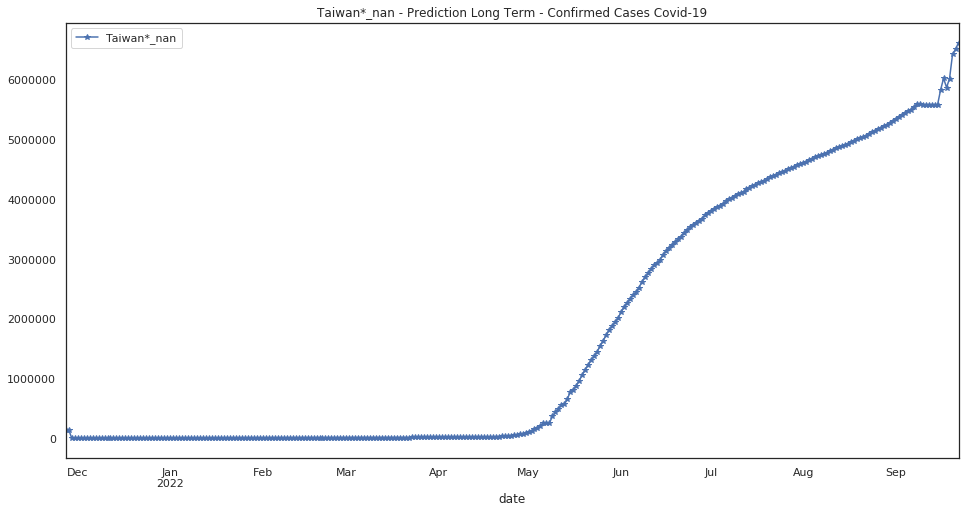

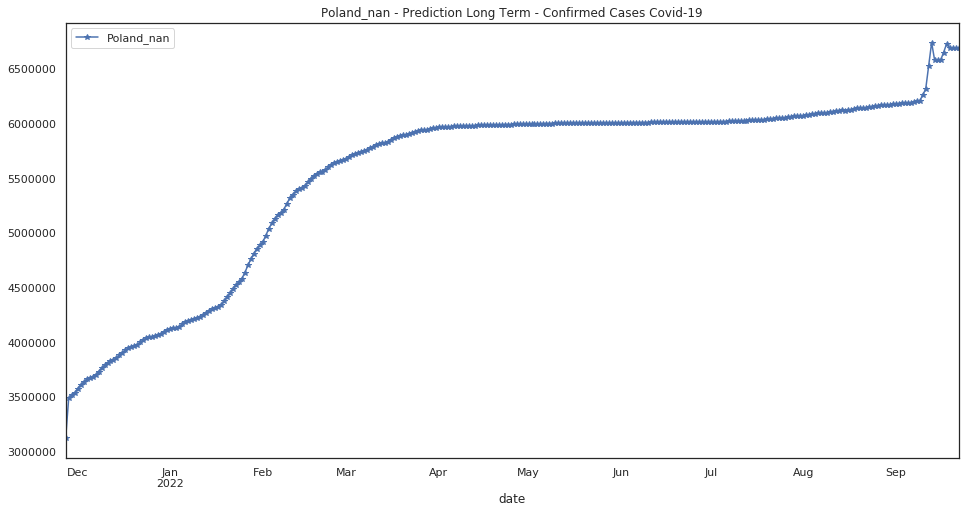

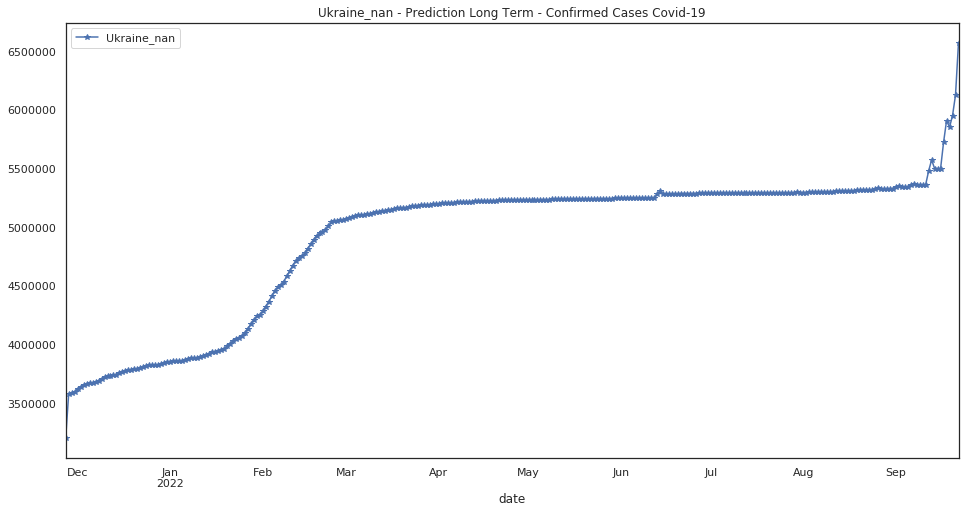

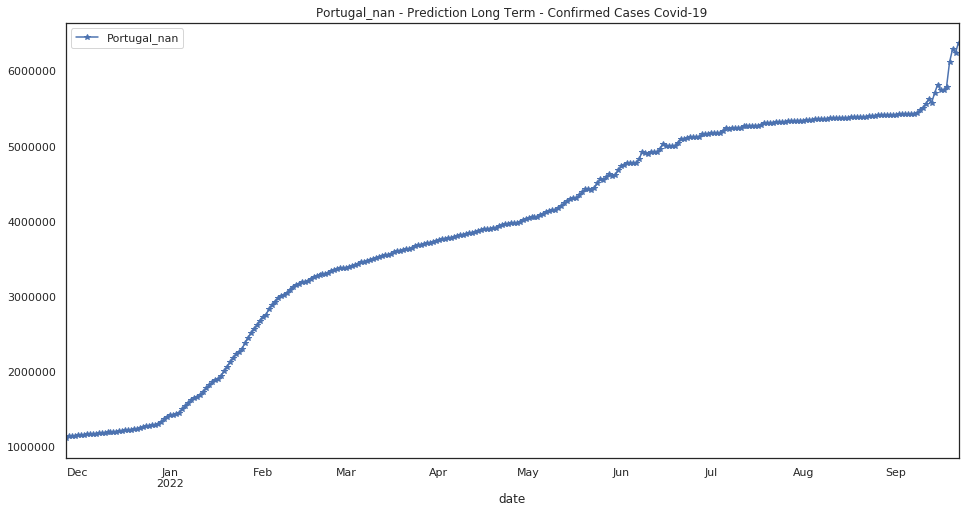

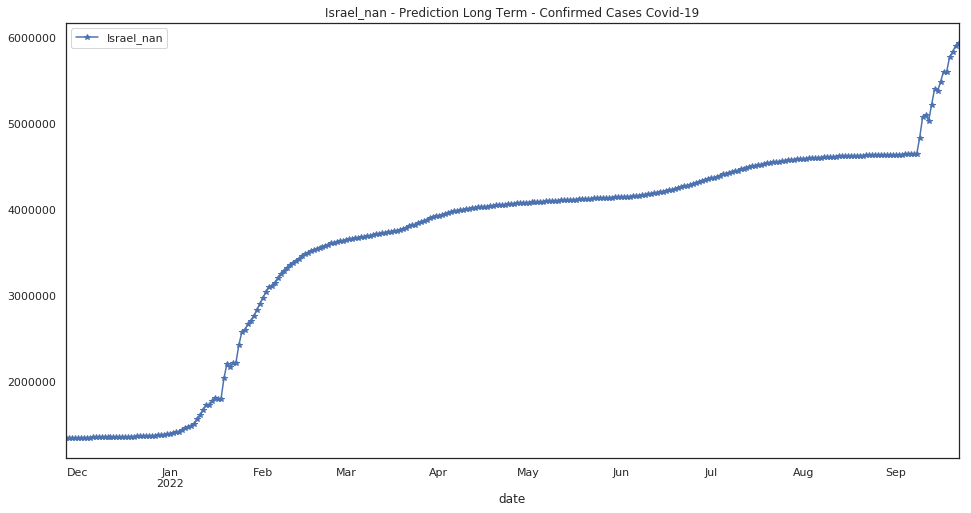

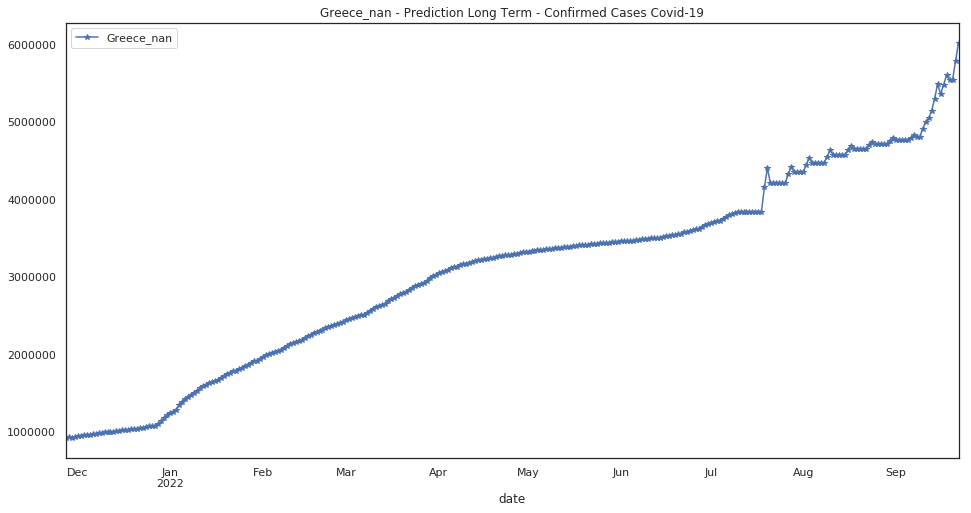

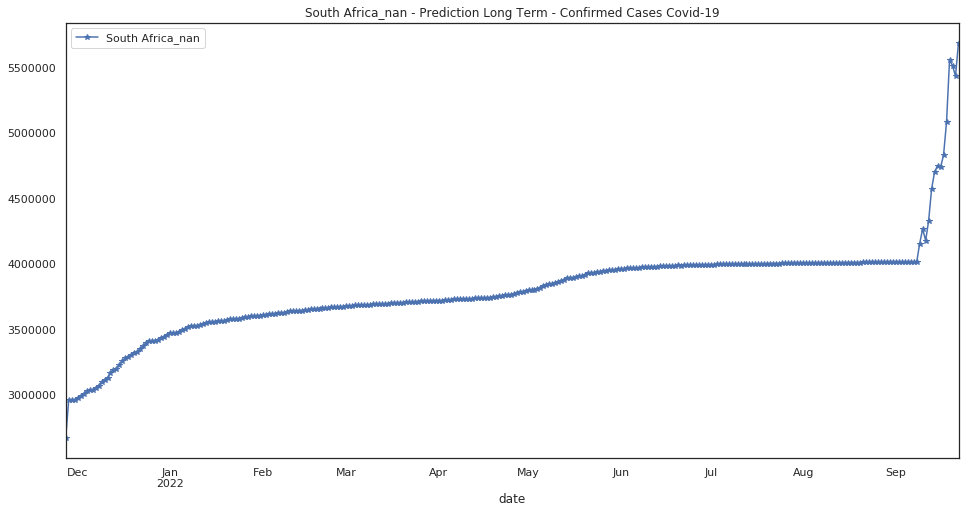

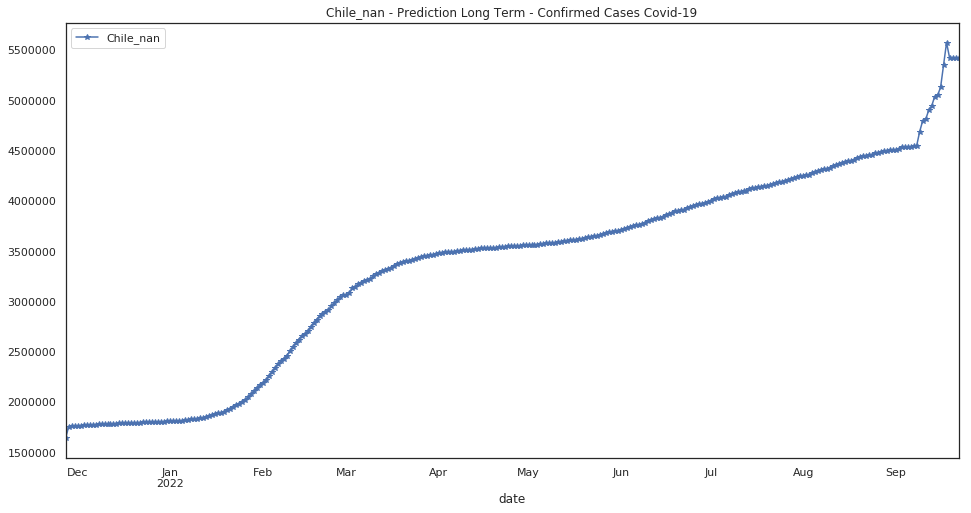

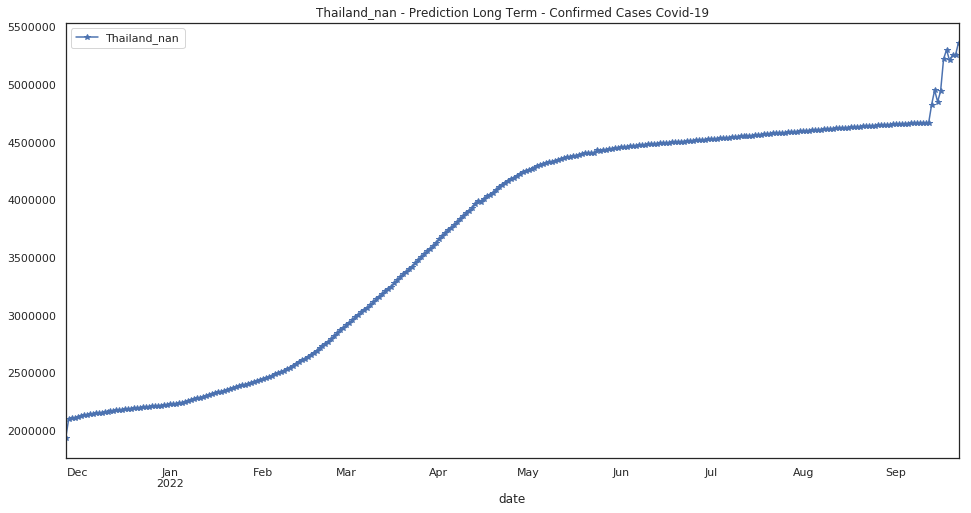

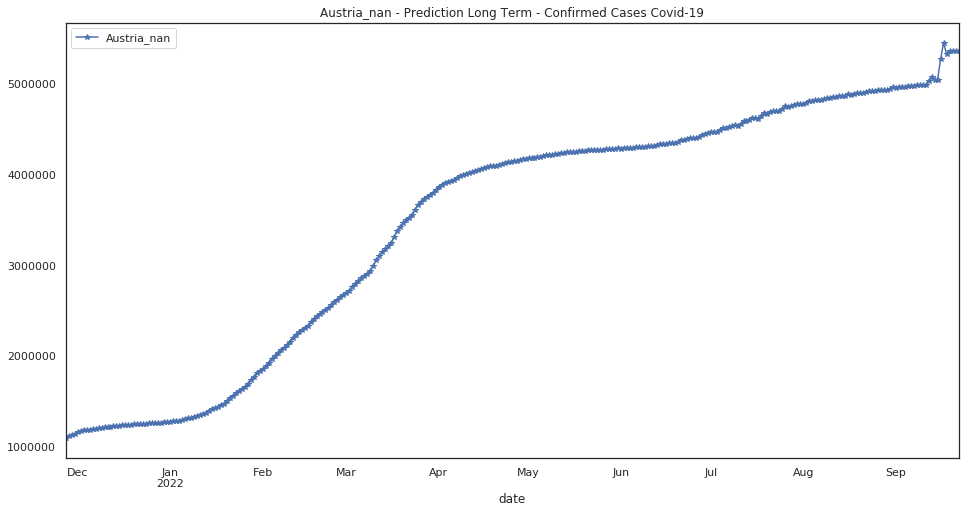

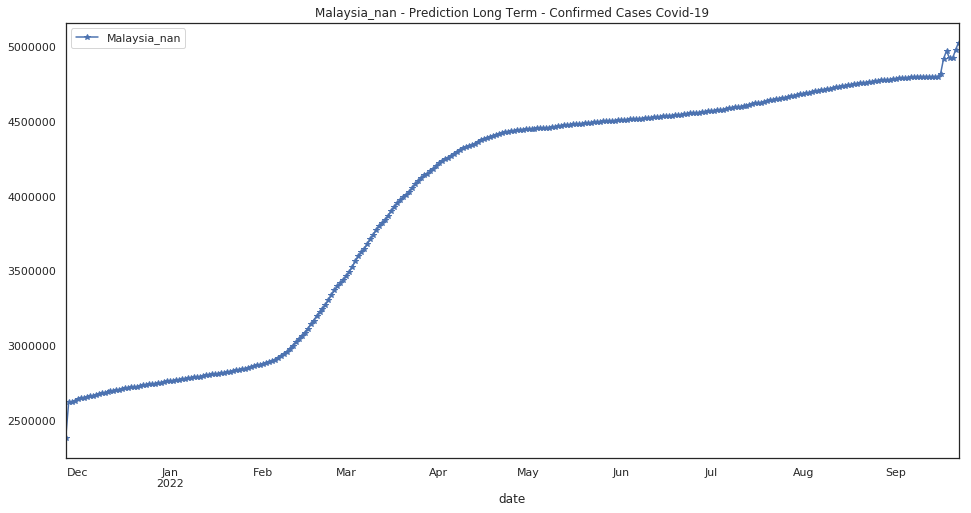

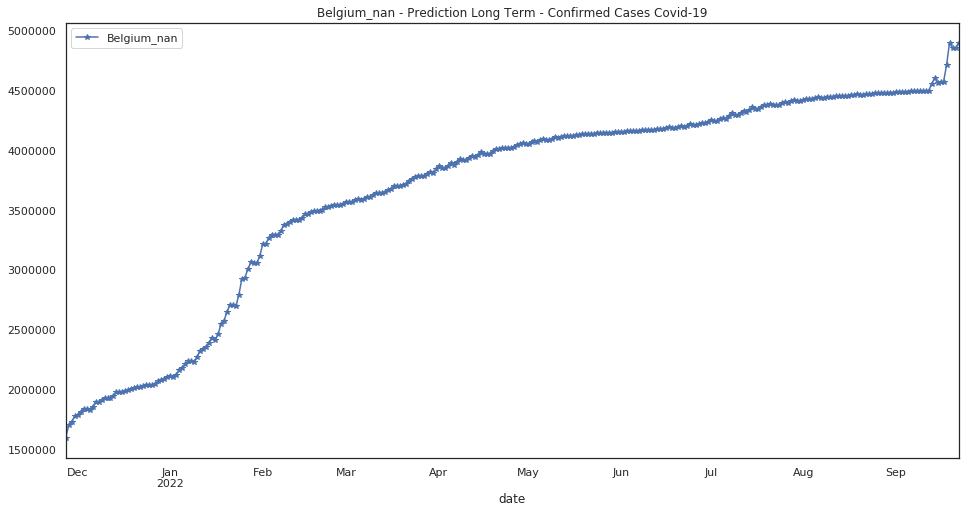

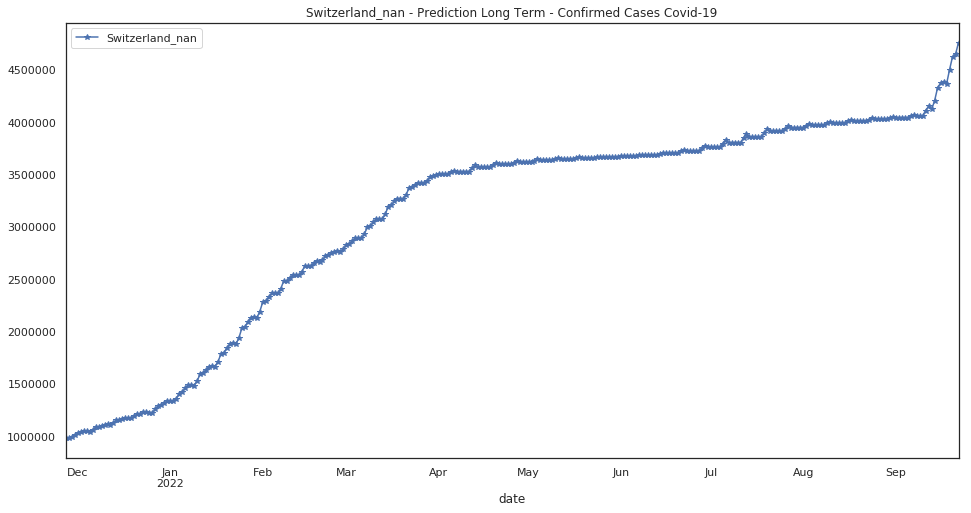

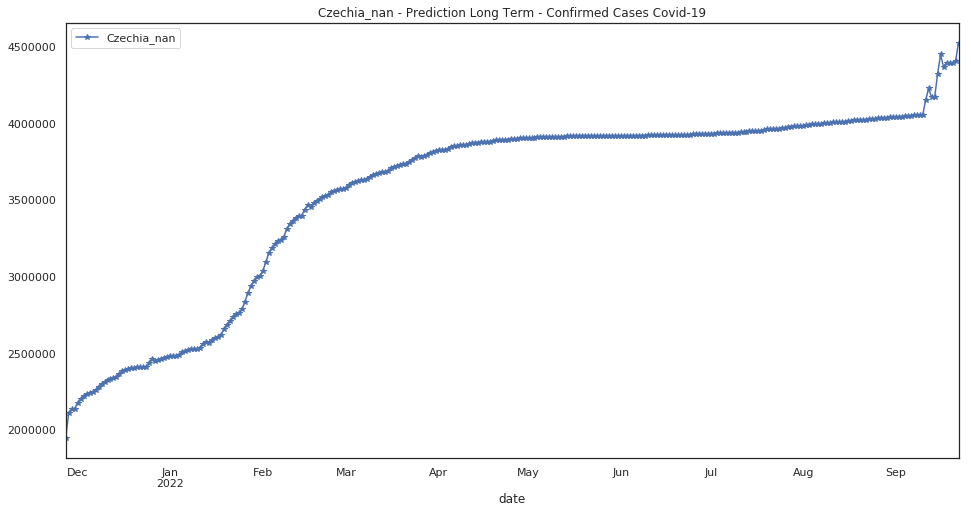

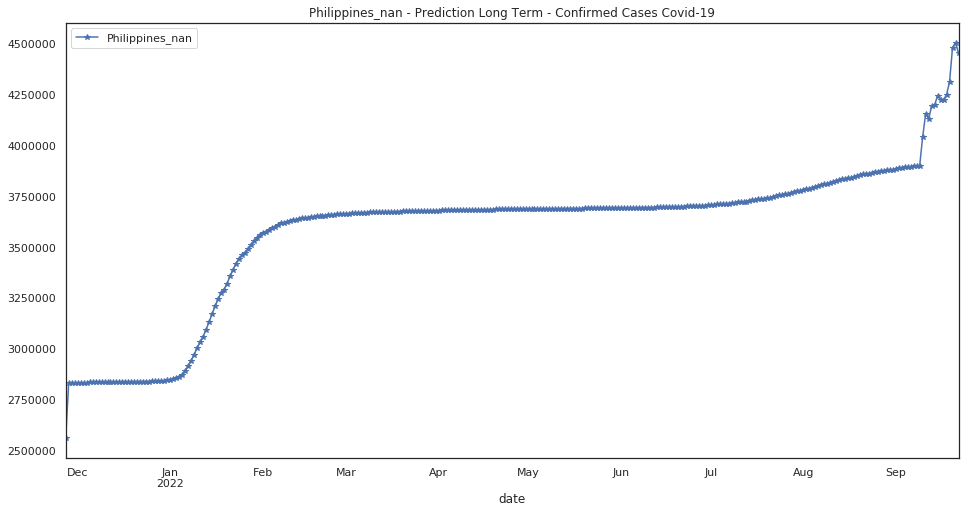

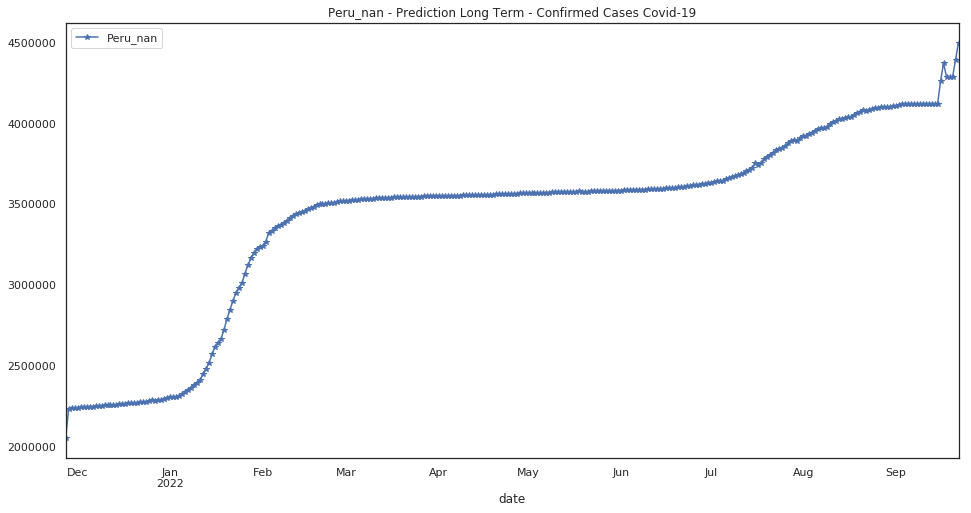

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

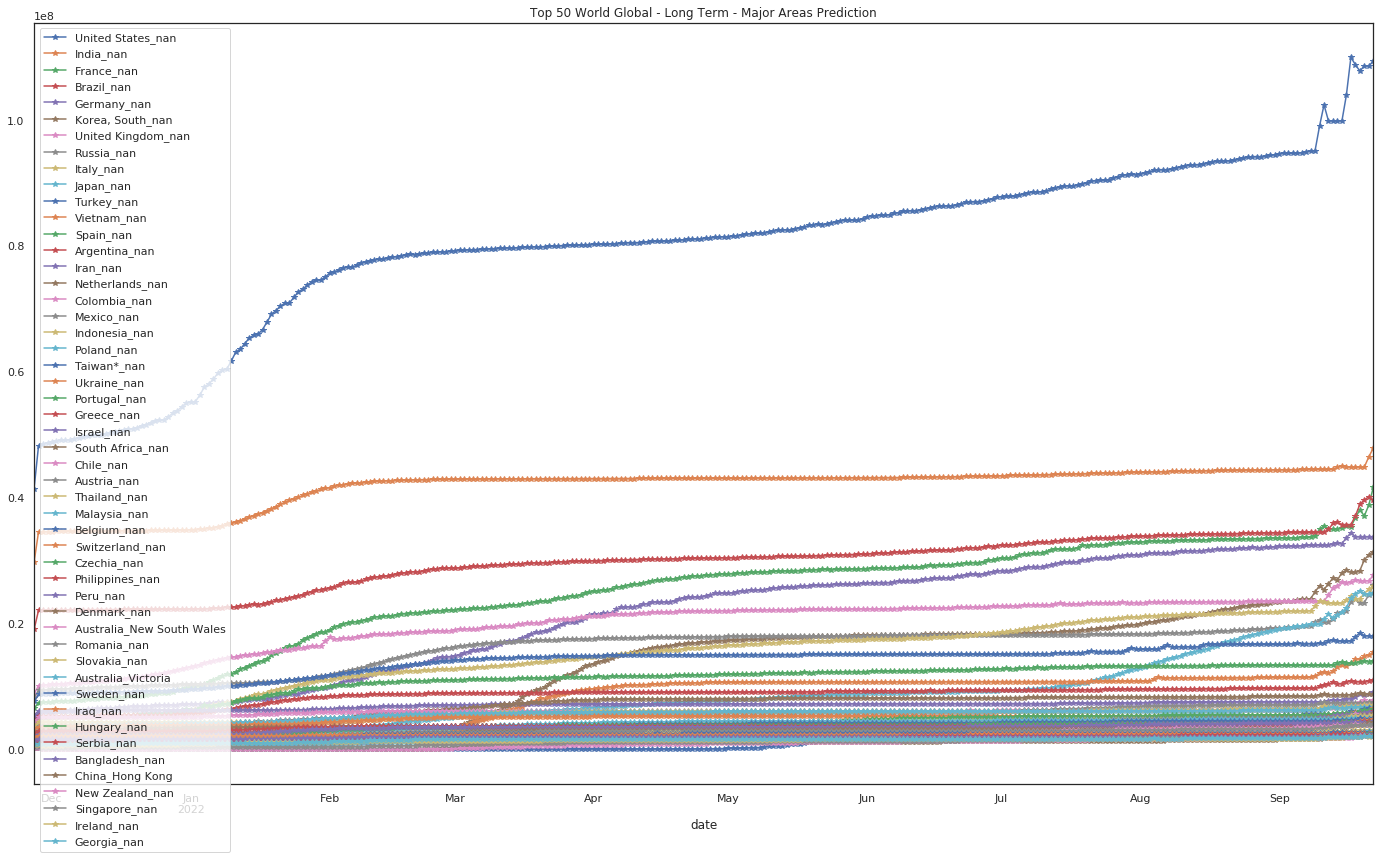

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

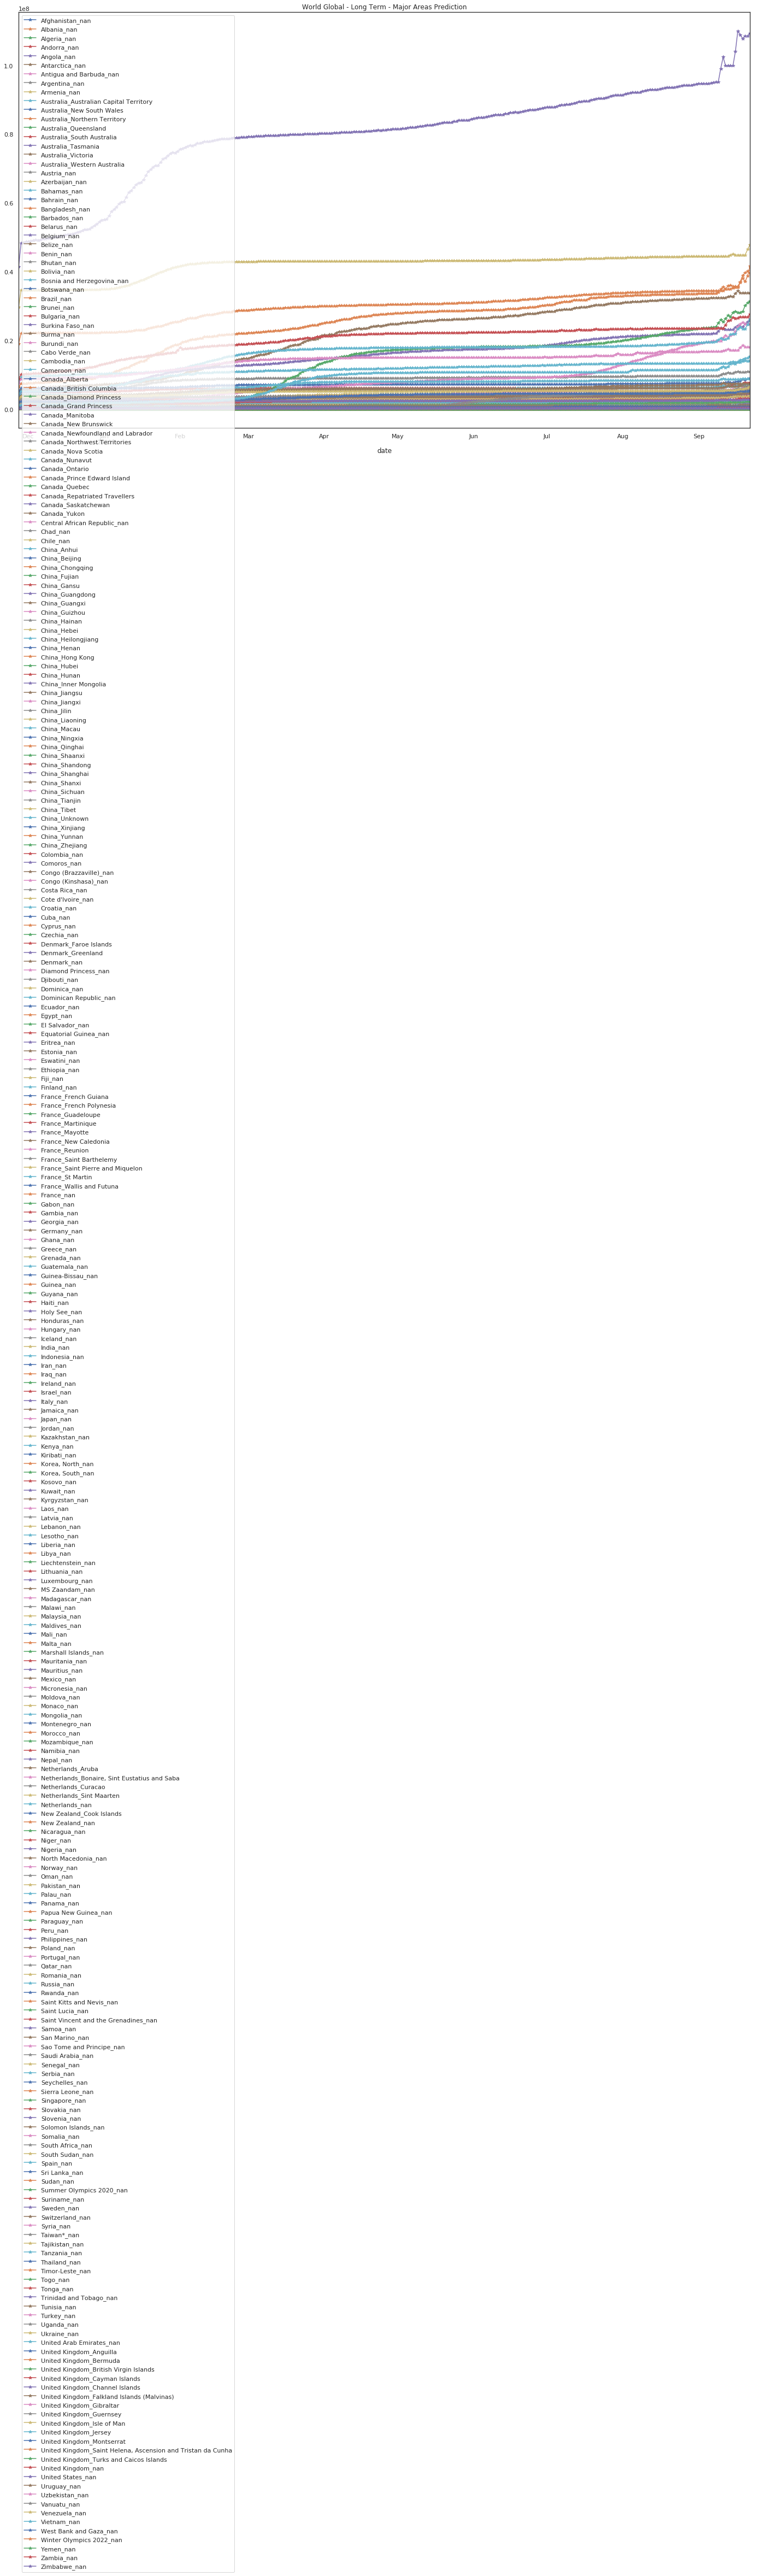

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2022-01-11         160481.0     223571.0     224982.0      27983.0   
2022-01-12         160507.0     225473.0     225578.0      28542.0   
2022-01-13         160601.0     227305.0     226157.0      28899.0   
2022-01-14         160631.0     229456.0     226745.0      30063.0   
2022-01-15         160683.0     231594.0     227258.0      29888.0   
2022-01-16         160720.0     233251.0     227816.0      30139.0   
2022-01-17         160818.0     234536.0     228481.0      30139.0   
2022-01-18         160938.0     237063.0     229264.0      29888.0   
2022-01-19         161031.0     239719.0     230537.0      29888.0   
2022-01-20         161259.0     242133.0     232035.0      31780.0   
2022-01-21         161433.0     244783.0     233818.0      32201.0   
2022-01-22         161491.0     247056.0     235939.0      33025.0   
2022-01-23         161632.0     248777.0     238019.0      33733.0   
2022-01-24         161829.0     248983.0     240160.0      33025.0   
2022-01-25         162120.0     249584.0     242571.0      34121.0   
2022-01-26         162521.0     251655.0     244711.0      34701.0   
2022-01-27         162825.0     253399.0     246804.0      35028.0   
2022-01-28         162952.0     255009.0     248684.0      35590.0   
2022-01-29         163227.0     255314.0     250425.0      35556.0   
2022-01-30         163892.0     256689.0     251945.0      35556.0   
2022-01-31         164526.0     259412.0     253319.0      35556.0   
2022-02-01         165192.0     259756.0     254747.0      35958.0   
2022-02-02         165884.0     261937.0     256178.0      35958.0   
2022-02-03         166416.0     262494.0     257232.0      36315.0   
2022-02-04         167036.0     263991.0     258236.0      36470.0   
2022-02-05         167375.0     264427.0     259097.0      36599.0   
2022-02-06         167891.0     265469.0     259565.0      36599.0   
2022-02-07         168570.0     266043.0     260072.0      36599.0   
2022-02-08         169318.0     266815.0     260712.0      36808.0   
2022-02-09         170122.0     267551.0     261350.0      36808.0   
...                     ...          ...          ...          ...   
2022-08-24         193461.0     328462.0     272013.0      45975.0   
2022-08-25         193818.0     328818.0     272070.0      46027.0   
2022-08-26         193862.0     329174.0     272118.0      46027.0   
2022-08-27         193920.0     329569.0     272153.0      46027.0   
2022-08-28         194342.0     329806.0     272174.0      46027.0   
2022-08-29         194714.0     329867.0     272213.0      46027.0   
2022-08-30         194883.0     330225.0     272255.0      46027.0   
2022-08-31         195163.0     330661.0     272290.0      46027.0   
2022-09-01         195406.0     330920.0     272344.0      46027.0   
2022-09-02         195442.0     331164.0     272393.0      46027.0   
2022-09-03         195809.0     331371.0     272417.0      46027.0   
2022-09-04         196013.0     331509.0     272433.0      46027.0   
2022-09-05         196245.0     331542.0     272450.0      46027.0   
2022-09-06         196522.0     331578.0     272466.0      46027.0   
2022-09-07         196878.0     331813.0     272480.0      46027.0   
2022-09-08         197160.0     332033.0     272498.0      46113.0   
2022-09-09         204892.0     334573.0     272503.0      46113.0   
2022-09-10         204945.0     346545.0     272504.0      47405.0   
2022-09-11         212225.0     349814.0     272505.0      47449.0   
2022-09-12         212493.0     347236.0     272506.0      47676.0   
2022-09-13         212805.0     347197.0     272507.0      48203.0   
2022-09-14         212819.0     347045.0     272508.0      49878.0   
2022-09-15         212609.0     347058.0     272508.0      49878.0   
2022-09-16         212625.0     362884.0     272509.0      51315.0   
2022-09-17

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                                       Antarctica_nan -71.949900   23.347000   
6                              Antigua and Barbuda_nan  17.060800  -61.796400   
7                                        Argentina_nan -38.416100  -63.616700   
8                                          Armenia_nan  40.069100   45.038200   
9               Australia_Australian Capital Territory -35.473500  149.012400   
10                           Australia_New South Wales -33.868800  151.209300   
11                        Australia_Northern Territory -12.463400  130.845600   
12                                Australia_Queensland -27.469800  153.025100   
13                           Australia_South Australia -34.928500  138.600700   
14                                  Australia_Tasmania -42.882100  147.327200   
15                                  Australia_Victoria -37.813600  144.963100   
16                         Australia_Western Australia -31.950500  115.860500   
17                                         Austria_nan  47.516200   14.550100   
18                                      Azerbaijan_nan  40.143100   47.576900   
19                                         Bahamas_nan  25.025885  -78.035889   
20                                         Bahrain_nan  26.027500   50.550000   
21                                      Bangladesh_nan  23.685000   90.356300   
22                                        Barbados_nan  13.193900  -59.543200   
23                                         Belarus_nan  53.709800   27.953400   
24                                         Belgium_nan  50.833300    4.469936   
25                                          Belize_nan  17.189900  -88.497600   
26                                           Benin_nan   9.307700    2.315800   
27                                          Bhutan_nan  27.514200   90.433600   
28                                         Bolivia_nan -16.290200  -63.588700   
29                          Bosnia and Herzegovina_nan  43.915900   17.679100   
..                                                 ...        ...         ...   
261                                        Tunisia_nan  33.886917    9.537499   
262                                         Turkey_nan  38.963700   35.243300   
263                                  United States_nan  40.000000 -100.000000   
264                                         Uganda_nan   1.373333   32.290275   
265                                        Ukraine_nan  48.379400   31.165600   
266                           United Arab Emirates_nan  23.424076   53.847818   
267                            United Kingdom_Anguilla  18.220600  -63.068600   
268                             United Kingdom_Bermuda  32.307800  -64.750500   
269              United Kingdom_British Virgin Islands  18.420700  -64.640000   
270                      United Kingdom_Cayman Islands  19.313300  -81.254600   
271                     United Kingdom_Channel Islands  49.372300   -2.364400   
272         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
273                           United Kingdom_Gibraltar  36.140800   -5.353600   
274                            United Kingdom_Guernsey  49.448196   -2.589490   
275                         United Kingdom_Isle of Man  54.236100   -4.548100   
276                              United Kingdom_Jersey  49.213800   -2.135800   
277                          United Kingdom_Montserrat  16.742498  -62.187366   
278  United Kingdom_Saint Helena, Ascension and Tri...  -7.946700  -14.355900  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                     region        Lat        Long  \
0       7              Argentina_nan -38.416100  -63.616700   
1      10  Australia_New South Wales -33.868800  151.209300   
2      15         Australia_Victoria -37.813600  144.963100   
3      17                Austria_nan  47.516200   14.550100   
4      21             Bangladesh_nan  23.685000   90.356300   
5      24                Belgium_nan  50.833300    4.469936   
6      31                 Brazil_nan -14.235000  -51.925300   
7      60                  Chile_nan -35.675100  -71.543000   
8      73            China_Hong Kong  22.300000  114.200000   
9      95               Colombia_nan   4.570900  -74.297300   
10    104                Czechia_nan  49.817500   15.473000   
11    107                Denmark_nan  56.263900    9.501800   
12    133                 France_nan  46.227600    2.213700   
13    136                Georgia_nan  42.315400   43.356900   
14    137                Georgia_nan  42.315400   43.356900   
15    138                Germany_nan  51.165691   10.451526   
16    140                 Greece_nan  39.074200   21.824300   
17    150                Hungary_nan  47.162500   19.503300   
18    152                  India_nan  20.593684   78.962880   
19    153              Indonesia_nan  -0.789300  113.921300   
20    154                   Iran_nan  32.427908   53.688046   
21    155                   Iraq_nan  33.223191   43.679291   
22    156                Ireland_nan  53.142400   -7.692100   
23    157                 Israel_nan  31.046051   34.851612   
24    158                 Israel_nan  31.046051   34.851612   
25    159                  Italy_nan  41.871940   12.567380   
26    161                  Japan_nan  36.204824  138.252924   
27    167           Korea, South_nan  35.907757  127.766922   
28    184               Malaysia_nan   4.210484  101.975766   
29    191                 Mexico_nan  23.634500 -102.552800   
30    205            Netherlands_nan  52.132600    5.291300   
31    207            New Zealand_nan -40.900600  174.886000   
32    219                   Peru_nan  -9.190000  -75.015200   
33    220            Philippines_nan  12.879721  121.774017   
34    221                 Poland_nan  51.919400   19.145100   
35    222               Portugal_nan  39.399900   -8.224500   
36    224                Romania_nan  45.943200   24.966800   
37    225                 Russia_nan  61.524010  105.318756   
38    235                 Serbia_nan  44.016500   21.005900   
39    238              Singapore_nan   1.283300  103.833300   
40    239               Slovakia_nan  48.669000   19.699000   
41    243           South Africa_nan -30.559500   22.937500   
42    245                  Spain_nan  40.463667   -3.749220   
43    250                 Sweden_nan  60.128161   18.643501   
44    251            Switzerland_nan  46.818200    8.227500   
45    253                Taiwan*_nan  23.700000  121.000000   
46    256               Thailand_nan  15.870032  100.992541   
47    262                 Turkey_nan  38.963700   35.243300   
48    263          United States_nan  40.000000 -100.000000   
49    265                Ukraine_nan  48.379400   31.165600   
50    280         United Kingdom_nan  55.378100   -3.436000   
51    285                Vietnam_nan  14.058324  108.277199   

    2021-11-27 00:00:00  2021-11-28 00:00:00  2021-11-29 00:00:00  \
0             4697184.0            5325560.0            5326448.0   
1              209816.0             209939.0              81499.0   
2              242725.0             243580.0             120814.0   
3             1097073.0            1118256.0            1133791.0   
4             1488395.0            1575579.0            1575784.0   
5             1596257.0            1701633.0            1731427.0   
6            19035216.0           22081833.0           22085369.0   
7             1643700.0            1757077.0            1759405.0   
8              150833.0             150835.

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()